In [1]:
import os

# Third-party
from astropy.io import ascii, fits
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

from gary.units import galactic
import gary.coordinates as gc

from ophiuchus import vcirc, vlsr
import ophiuchus.potential as op

### Read in a reasonable model for the MW potential 

In [2]:
mw_pot = op.load_potential('static_mw')

Melissa's red clump data with ages, Bovy's red clump data with abundances (from APOGEE)

In [3]:
rc_age = ascii.read("/Users/adrian/projects/brucewillis/data/redclump_catalogue_apw.txt")
rc_age.rename_column('name', 'APOGEE_ID')
rc_bovy = at.Table(fits.getdata("/Users/adrian/projects/brucewillis/data/apogee-rc-DR12.fits", 1))

In [4]:
rc = at.join(rc_age, rc_bovy, keys='APOGEE_ID')
len(rc_age), len(rc_bovy), len(rc)

(17065, 19937, 17065)

In [5]:
print(rc.colnames)

['APOGEE_ID', 'radius', 'z', 'FeH', 'alphaFe', 'age', 'chi2_reduced', 'APSTAR_ID', 'ASPCAP_ID', 'TELESCOPE', 'LOCATION_ID', 'FIELD', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'RA', 'DEC', 'GLON', 'GLAT', 'APOGEE_TARGET1', 'APOGEE_TARGET2', 'TARGFLAGS', 'NVISITS', 'COMMISS', 'SNR', 'STARFLAG', 'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR', 'VERR_MED', 'STABLERV_CHI2', 'STABLERV_RCHI2', 'STABLERV_CHI2_PROB', 'EXTRATARG', 'PARAM', 'FPARAM', 'PARAM_COV', 'FPARAM_COV', 'ELEM', 'FELEM', 'ELEM_ERR', 'FELEM_ERR', 'TEFF', 'LOGG', 'PARAM_M_H', 'PARAM_ALPHA_M', 'TEFF_ERR', 'LOGG_ERR', 'PARAM_M_H_ERR', 'PARAM_ALPHA_M_ERR', 'ASPCAP_CHI2', 'ASPCAP_CLASS', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'PARAMFLAG', 'AL_H', 'CA_H', 'C_H', 'FE_H', 'K_H', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'SI_H', 'S_H', 'TI_H', 'V_H', 'AL_H_ERR', 'CA_H_ERR', 'C_H_ERR', 'FE_H_ERR', 'K_H_ERR', 'MG_H_ERR', 'MN_H_ERR', 'NA_H_ERR', 'NI_H_ERR', 'N_H_ERR', 'O_H_ERR', 'SI_H_ERR', 'S_H_ERR', 'TI_H_ERR', 'V_H_ERR

Turn -9999. into NaN's -- curse you SDSS!

In [6]:
for colname in rc.colnames:
    if rc[colname].dtype.name not in ['float64', 'float32']:
        continue
    
    ix = np.isclose(rc[colname], -9999.)
    rc[colname][ix] = np.nan

Proper motions are from UCAC-4 so they suck, distance errors claimed to be 5%

In [71]:
rv_c = coord.ICRS(ra=rc['RA']*u.degree, dec=rc['DEC']*u.degree, distance=rc['RC_DIST']*u.kpc)
distance_err = rc['RC_DIST'] * u.kpc * 0.05

rv = rc['VHELIO_AVG']*u.km/u.s
rv_err = np.sqrt(rc['VERR']**2 + rc['VSCATTER']**2)*u.km/u.s

pm_ra = rc['PMRA']*u.mas/u.yr
pm_ra_err = rc['PMRA_ERR']*u.mas/u.yr

pm_dec = rc['PMDEC']*u.mas/u.yr
pm_dec_err = rc['PMDEC_ERR']*u.mas/u.yr

pm_ra[pm_ra.value < -9999.] = np.nan
pm_dec[pm_dec.value < -9999.] = np.nan
pm_ra_err[pm_ra_err.value < -9999.] = np.nan
pm_dec_err[pm_dec_err.value < -9999.] = np.nan

Convert positions and velocities to Galactocentric quantities

In [8]:
xyz = rv_c.transform_to(coord.Galactocentric).cartesian.xyz
vxyz = gc.vhel_to_gal(rv_c, rv=rv, pm=(pm_ra, pm_dec))

Compute angular momentum, energy (per unit mass)...

In [9]:
L = np.cross(xyz, vxyz, axis=0)

In [10]:
E = mw_pot.total_energy(x=xyz.decompose(galactic).value, 
                        v=vxyz.decompose(galactic).value)

In [102]:
Lxy = np.sqrt(L[0]**2 + L[1]**2)
Lz = L[2]
Ltot = np.sqrt(np.sum(L**2, axis=0))

Estimate radial, azimuthal, vertical frequencies

In [157]:
import gary.dynamics as gd
from scipy.signal import argrelmax, argrelmin

In [169]:
w0 = gd.CartesianPhaseSpacePosition(pos=xyz, vel=vxyz)
orbits = mw_pot.integrate_orbit(w0, dt=0.5, nsteps=2000)

In [179]:
t = orbits.t

allfreqs = np.zeros((3,len(rc)))
for i in range(len(rc)):
    cyl,_ = orbits[:,i].represent_as(coord.CylindricalRepresentation)

    freqs = []
    for name in ['rho','phi','z']:
        i_max = argrelmax(getattr(cyl,name).value)[0]
        i_min = argrelmin(getattr(cyl,name).value)[0]
        T_max = t[i_max[1:]] - t[i_max[:-1]]
        T_min = t[i_min[1:]] - t[i_min[:-1]]
        freqs.append(2*np.pi/np.median((np.median(T_max).value, np.median(T_min).value)))
    allfreqs[:,i] = freqs

/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, plus)
/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater
  results &= comparator(main, minus)
/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/scipy/signal/_peak_finding.py:68: 

Compute E, L for samples from uncertainty distribution to check typical error in E, L

In [77]:
def nan_median_absolute_deviation(x):
    return np.nanmedian(np.abs(x - np.nanmedian(x)))

In [86]:
ntrials = 128
nsamples = 1024
E_MADs = []
L_MADs = []
for i in np.random.randint(len(rc), size=ntrials):
    this_c = rv_c[i]
    
    ra = np.zeros(nsamples) + this_c.ra.degree
    dec = np.zeros(nsamples) + this_c.dec.degree
    distance = np.random.normal(this_c.distance.value, distance_err.value[i], size=nsamples)
    sample_c = coord.ICRS(ra=ra*u.degree, dec=dec*u.degree, distance=distance*u.kpc)
    sample_xyz = sample_c.transform_to(coord.Galactocentric).cartesian.xyz
    
    sample_pm_ra = np.random.normal(pm_ra.value[i], pm_ra_err.value[i], size=nsamples)*u.mas/u.yr
    sample_pm_dec = np.random.normal(pm_dec.value[i], pm_dec_err.value[i], size=nsamples)*u.mas/u.yr
    sample_rv = np.random.normal(rv.value[i], rv_err.value[i], size=nsamples)*u.km/u.s
    sample_vxyz = gc.vhel_to_gal(sample_c, rv=sample_rv, pm=(sample_pm_ra, sample_pm_dec))
    
    sample_L = np.cross(sample_xyz, sample_vxyz, axis=0)
    sample_Ltot = np.sqrt(np.sum(sample_L**2, axis=0))
    sample_E = mw_pot.total_energy(x=sample_xyz.decompose(galactic).value, 
                                   v=sample_vxyz.decompose(galactic).value)
    
    E_MADs.append(nan_median_absolute_deviation(sample_E))
    L_MADs.append(nan_median_absolute_deviation(sample_Ltot))
    
E_MADs = np.array(E_MADs)
L_MADs = np.array(L_MADs)

/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:689: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


TAKING THE MEDIAN OF THE MEDIAN ABSOLUTE DEVIATIONS -- COME AT ME I HAVE NO FEAR

In [96]:
E_scale = 1.48 * np.nanmedian(E_MADs) # MAD to std dev
L_scale = 1.48 * np.nanmedian(L_MADs) # MAD to std dev

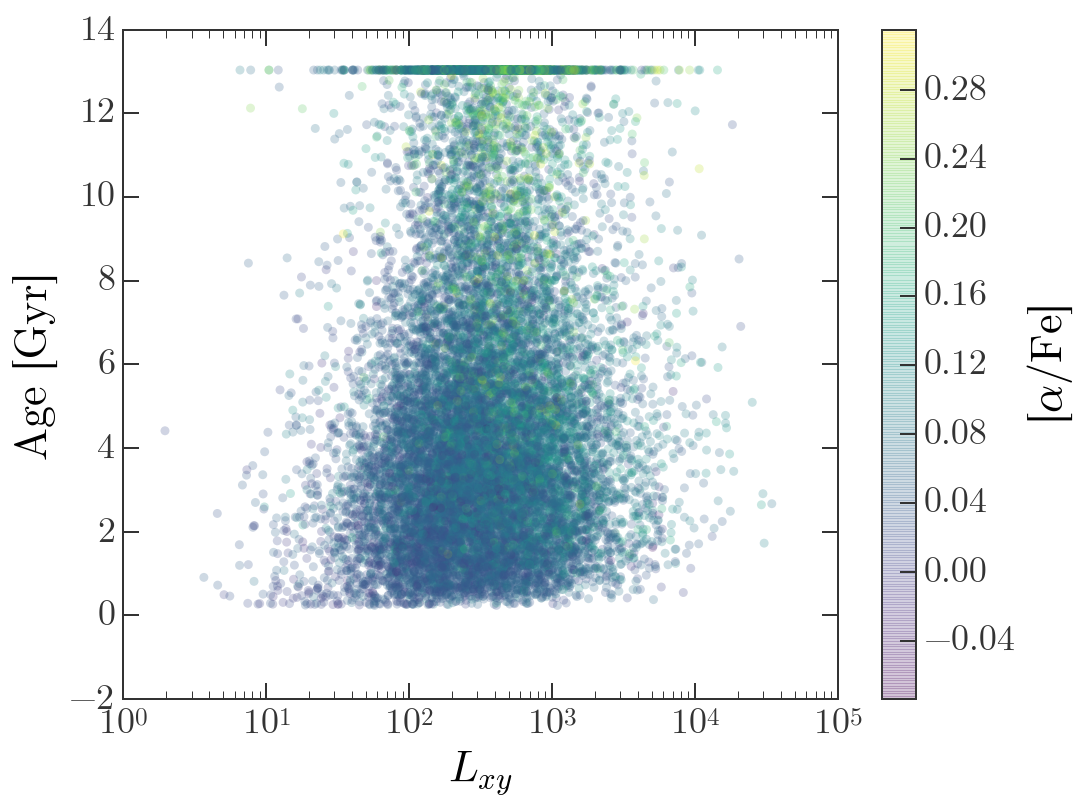

In [92]:
pl.figure(figsize=(8,6))
pl.scatter(Lxy, rc['age'], marker='o', alpha=0.24,
           c=rc['alphaFe'], cmap='viridis')
pl.xscale('log')
cb = pl.colorbar()
cb.set_label(r'[$\alpha/{\rm Fe}$]')
pl.xlabel('$L_{xy}$')
pl.ylabel('Age [Gyr]')

/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


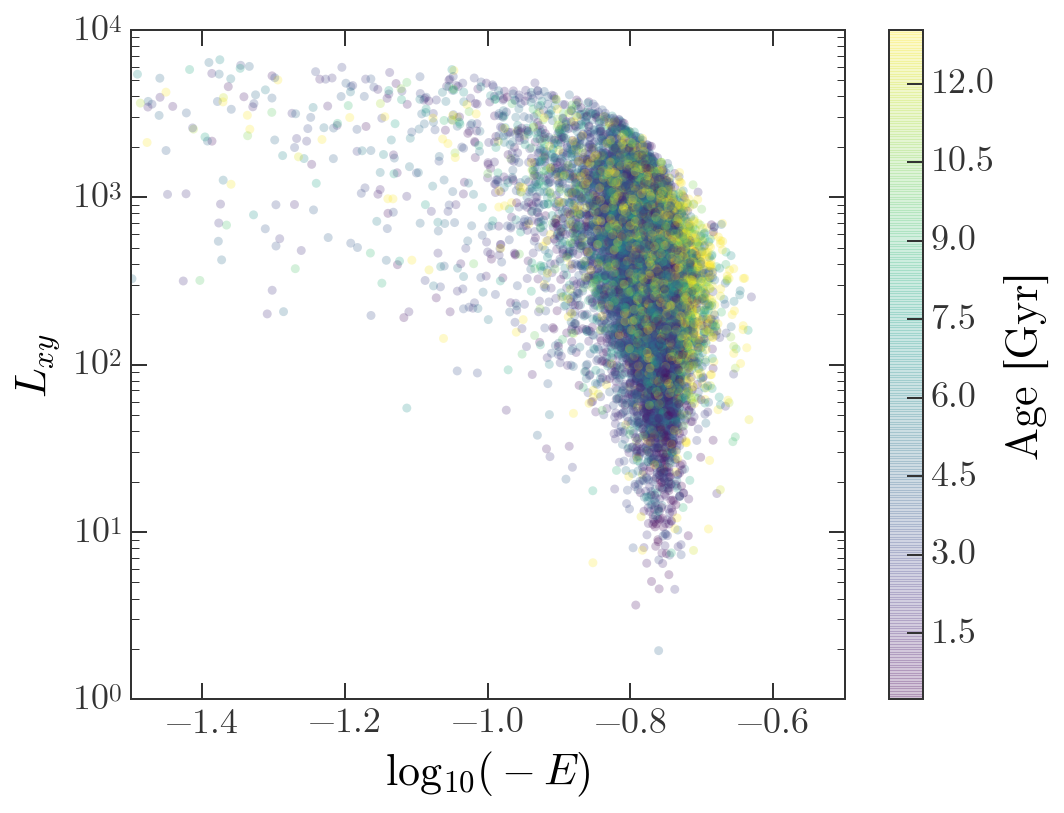

In [128]:
pl.figure(figsize=(8,6))
pl.scatter(np.log10(-E), Lxy, marker='o', alpha=0.24,
           c=rc['age'], cmap='viridis')
pl.xlim(-1.5, -0.5)
pl.yscale('log')
cb = pl.colorbar()
cb.set_label('Age [Gyr]')
pl.xlabel(r'$\log_{10}(-E)$')
pl.ylabel('$L_{xy}$')

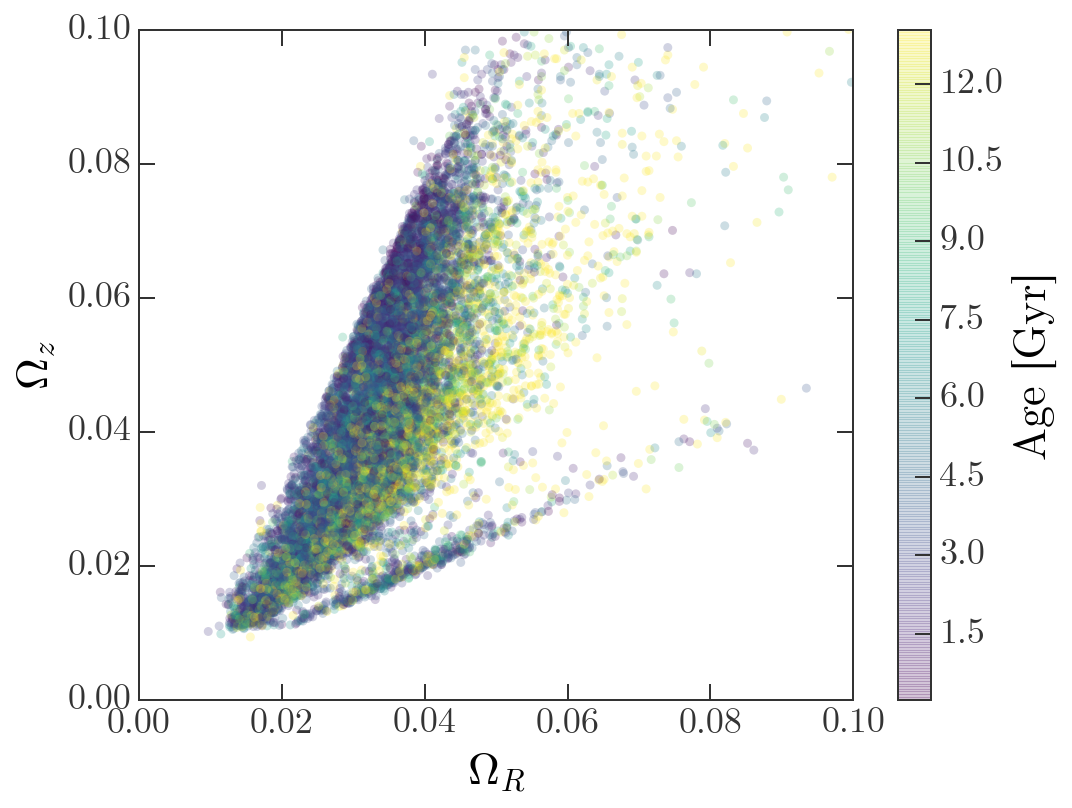

In [183]:
pl.figure(figsize=(8,6))
pl.scatter(allfreqs[0], allfreqs[2], marker='o', alpha=0.24,
           c=rc['age'], cmap='viridis')
pl.xlim(0., 0.1)
pl.ylim(0., 0.1)
cb = pl.colorbar()
cb.set_label('Age [Gyr]')
pl.xlabel(r'$\Omega_R$')
pl.ylabel(r'$\Omega_z$')

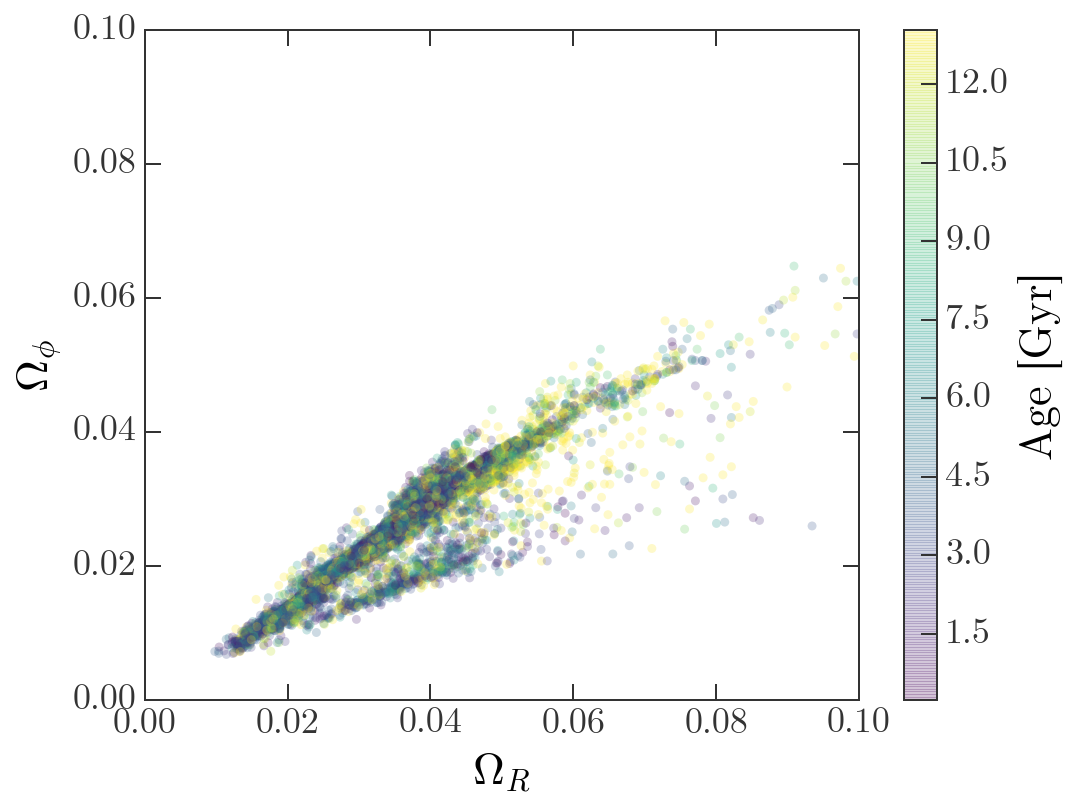

In [184]:
pl.figure(figsize=(8,6))
pl.scatter(allfreqs[0], allfreqs[1], marker='o', alpha=0.24,
           c=rc['age'], cmap='viridis')
pl.xlim(0., 0.1)
pl.ylim(0., 0.1)
cb = pl.colorbar()
cb.set_label('Age [Gyr]')
pl.xlabel(r'$\Omega_R$')
pl.ylabel(r'$\Omega_\phi$')

---

In [94]:
from sklearn.cluster import KMeans
from astropy.stats import median_absolute_deviation

Cram the features into a matrix, `X = (n_samples, n_features)`

In [185]:
feature_cols = ['FeH', 'alphaFe', 'age'] + [x for x in rc.colnames if x.endswith('_H') and x!='PARAM_M_H']
feature_names = ['E', 'Lxy', 'Lz', 'Ltot', 'omegaR', 'omegaPhi', 'omegaZ'] + feature_cols
print(feature_names)

['E', 'Lxy', 'Lz', 'Ltot', 'omegaR', 'omegaPhi', 'omegaZ', 'FeH', 'alphaFe', 'age', 'AL_H', 'CA_H', 'C_H', 'FE_H', 'K_H', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'SI_H', 'S_H', 'TI_H', 'V_H']


### Normalize the energy by the typical uncertainty

/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


(1, 1.5)

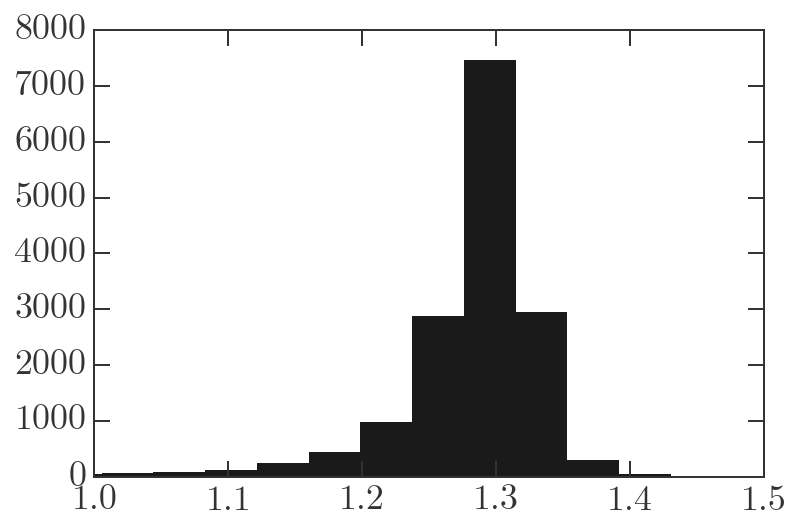

In [100]:
logE = np.log10(-E / E_scale)
pl.hist(logE[np.isfinite(logE)], bins=64)
pl.xlim(1, 1.5)

### Normalize angular momentum

/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()


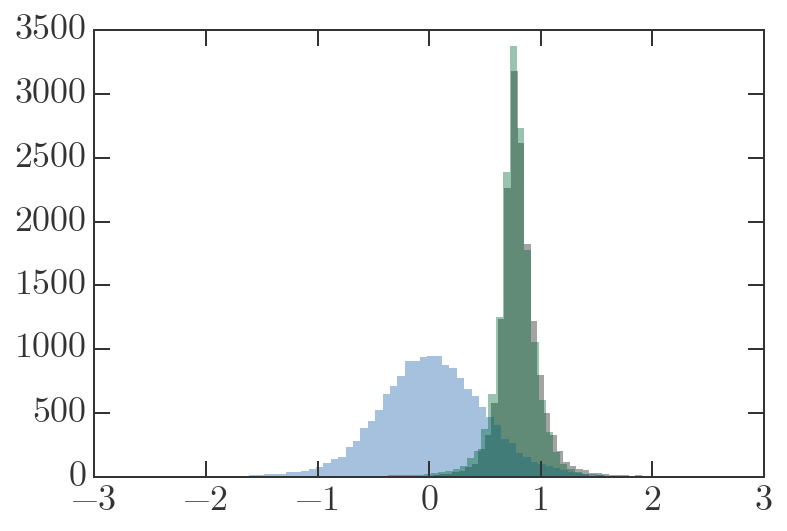

In [112]:
logLtot = np.log10(Ltot / L_scale)
logLxy = np.log10(Lxy / L_scale)
logLz = np.log10(-Lz / L_scale) # ignore retrograde for now :(

pl.hist(logLtot[np.isfinite(logLtot)], bins=64, alpha=0.4)
pl.hist(logLxy[np.isfinite(logLxy)], bins=64, alpha=0.4)
_ = pl.hist(logLz[np.isfinite(logLz)], bins=64, alpha=0.4)

In [186]:
X = np.zeros((len(rc), 7 + len(feature_cols))) # E, Lxy, Lz, Ltot, omegaR, omegaPhi, omegaZ + chemistry
X[:,0] = logE
X[:,1] = logLxy
X[:,2] = logLz
X[:,3] = logLtot
X[:,4:7] = allfreqs.T / 0.01
for i,col in enumerate(feature_cols, 7):
    if '_H' in col:
        scale = np.nanmedian(rc['{}_ERR'.format(col)])
    else:
        scale = 1.
    X[:,i] = rc[col] / scale
    
# For now, only take stars with non-NAN values
non_nan = np.all(np.isfinite(X), axis=1)
X = X[non_nan]

In [187]:
X.shape

(13352, 25)

Hard-set the number of clusters and the number of random KMeans initializations to choose from

In [188]:
n_clusters = 64
ntrials = 16

scores = np.zeros(ntrials)
for i in range(ntrials):
    km = KMeans(n_clusters=n_clusters, random_state=i)
    km.fit(X)
    scores[i] = km.score(X)

Pick the "best" initialization based on the classification score

In [189]:
km = KMeans(n_clusters=n_clusters, random_state=scores.argmax())
km.fit(X)
km.score(X)

-385918.77526273881

In [190]:
nmembers_per_cluster = np.zeros(km.n_clusters)
for k in range(km.n_clusters):
    members = km.labels_ == k
    nmembers_per_cluster[k] = members.sum()

(array([  6.,   7.,  12.,   8.,   5.,   5.,   8.,   6.,   2.,   5.]),
 array([   1. ,   48.3,   95.6,  142.9,  190.2,  237.5,  284.8,  332.1,
         379.4,  426.7,  474. ]),
 <a list of 10 Patch objects>)

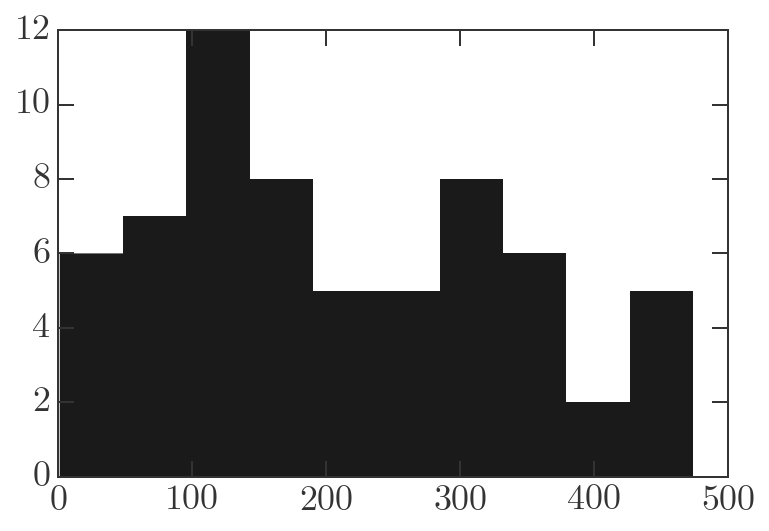

In [191]:
pl.hist(nmembers_per_cluster)

In [192]:
def plot_clusters(xfeature, yfeature):
    fig,ax = pl.subplots(1,1,figsize=(6,6))

    ix0 = feature_names.index(xfeature)
    ix1 = feature_names.index(yfeature)

    for k in range(km.n_clusters):
        members = km.labels_ == k
        cluster_center = km.cluster_centers_[k]
        l, = ax.plot(X[members, ix0], X[members, ix1], marker='.', ls='none')
    #     ax.plot(cluster_center[ix0], cluster_center[ix1], 'o', ls='none', color=l.get_color(),
    #             markeredgecolor='k', markersize=6)

    pl.xlabel(xfeature)
    pl.ylabel(yfeature)

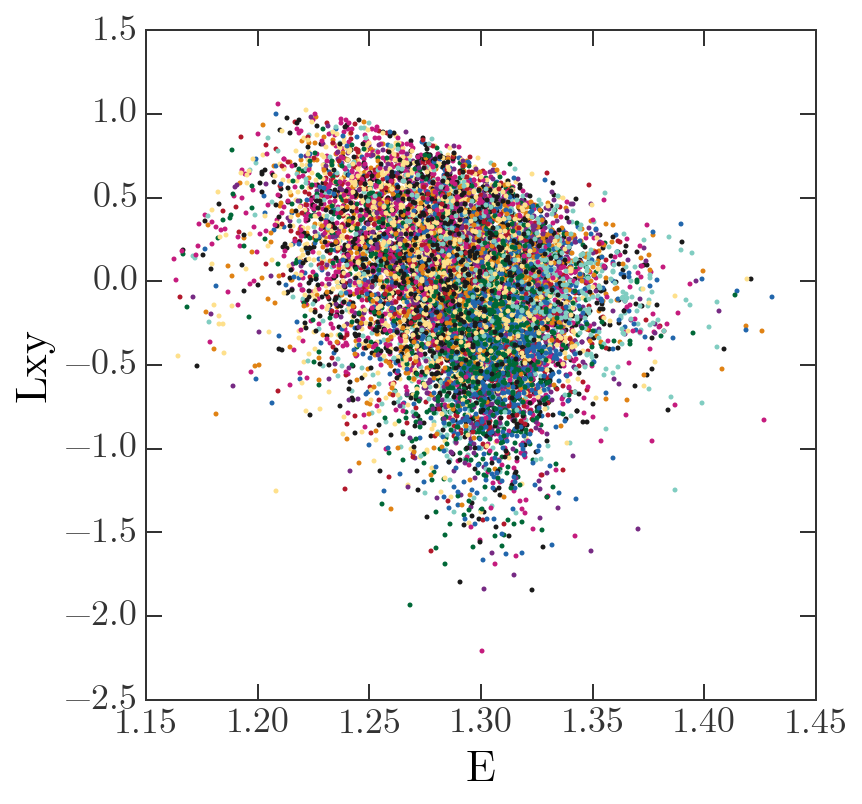

In [193]:
plot_clusters("E", "Lxy")

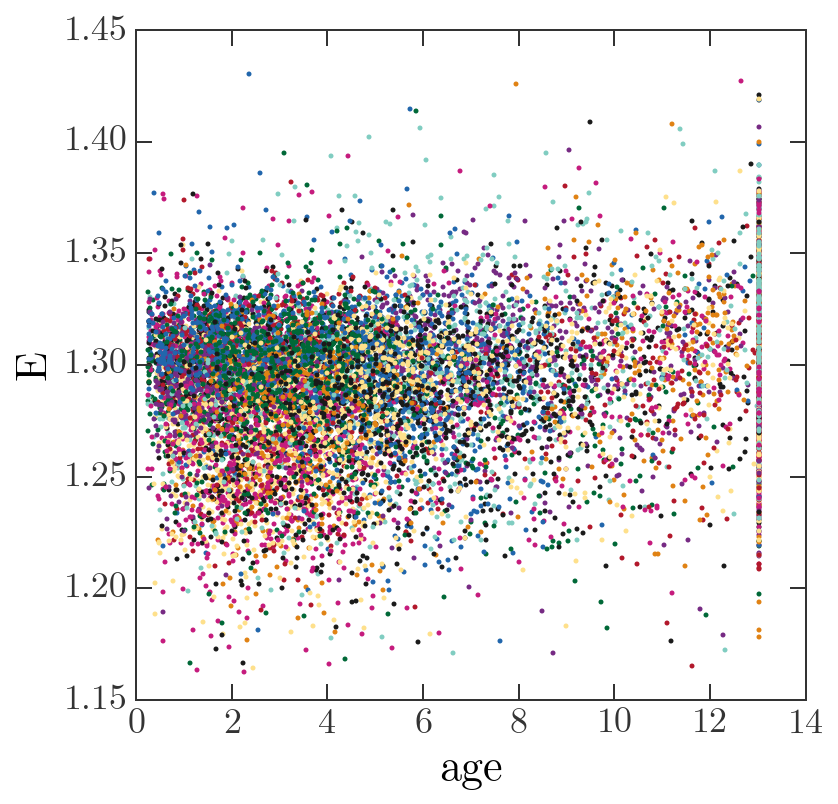

In [194]:
plot_clusters("age", "E")

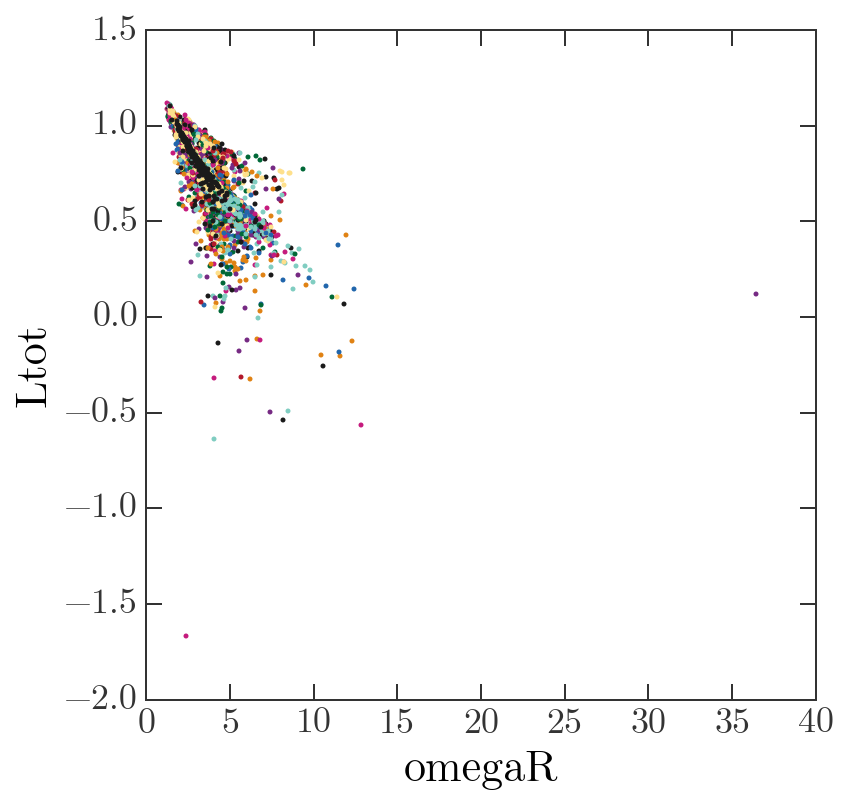

In [202]:
plot_clusters("omegaR", "Ltot")

/Users/adrian/anaconda/envs/three/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


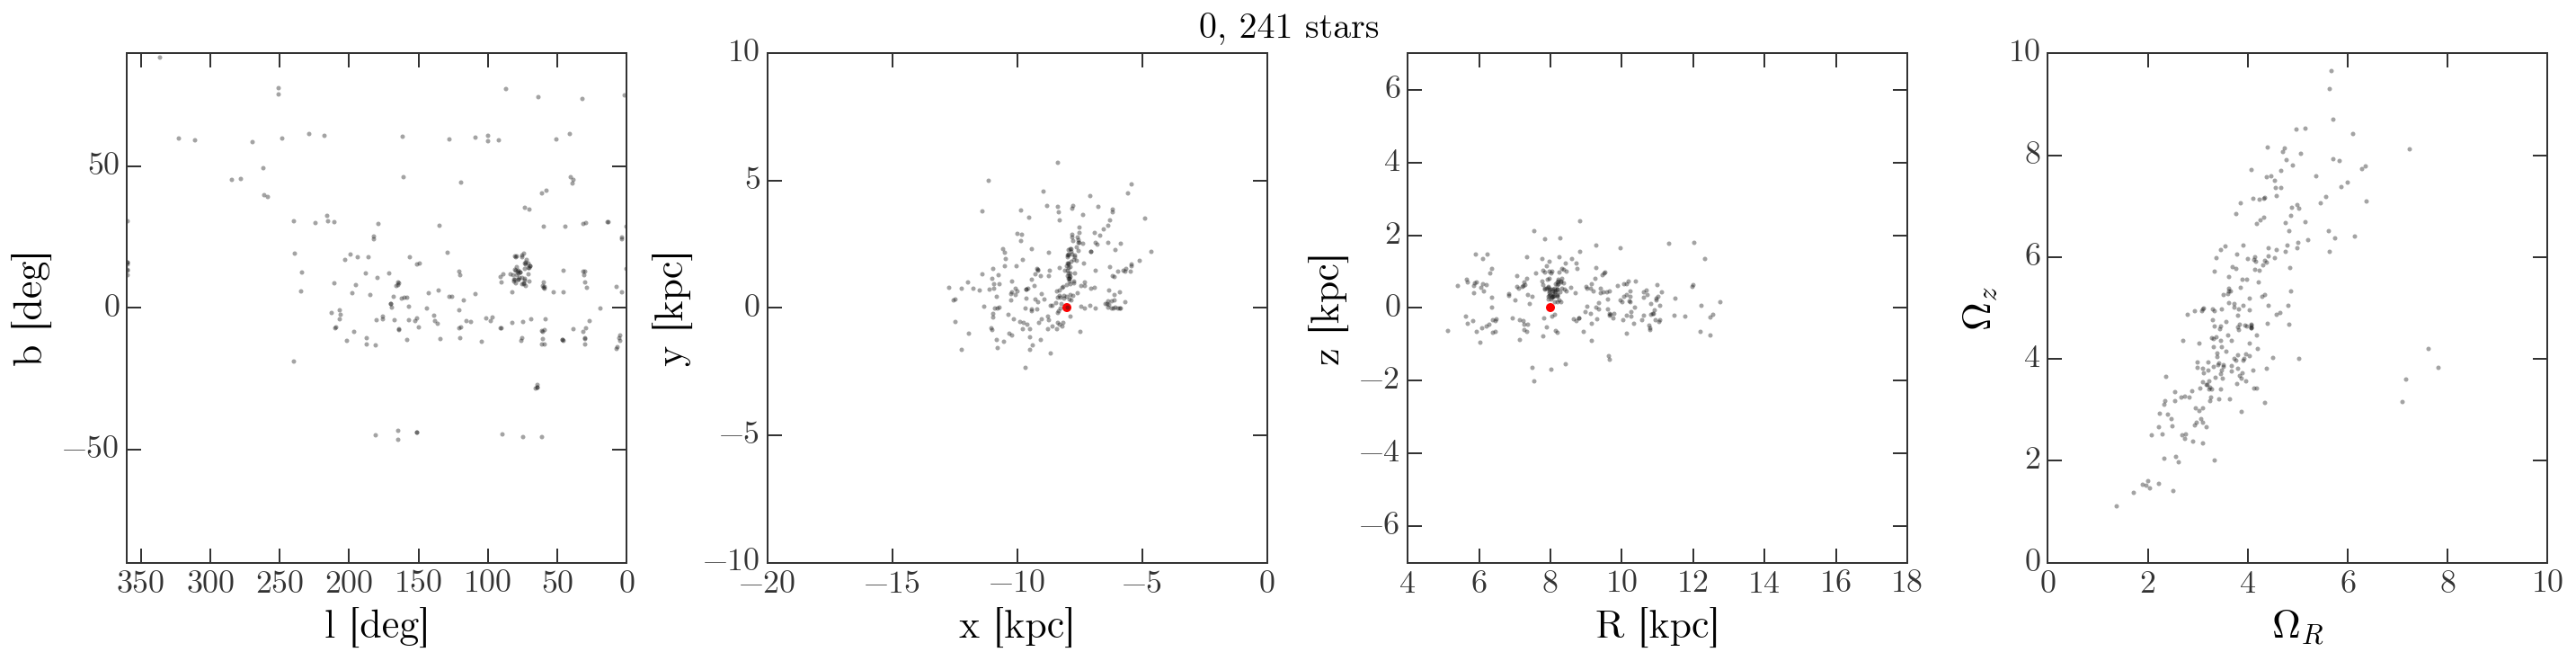

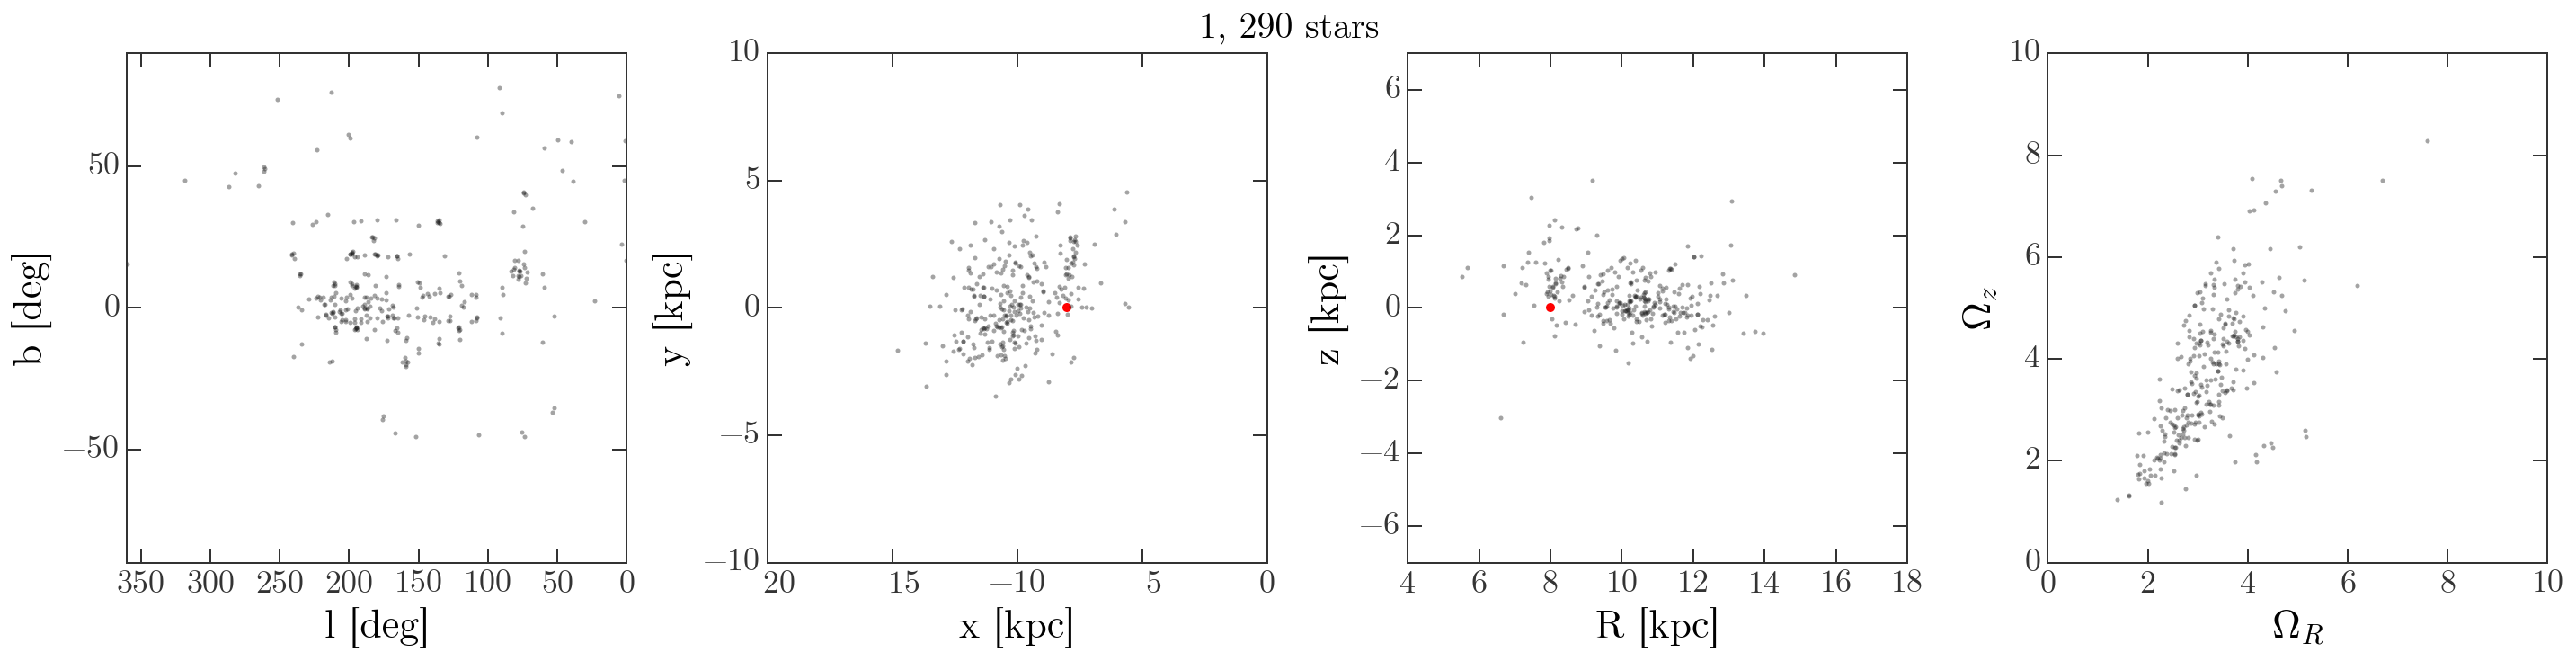

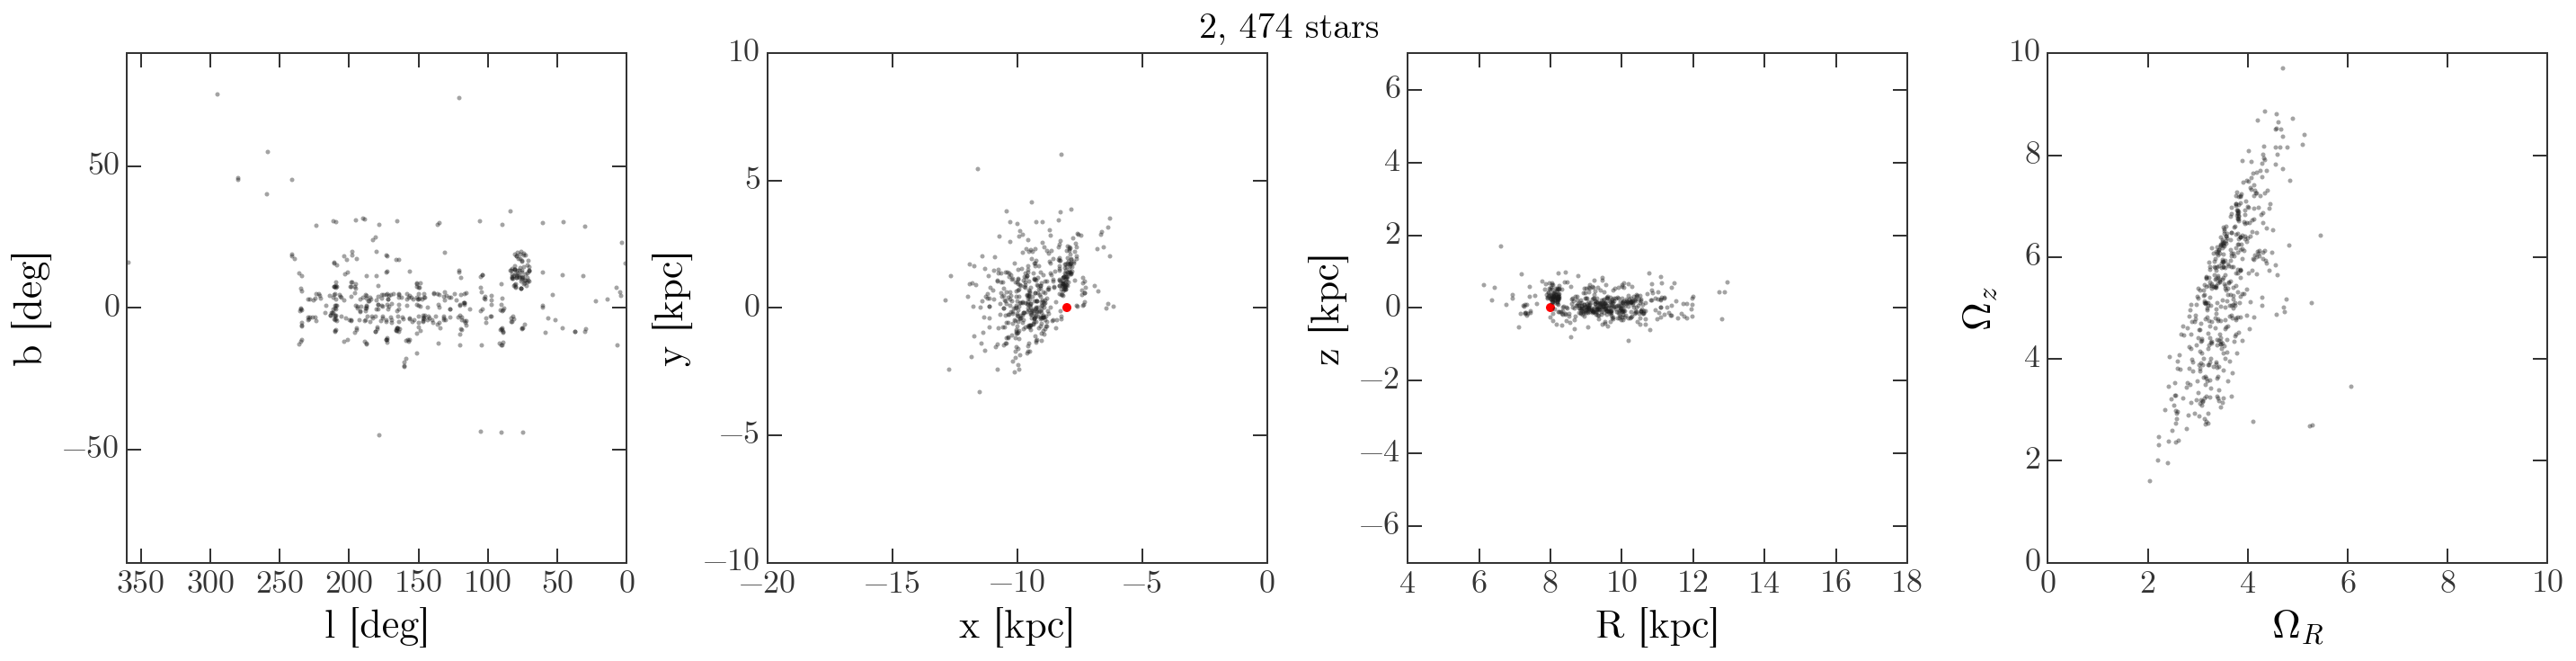

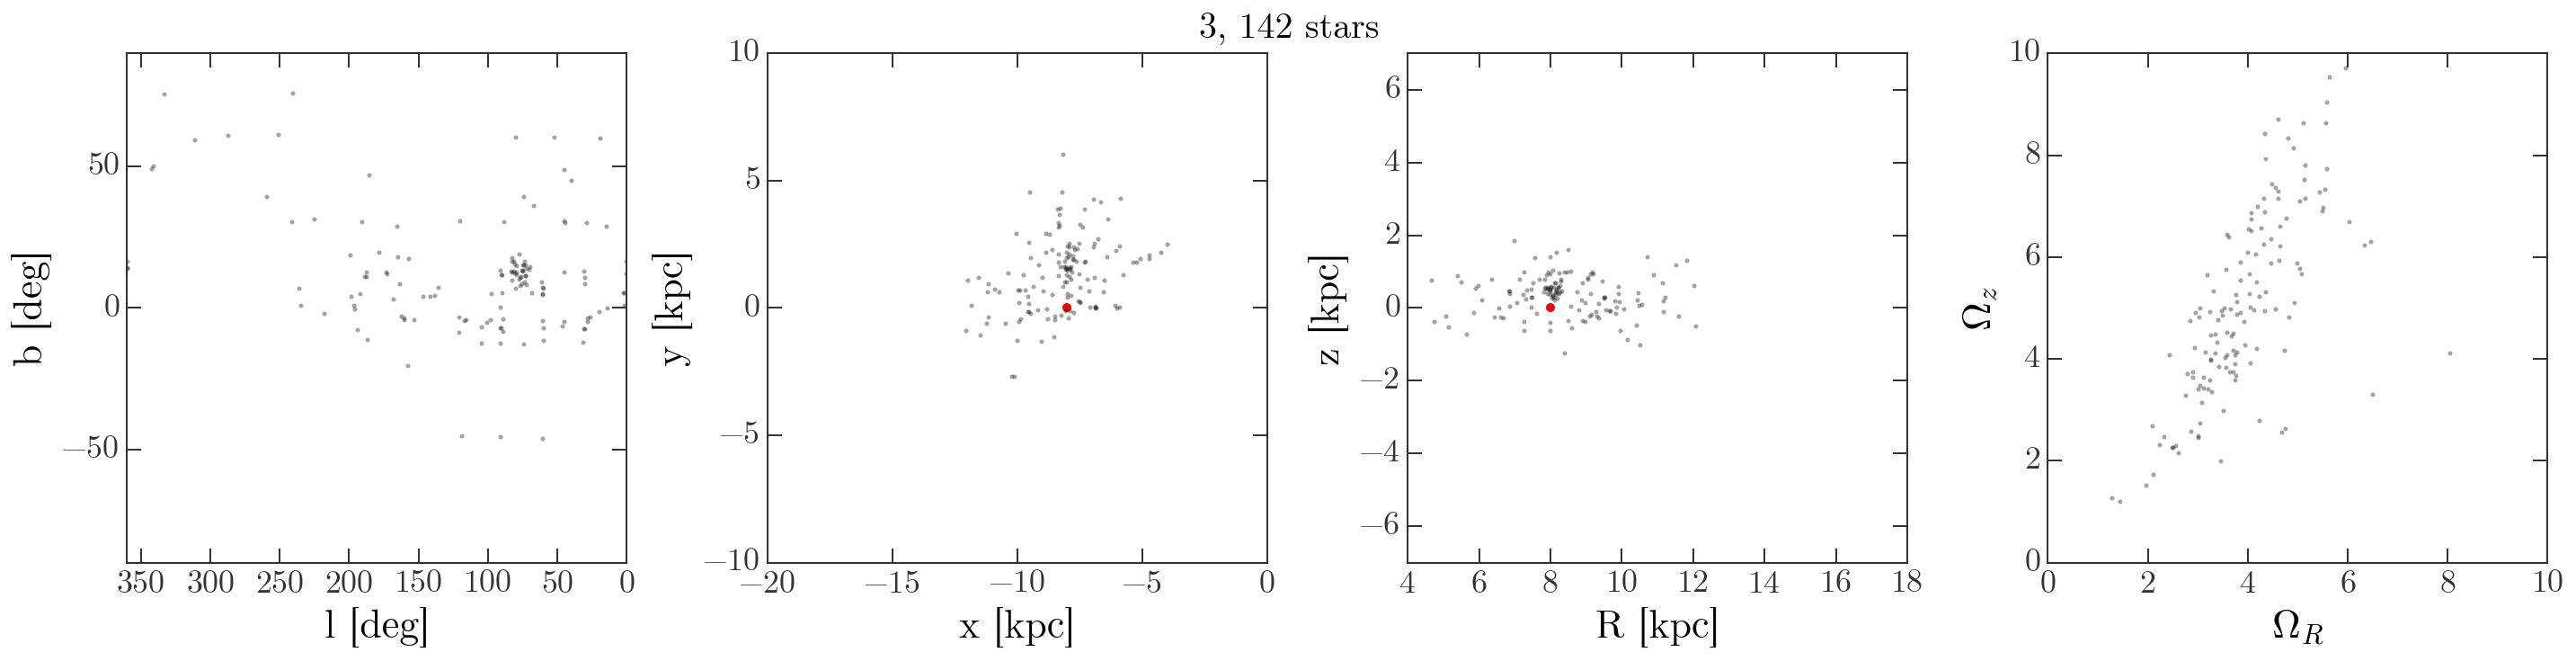

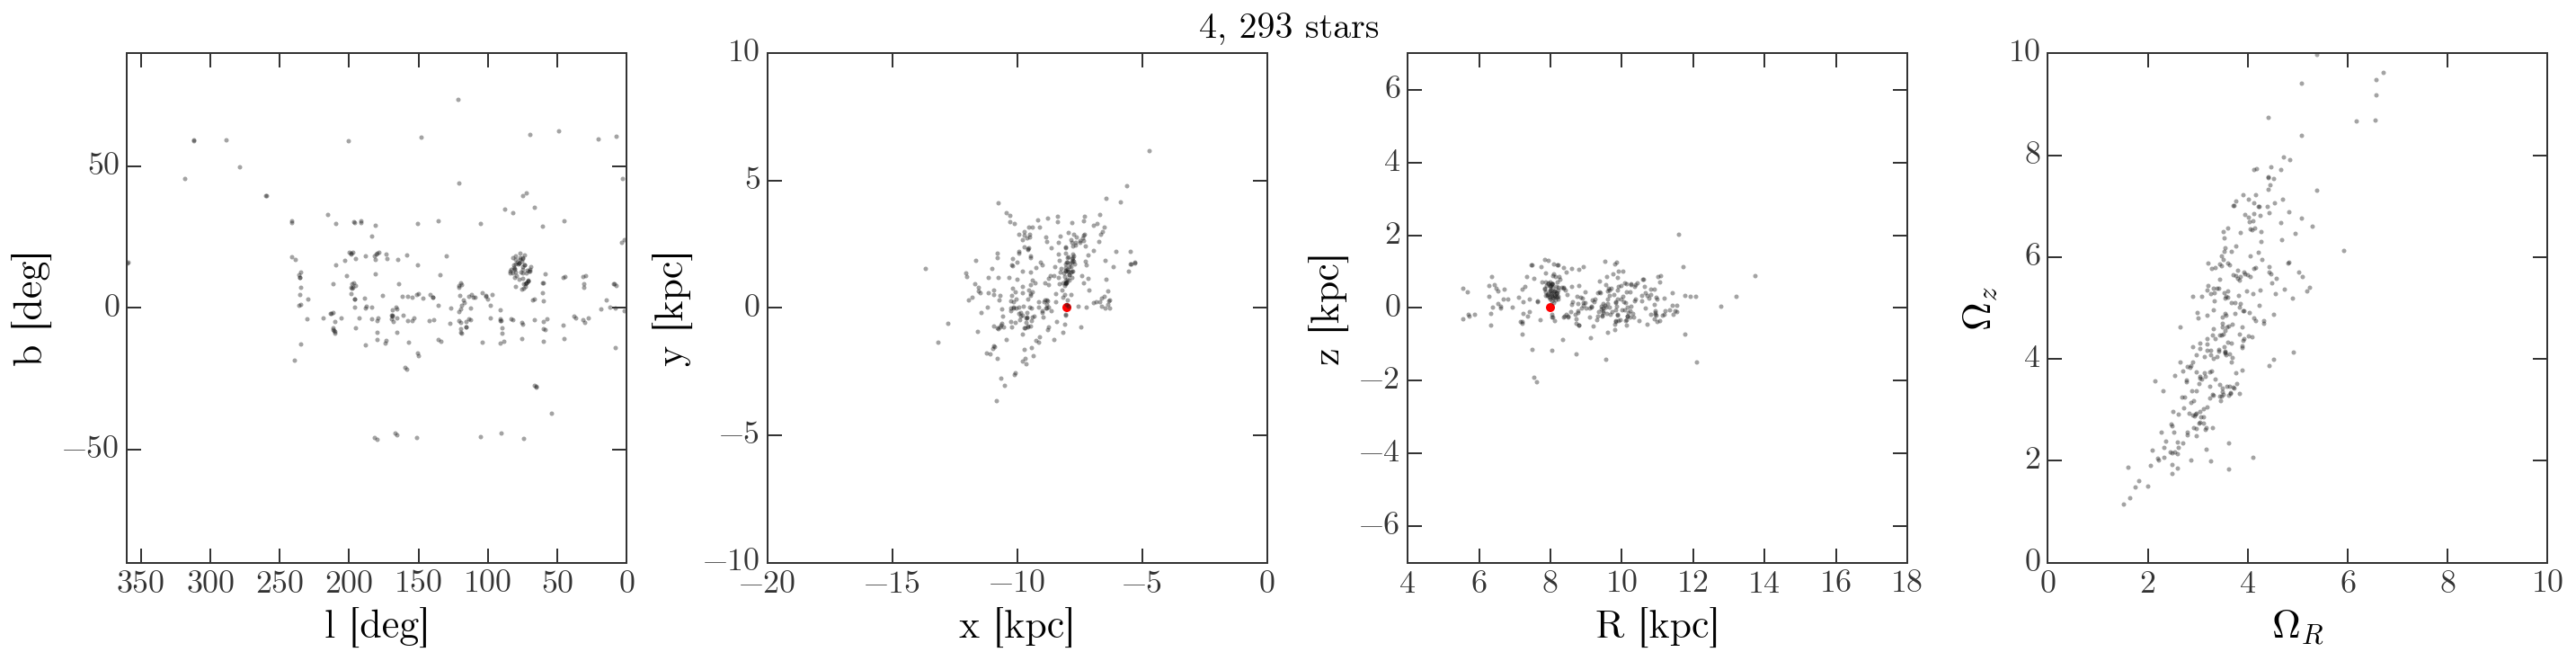

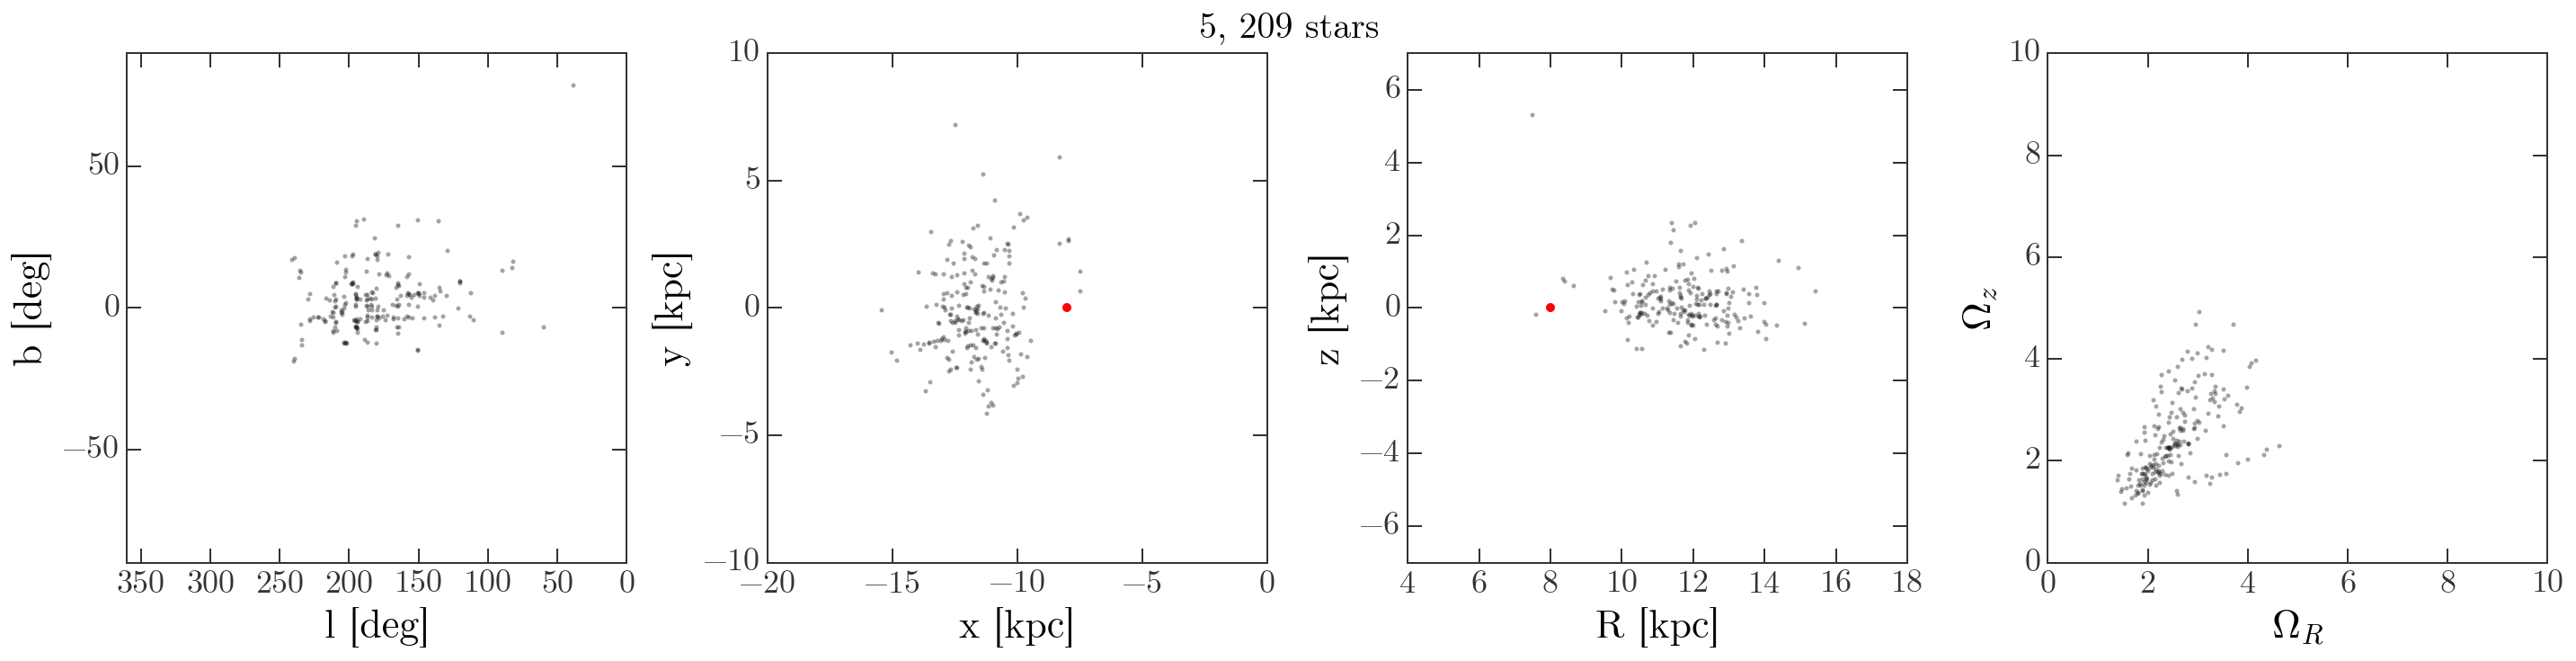

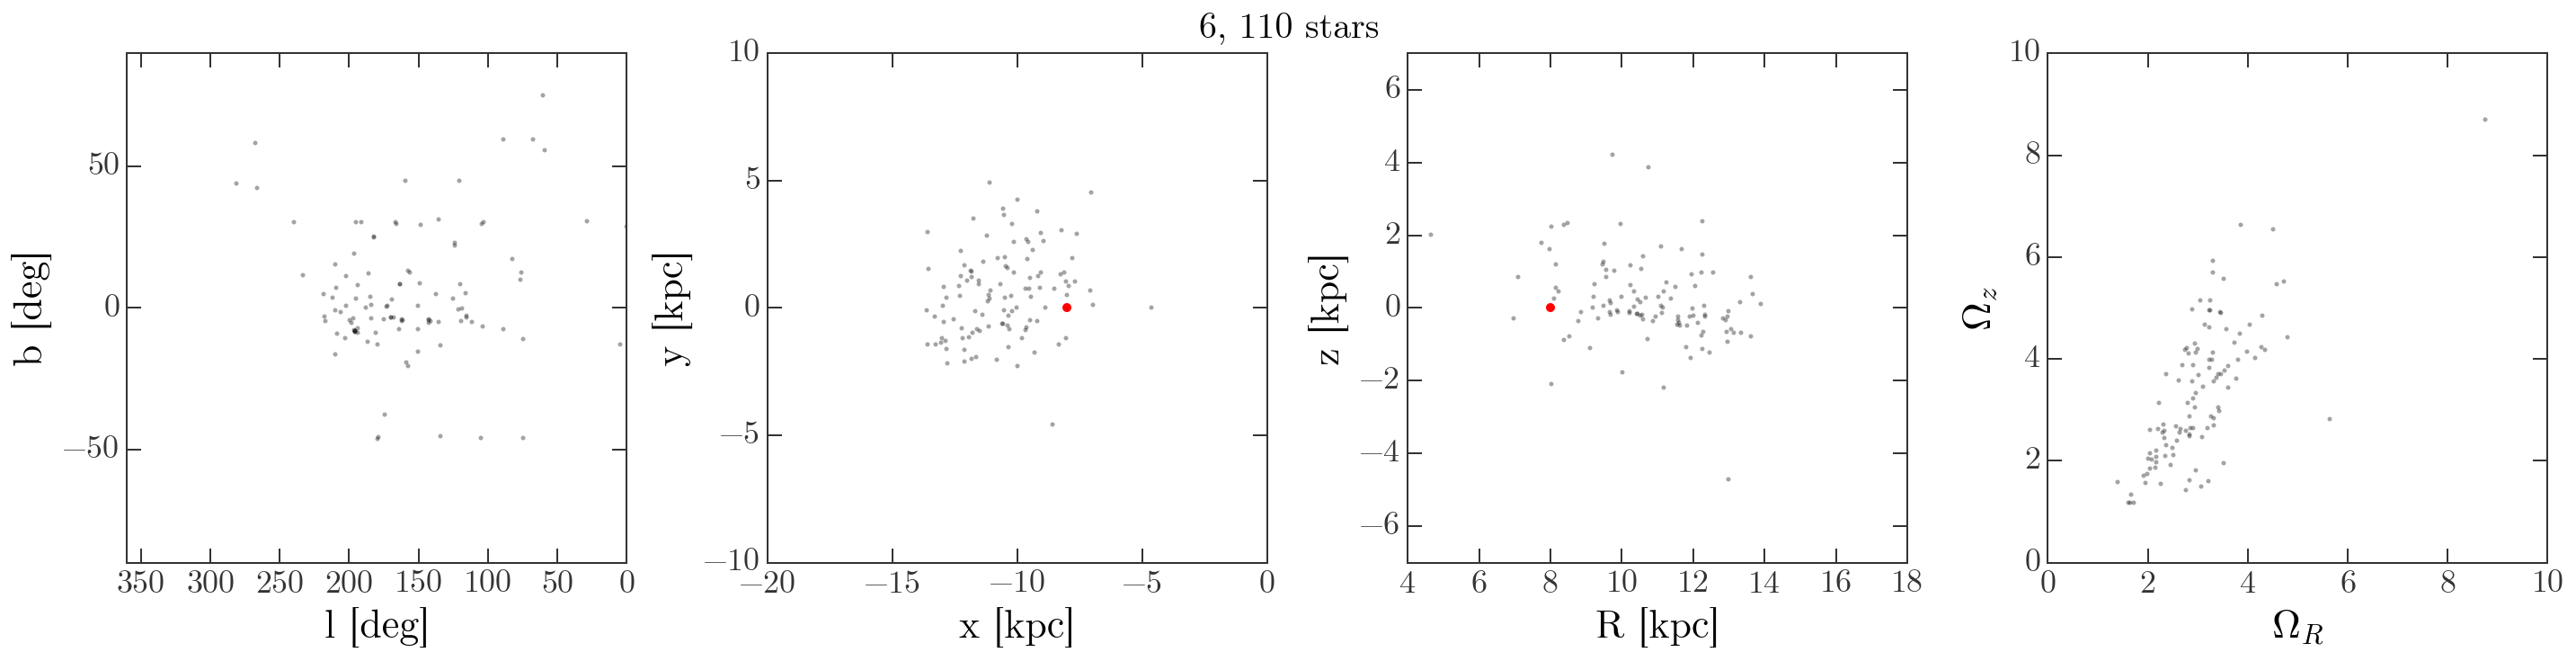

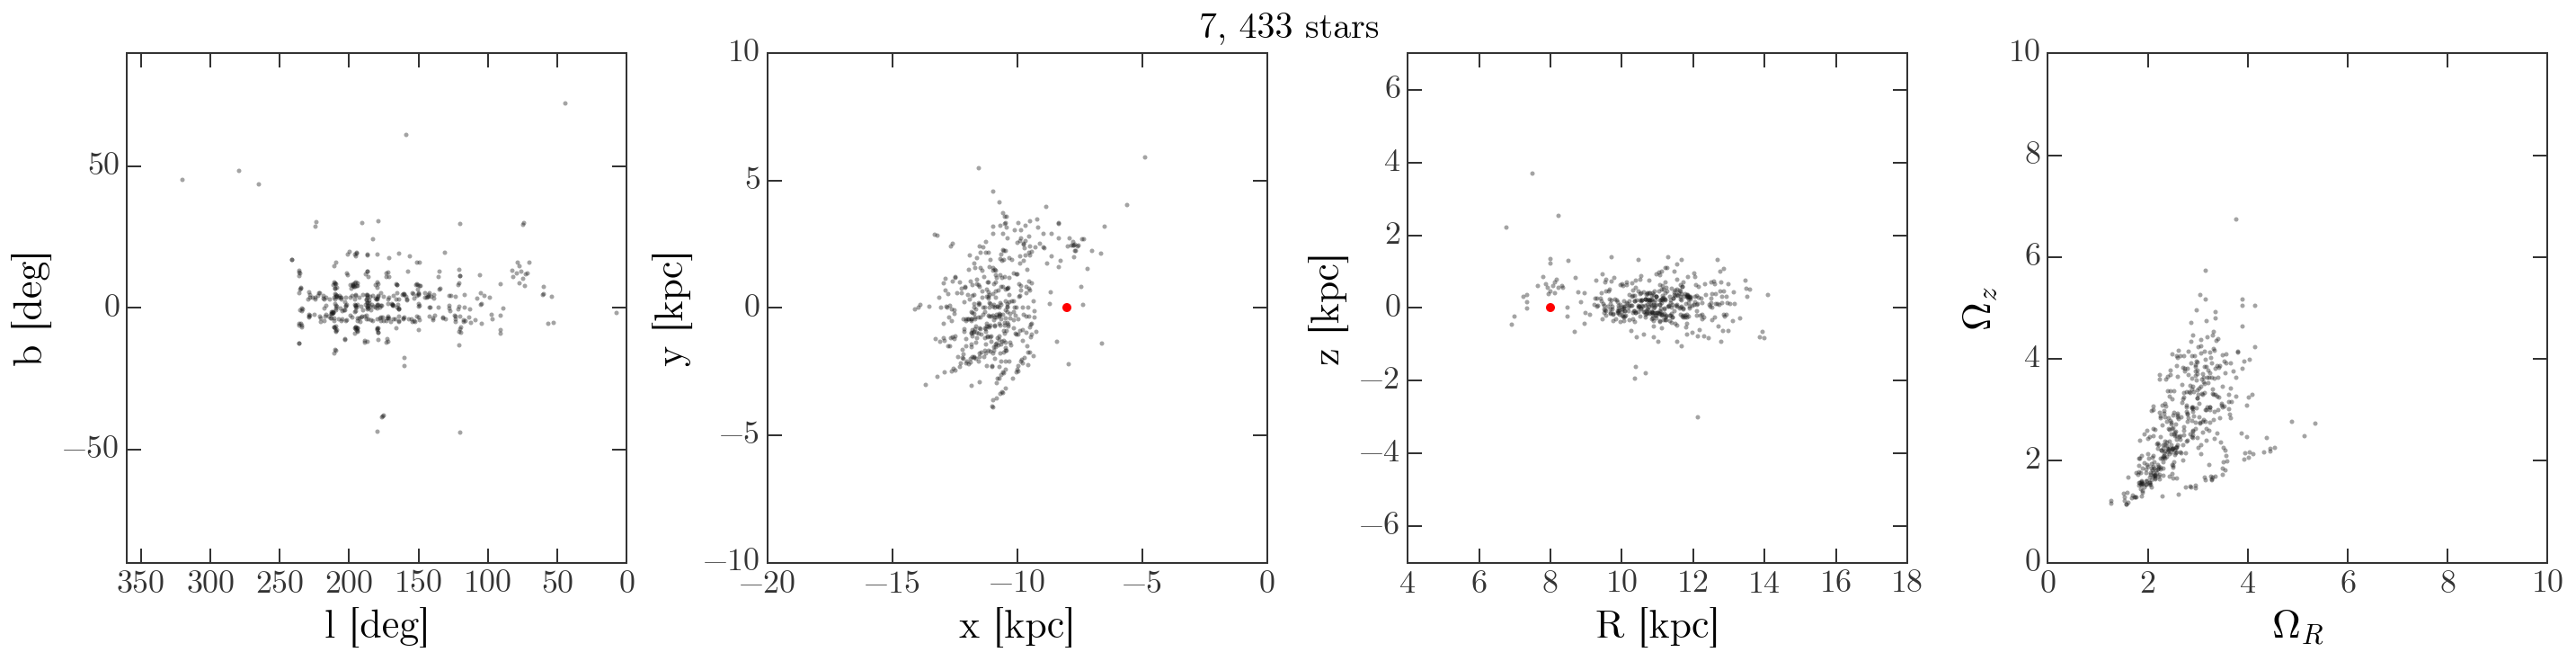

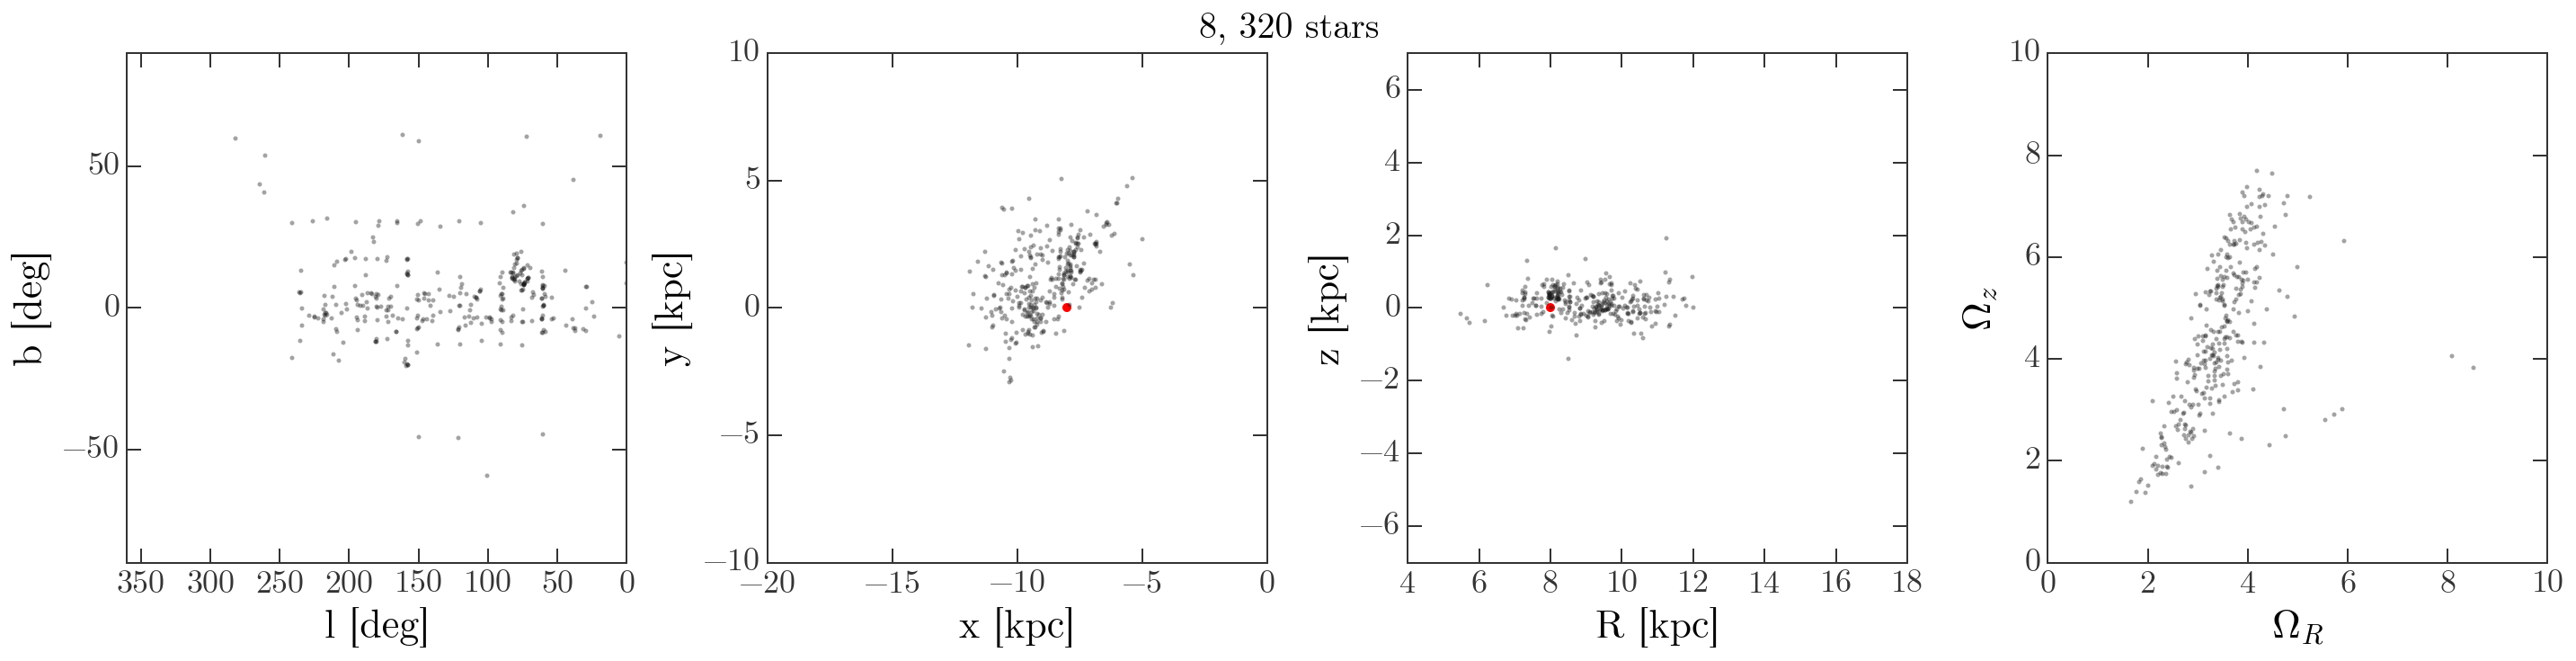

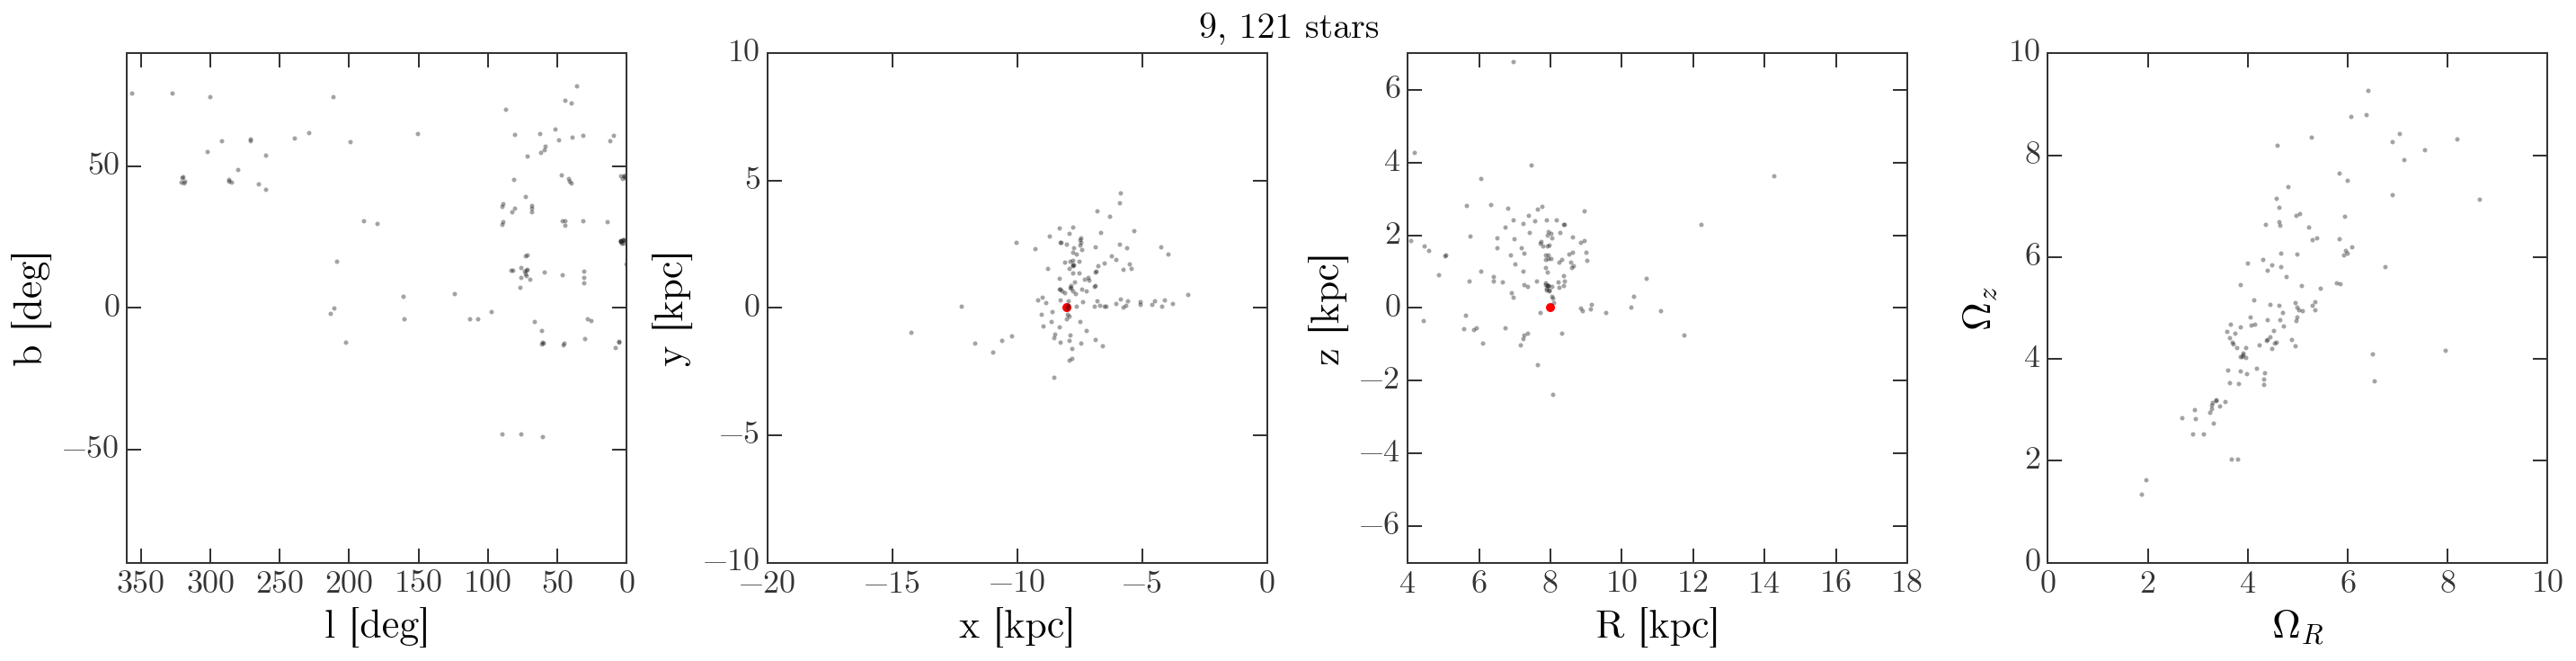

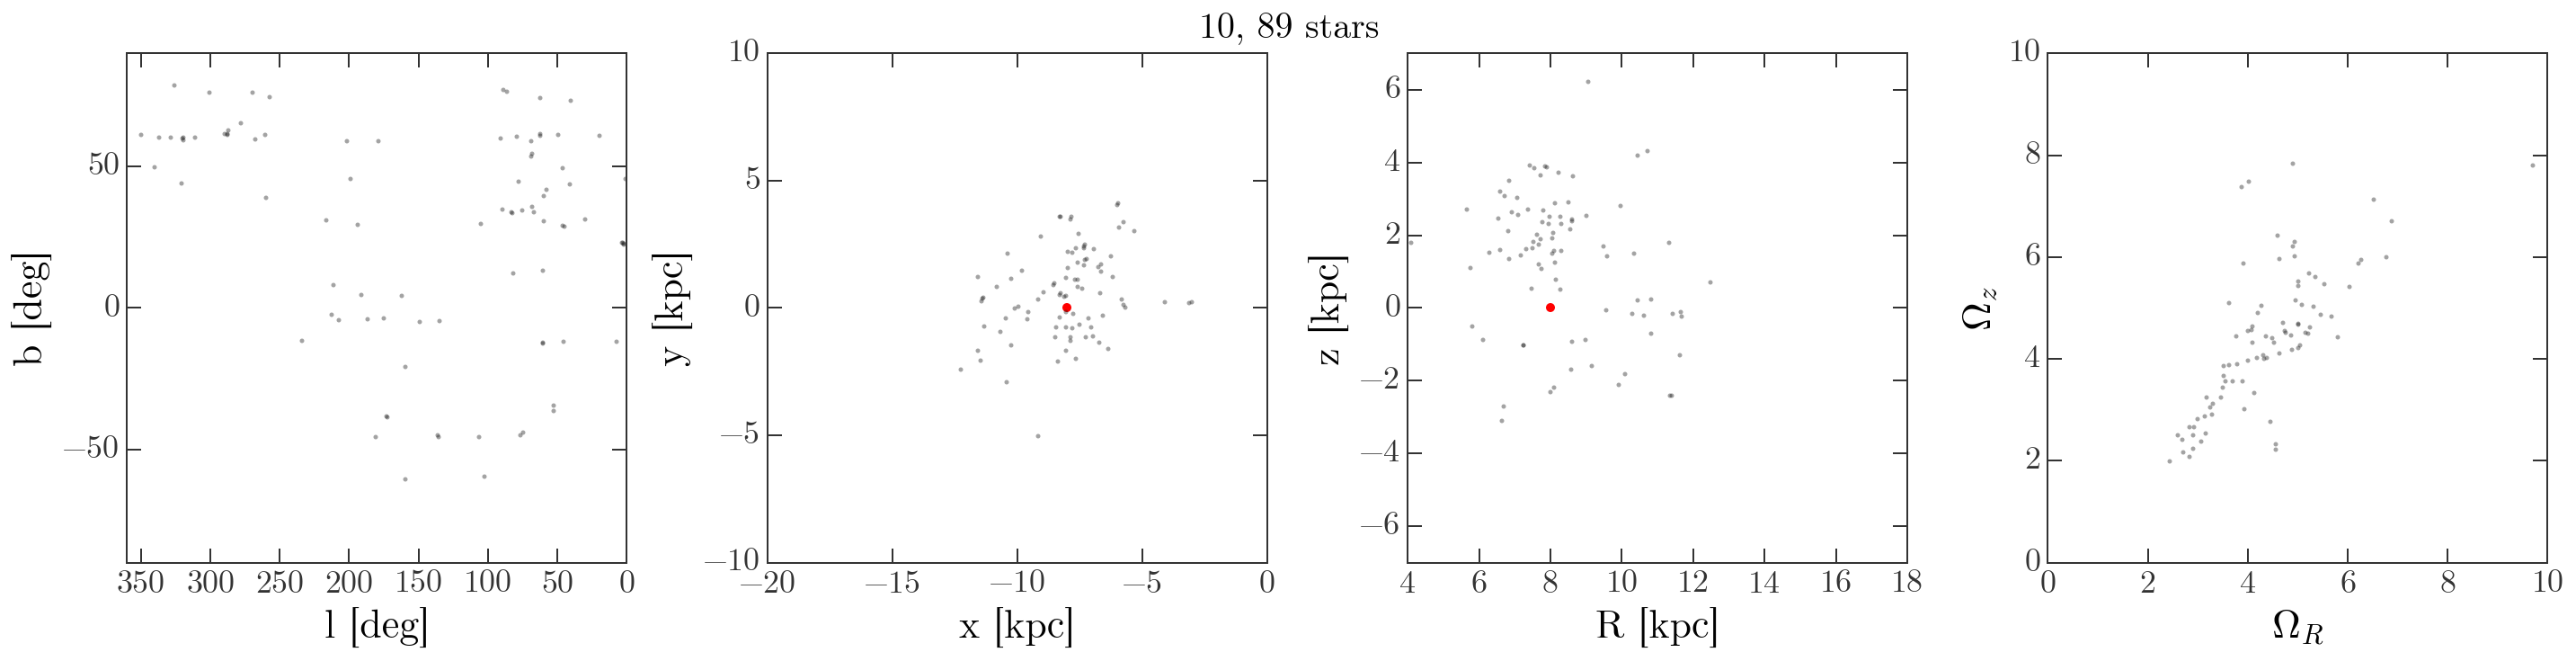

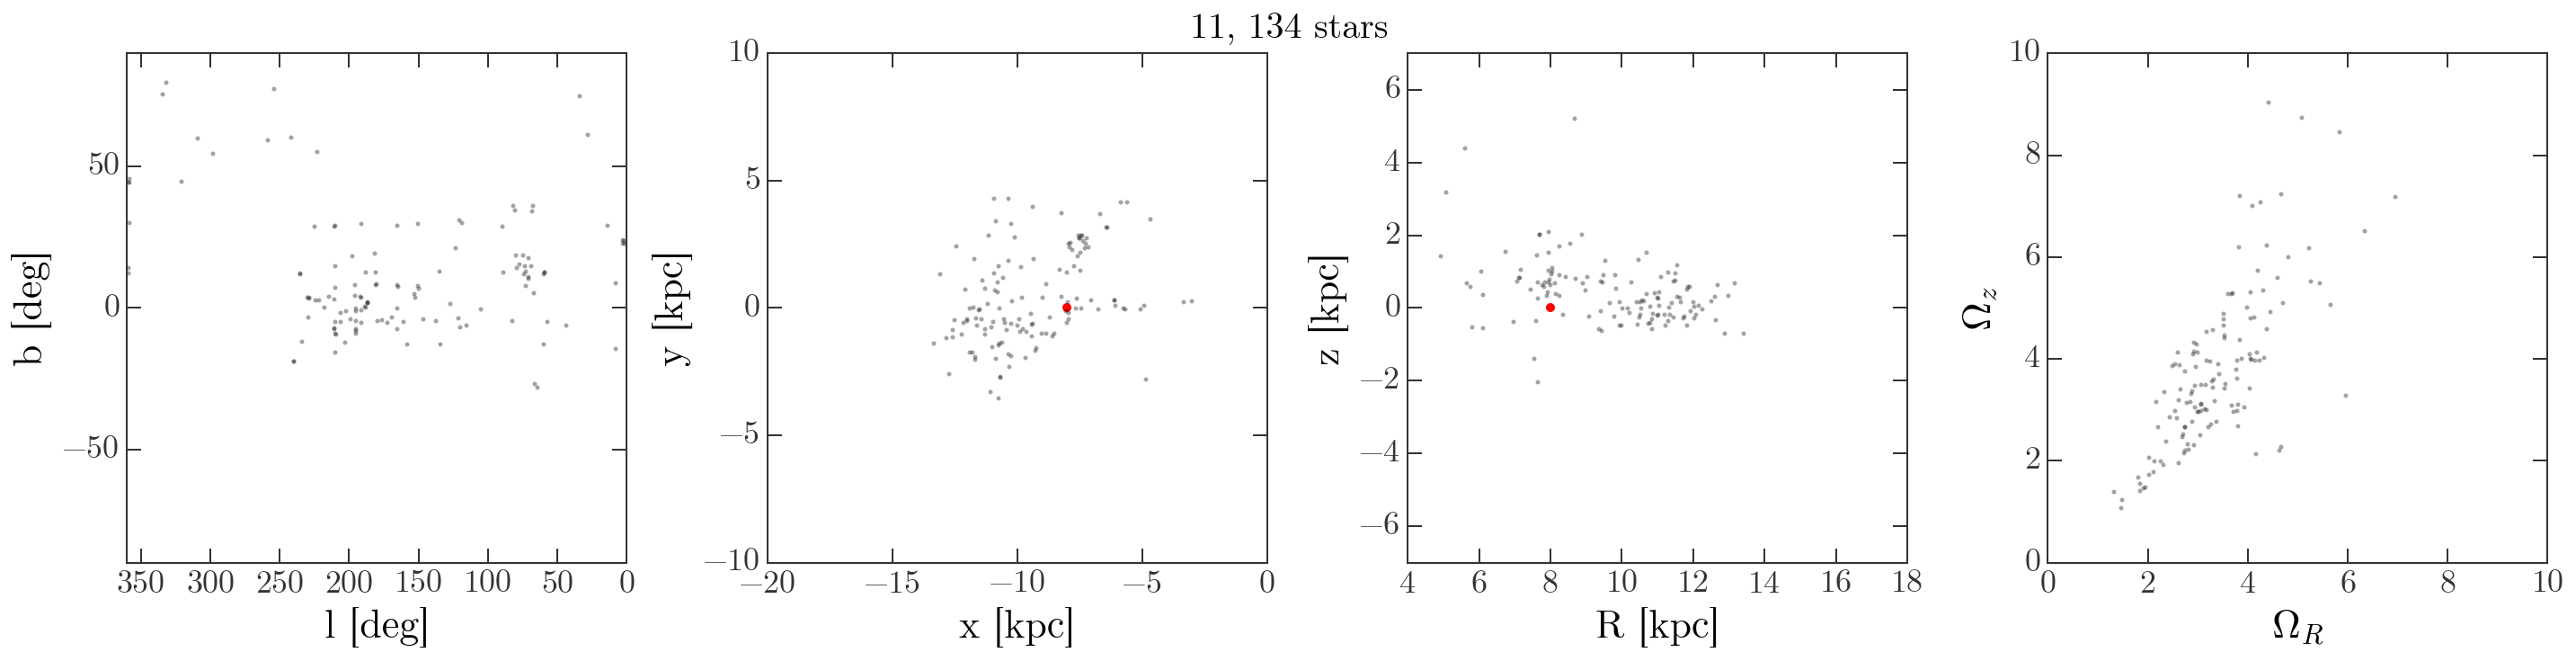

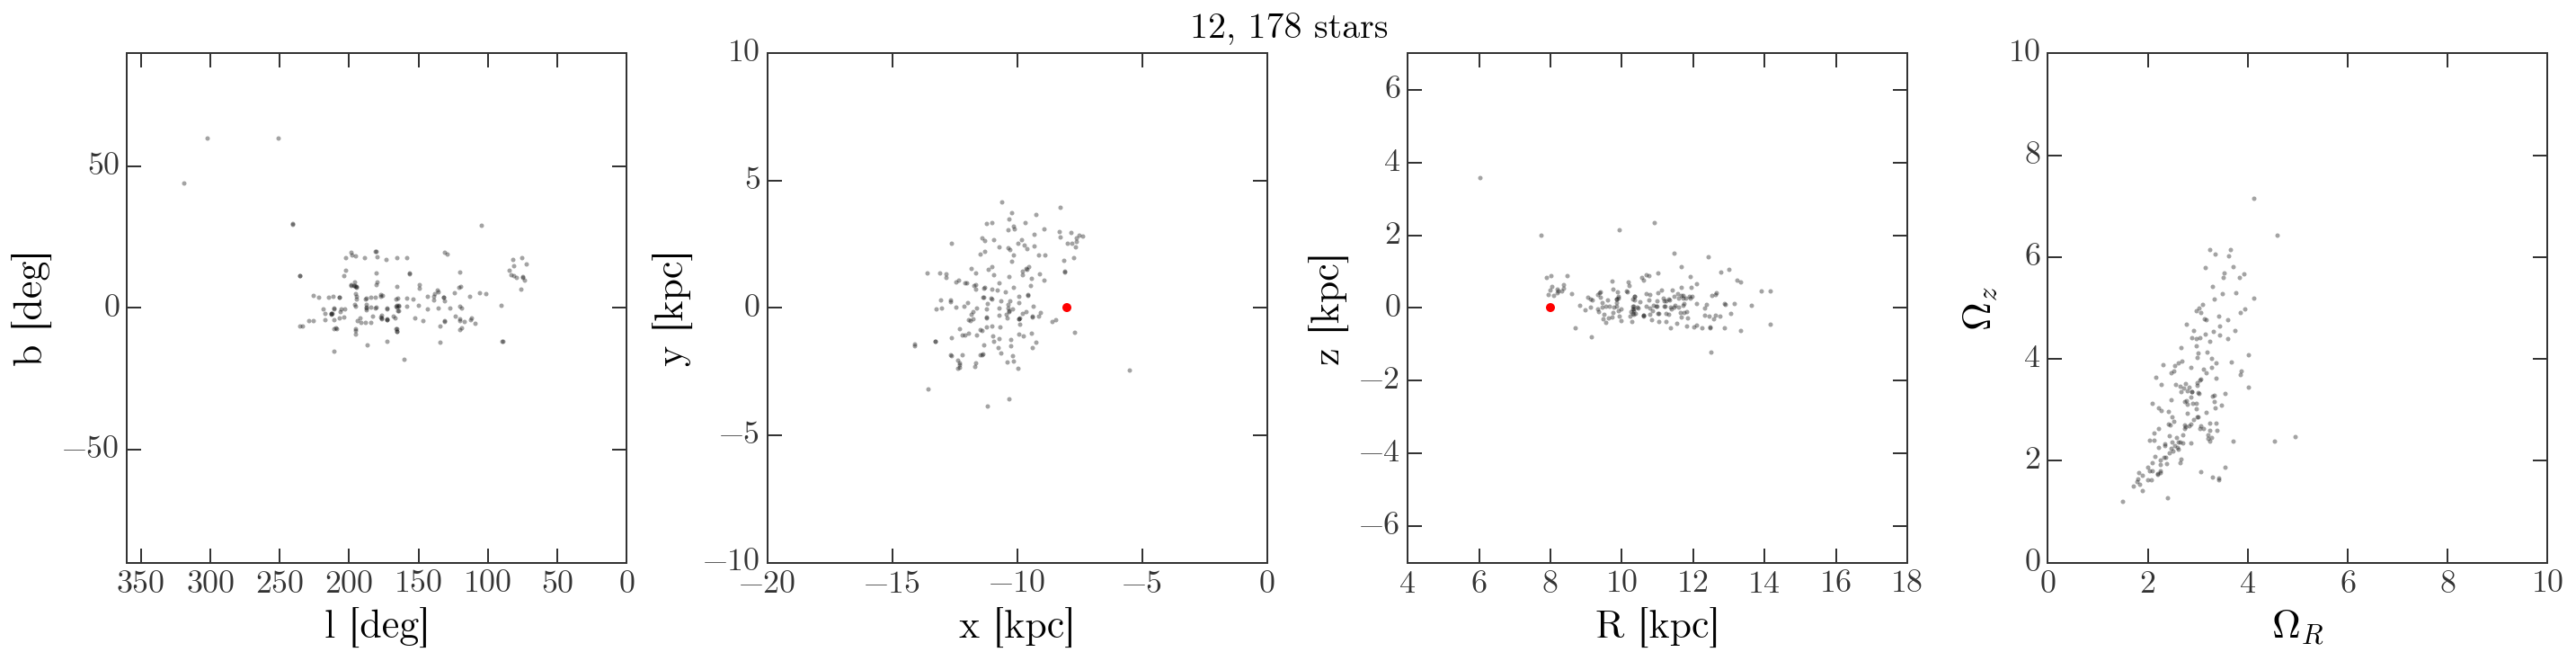

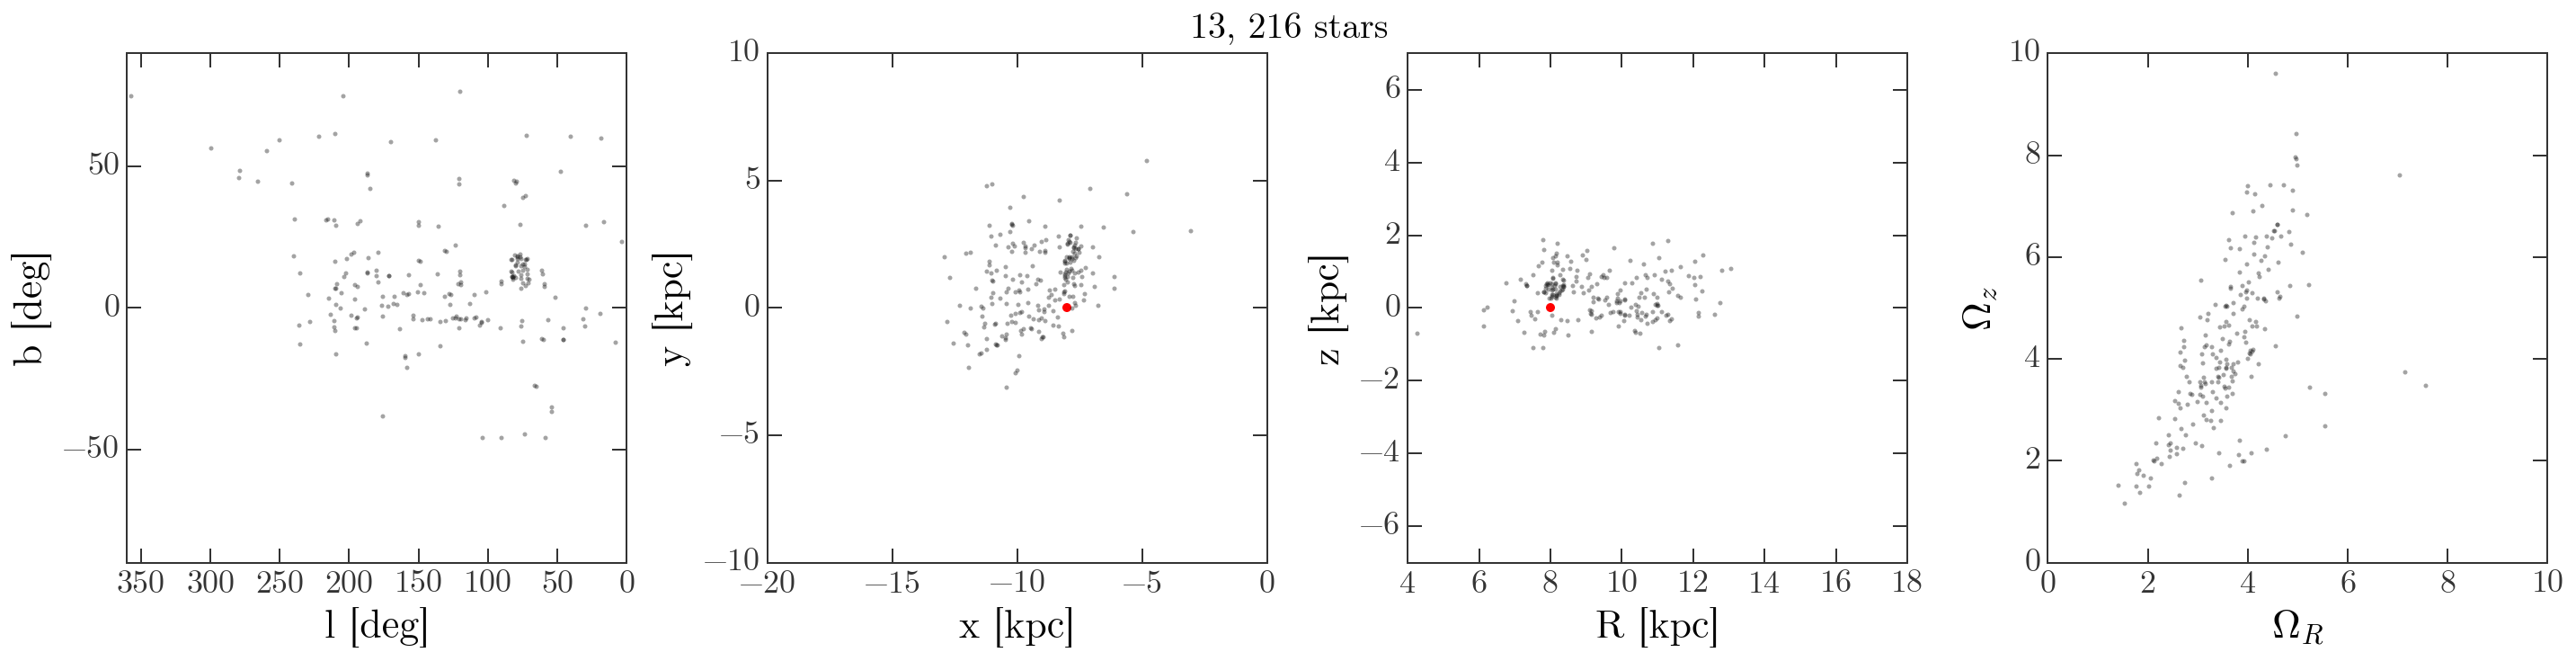

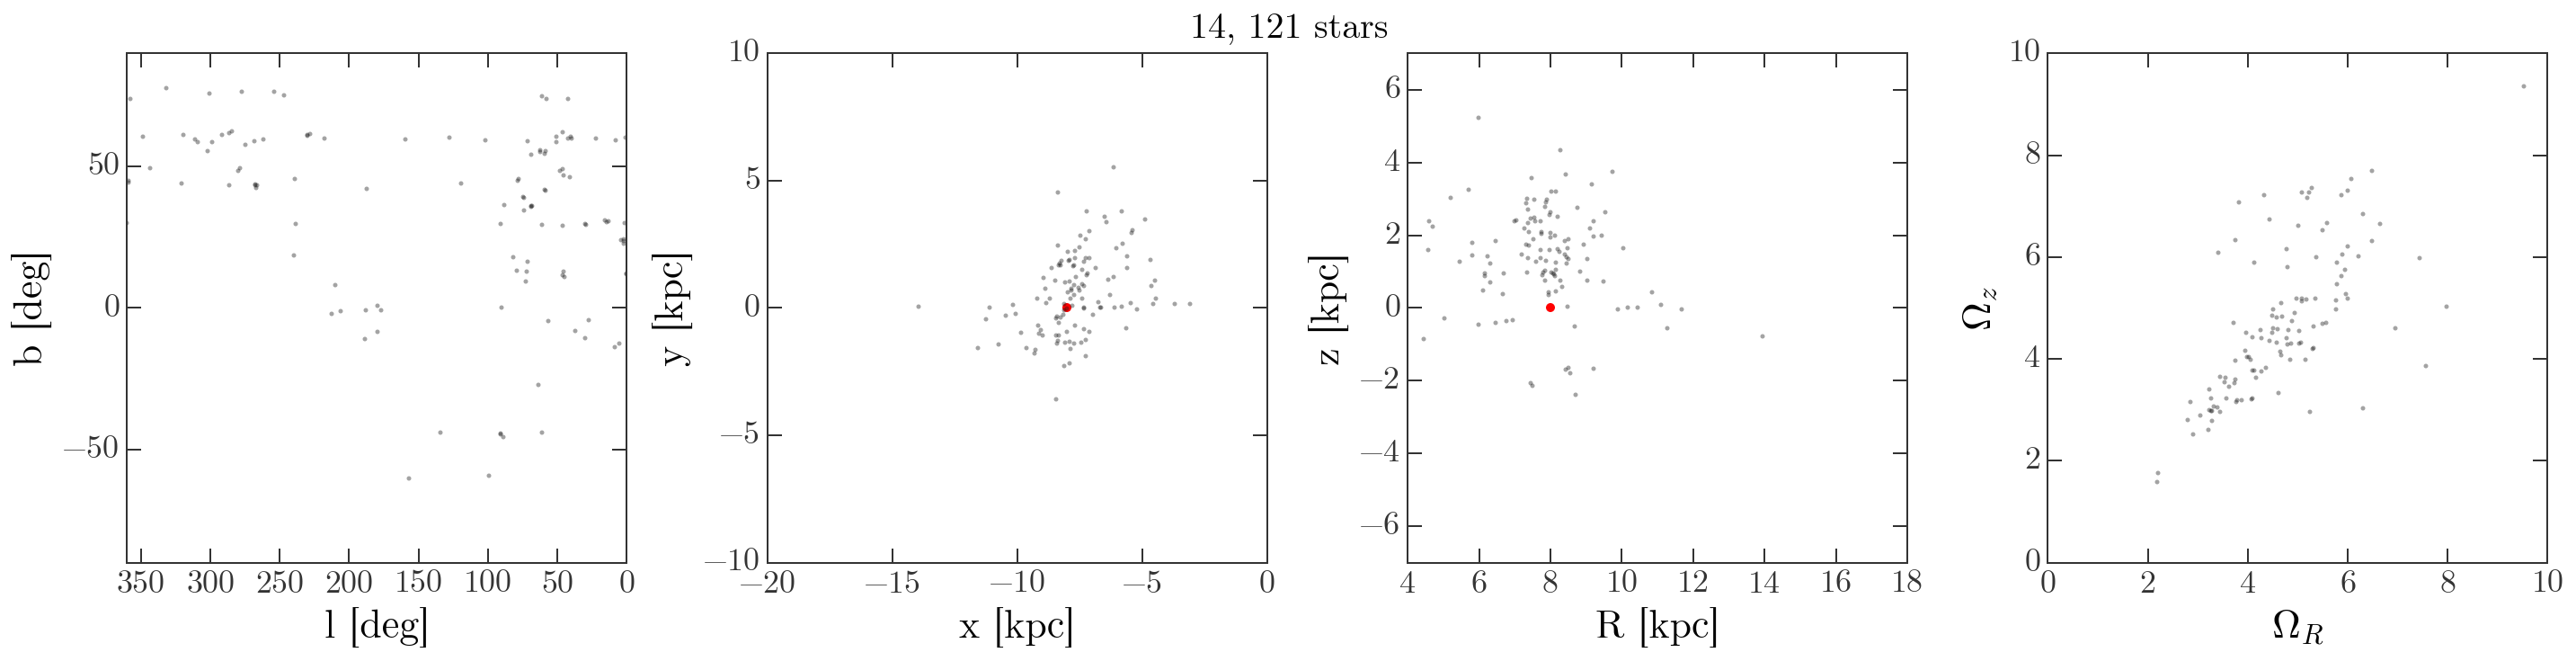

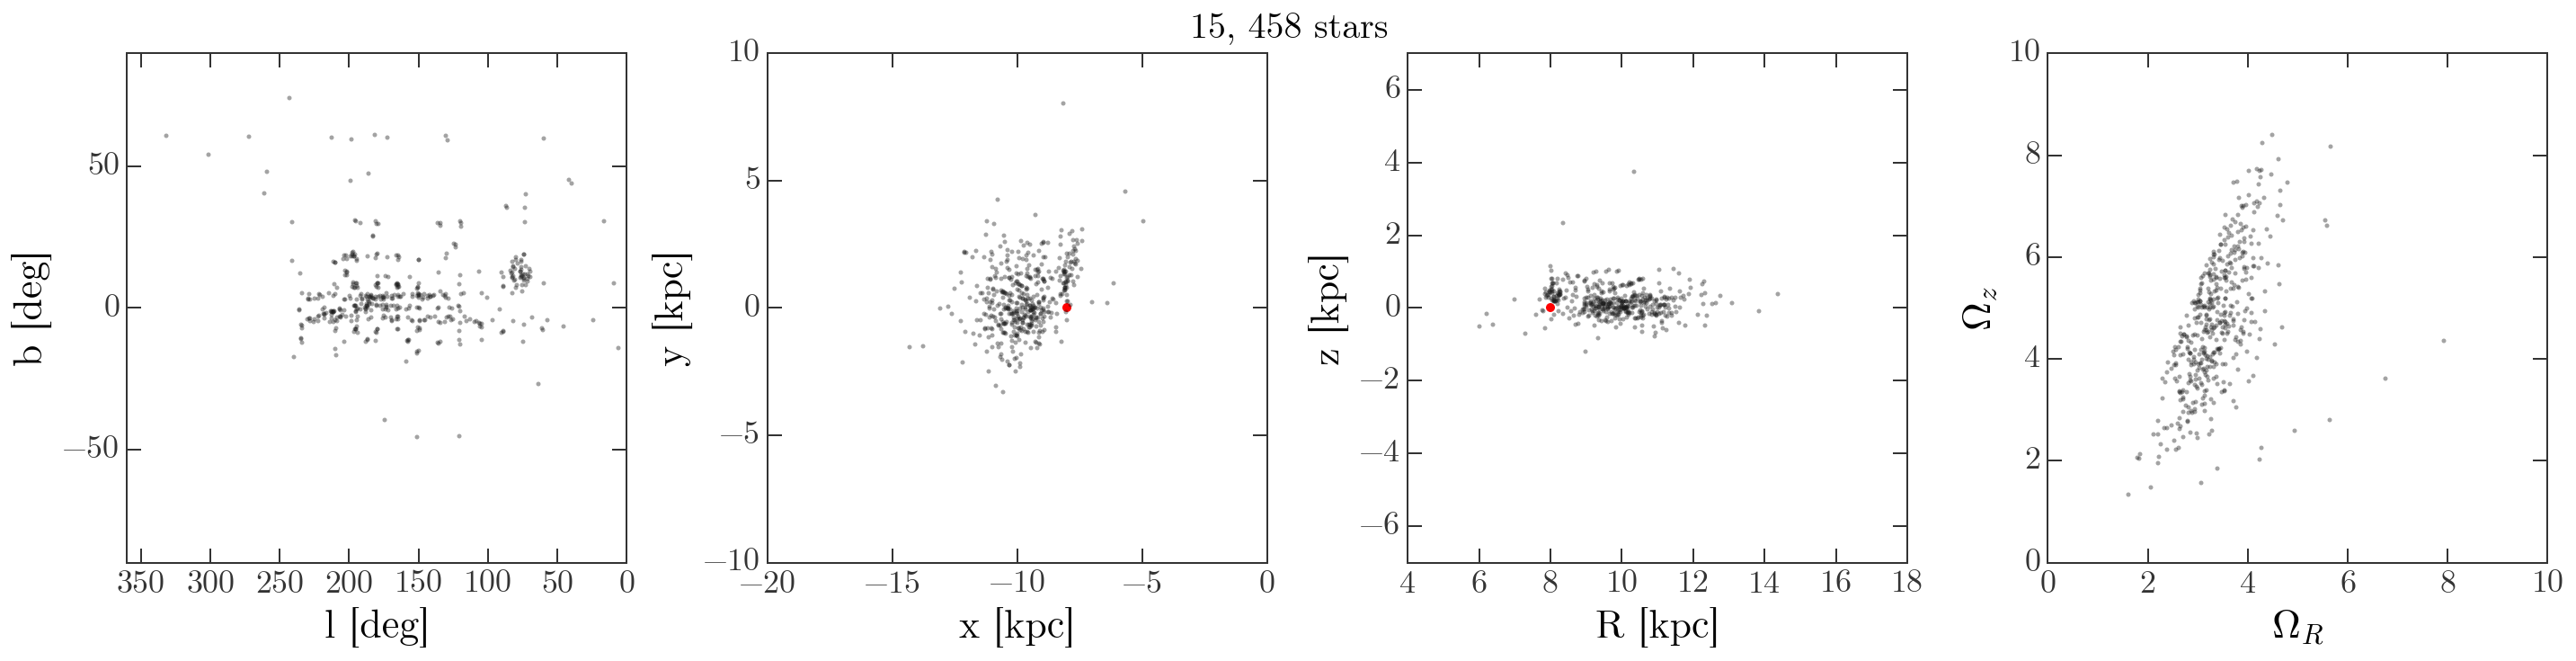

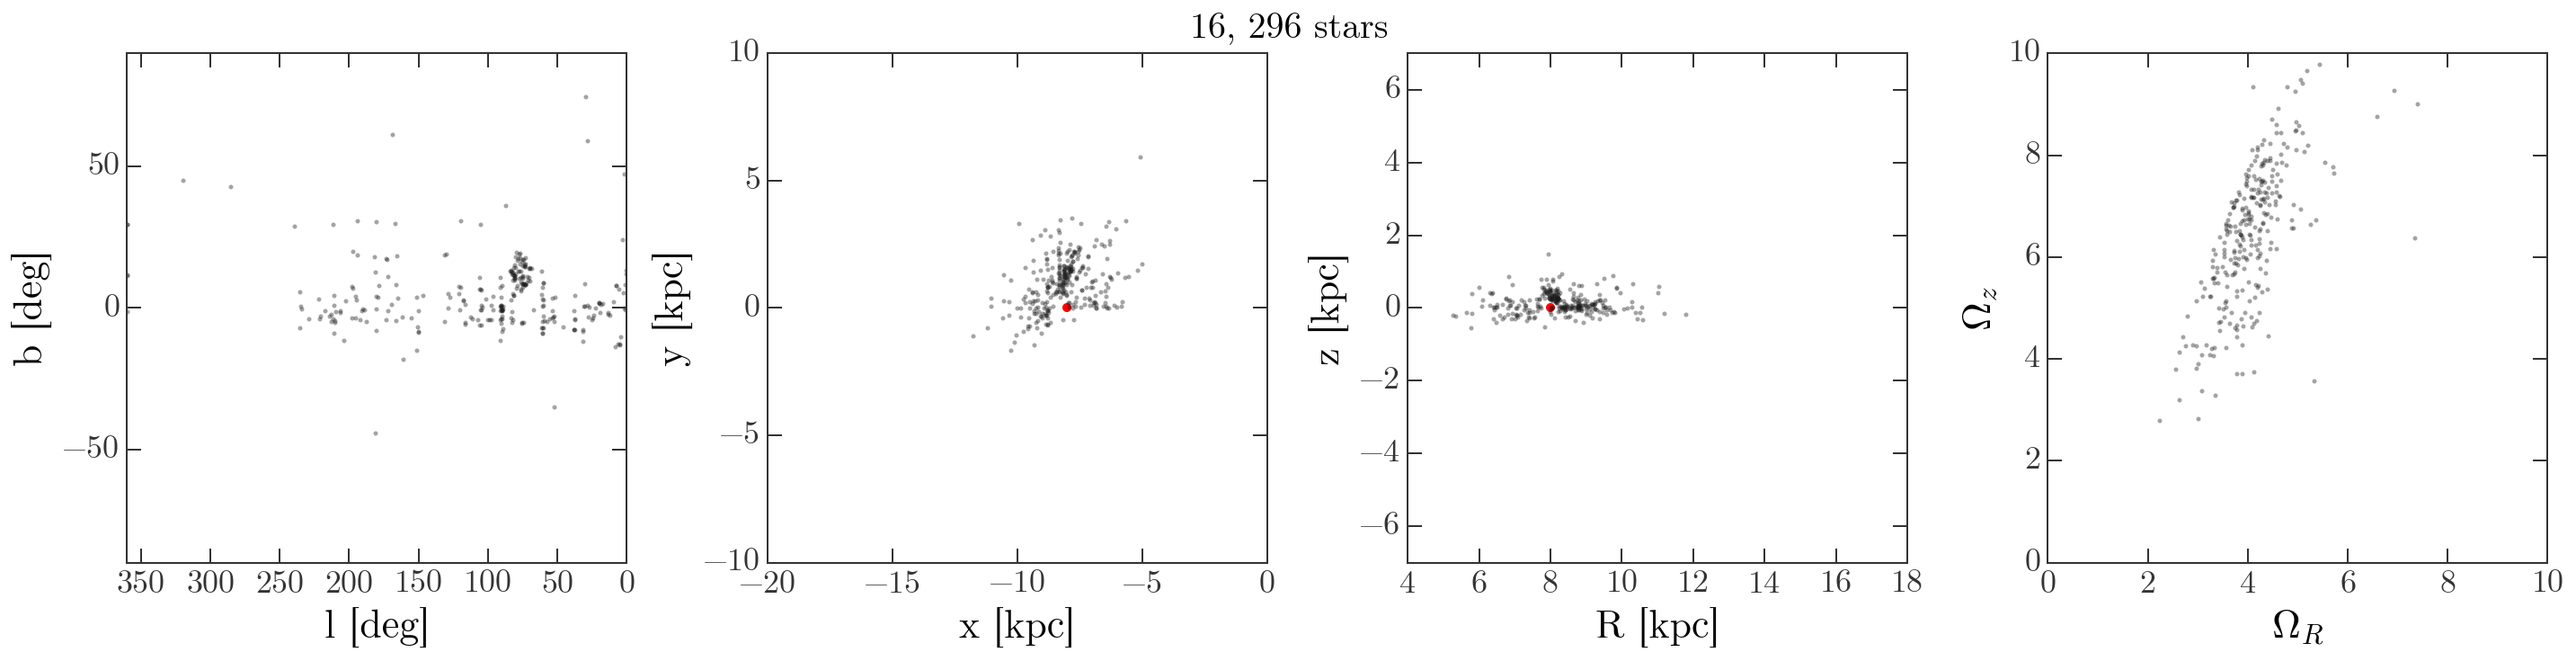

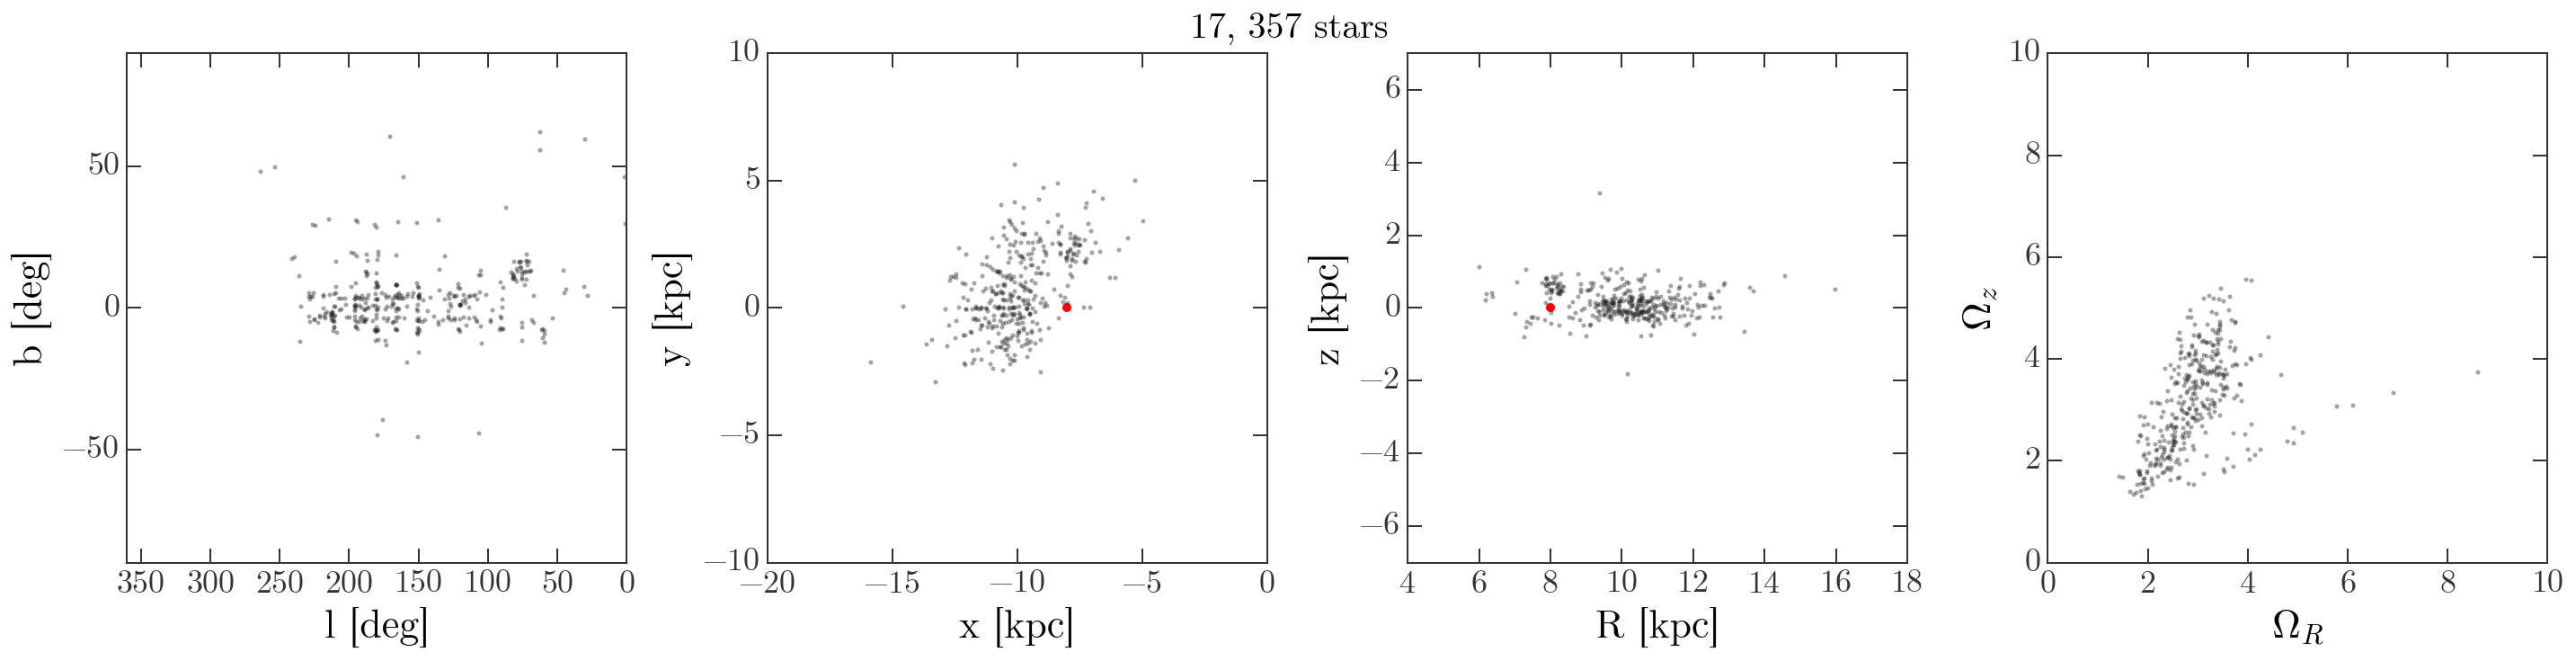

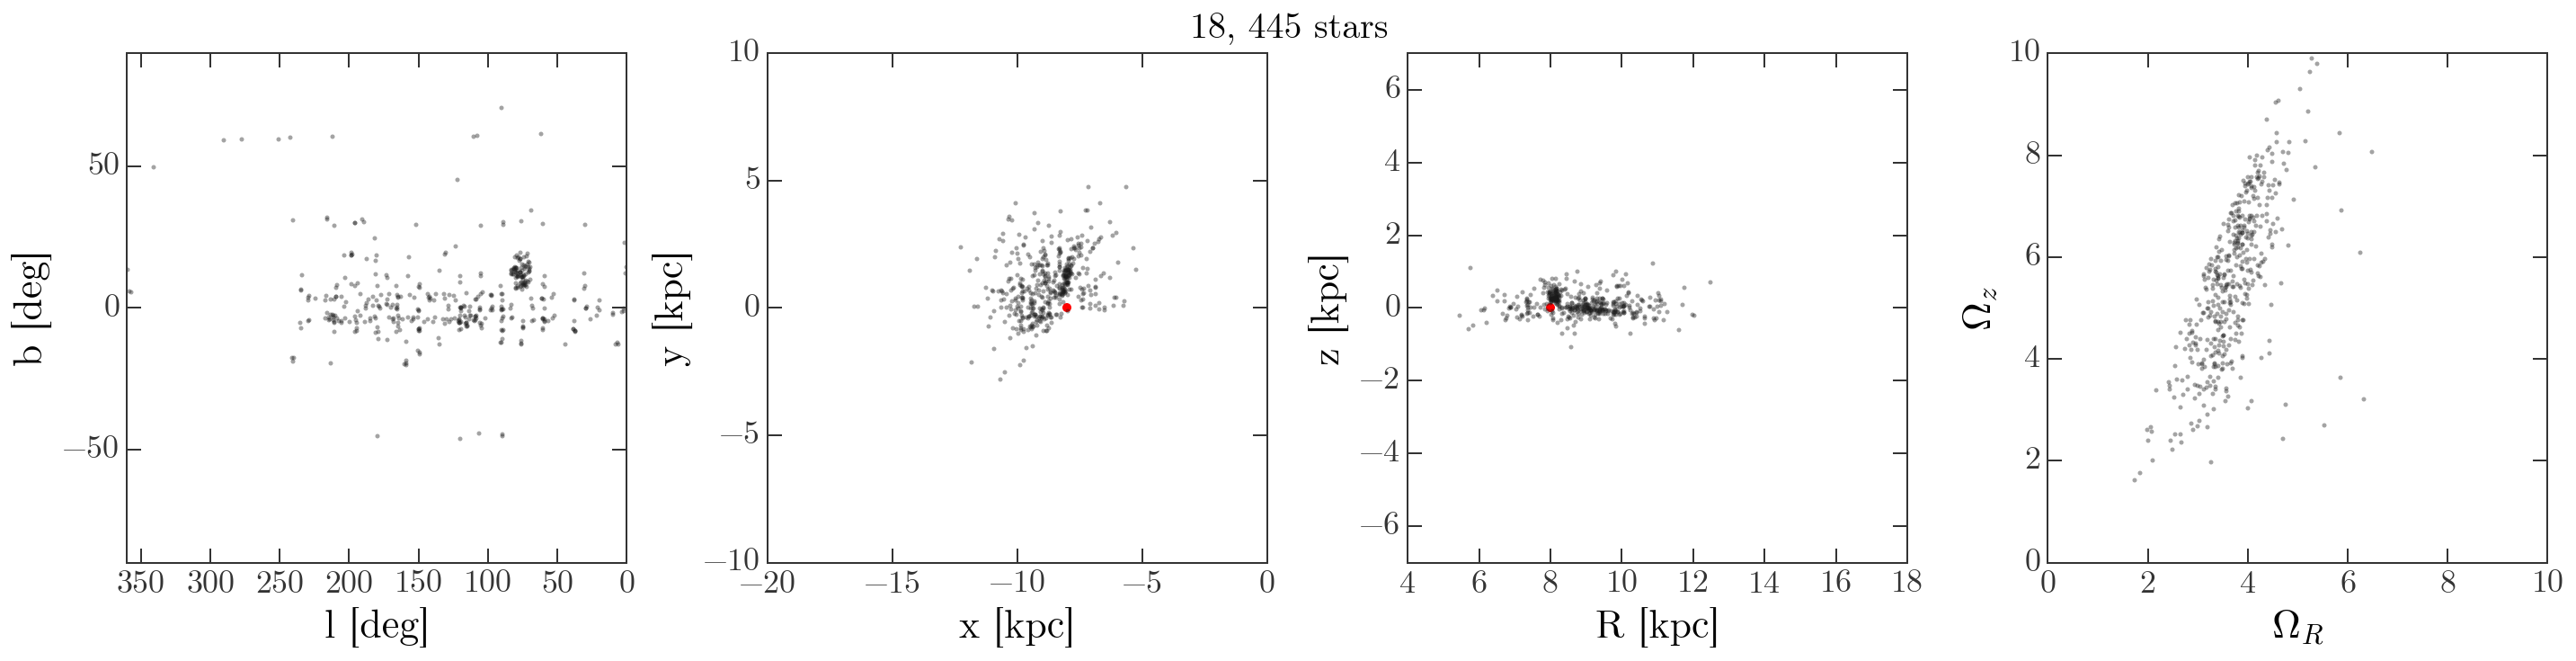

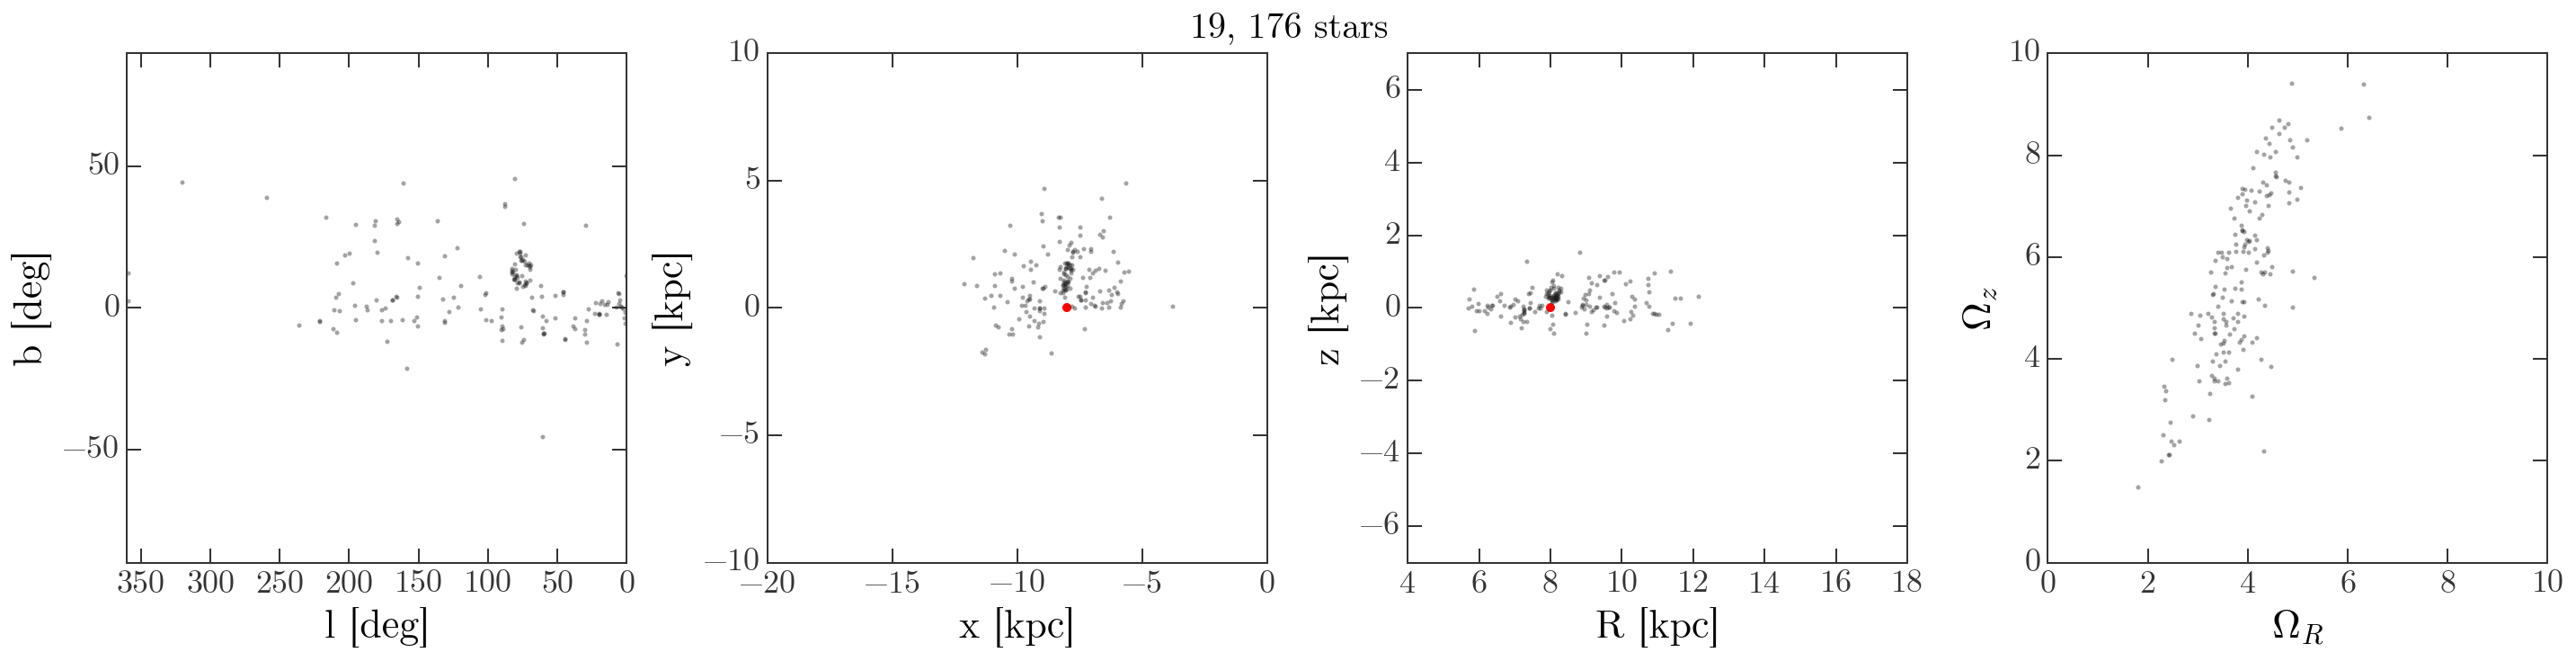

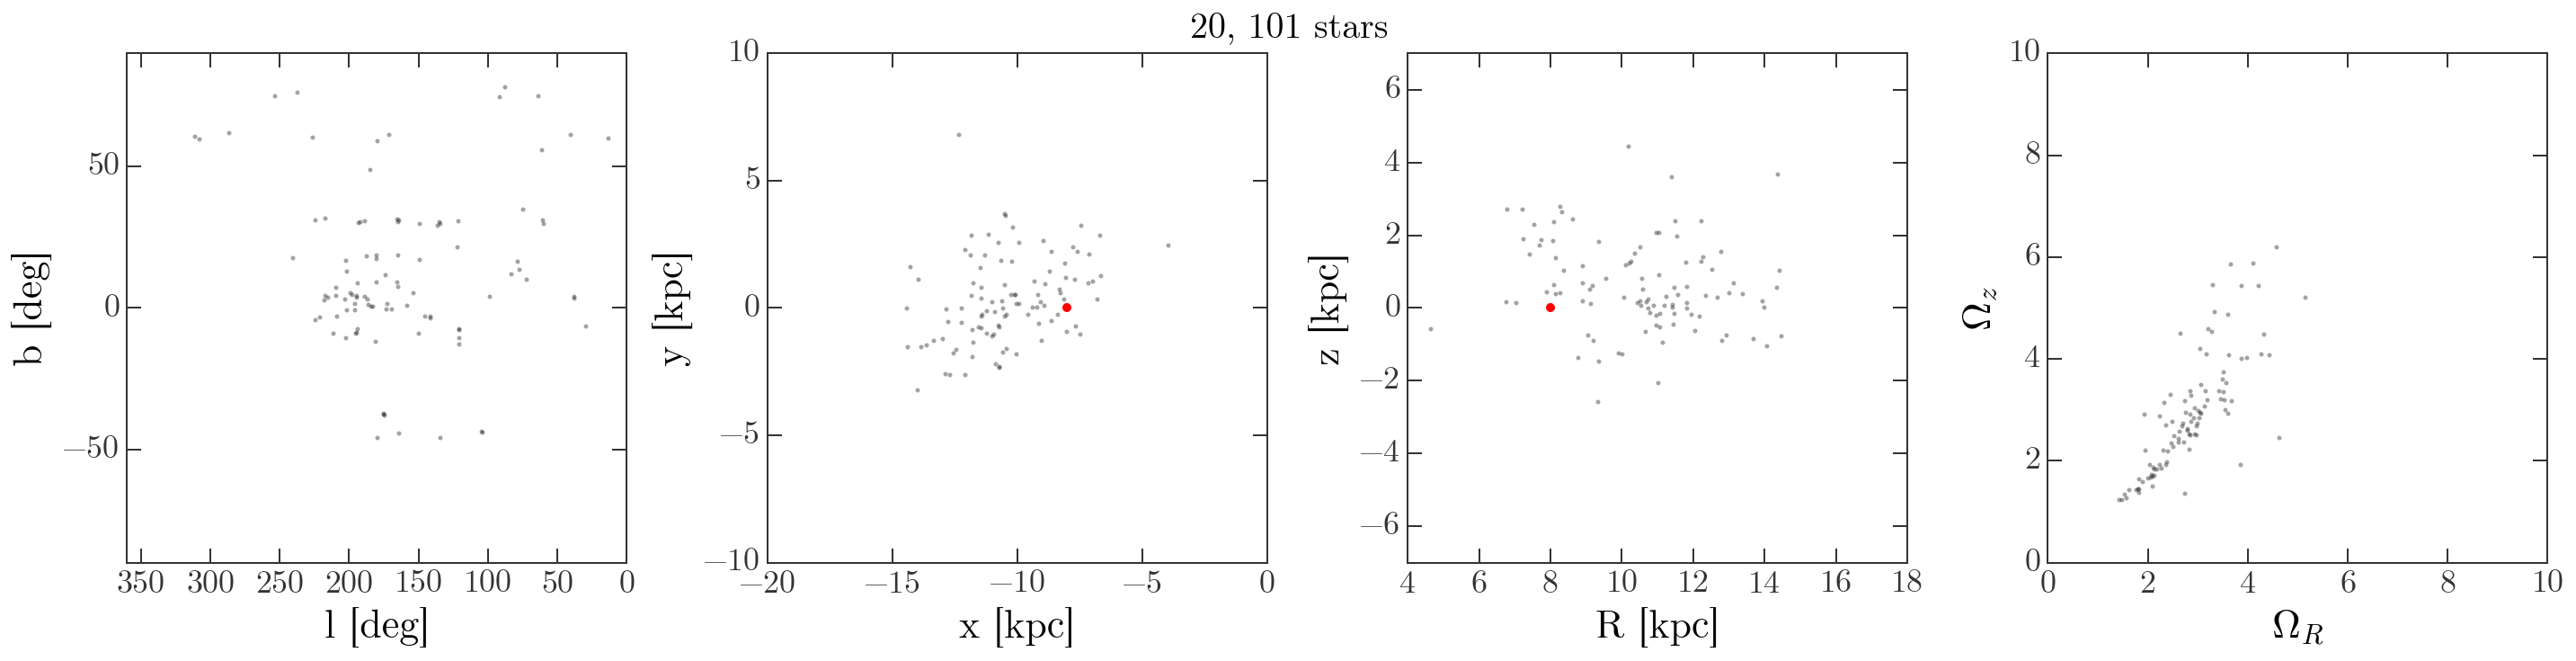

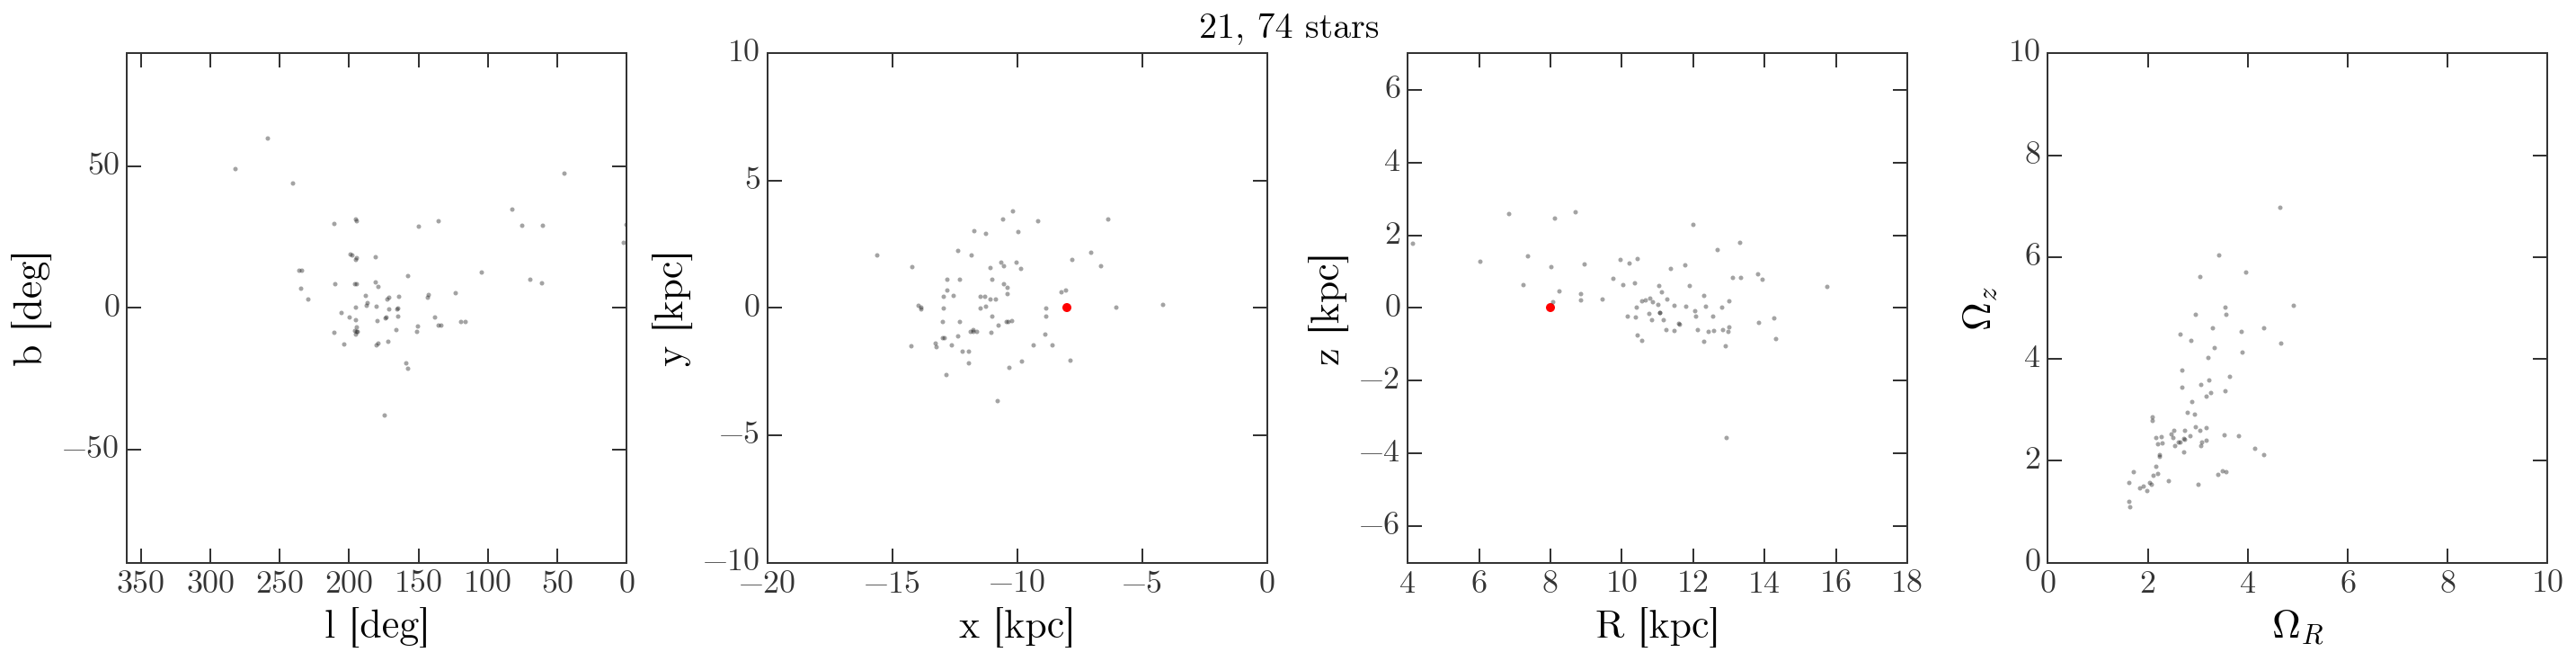

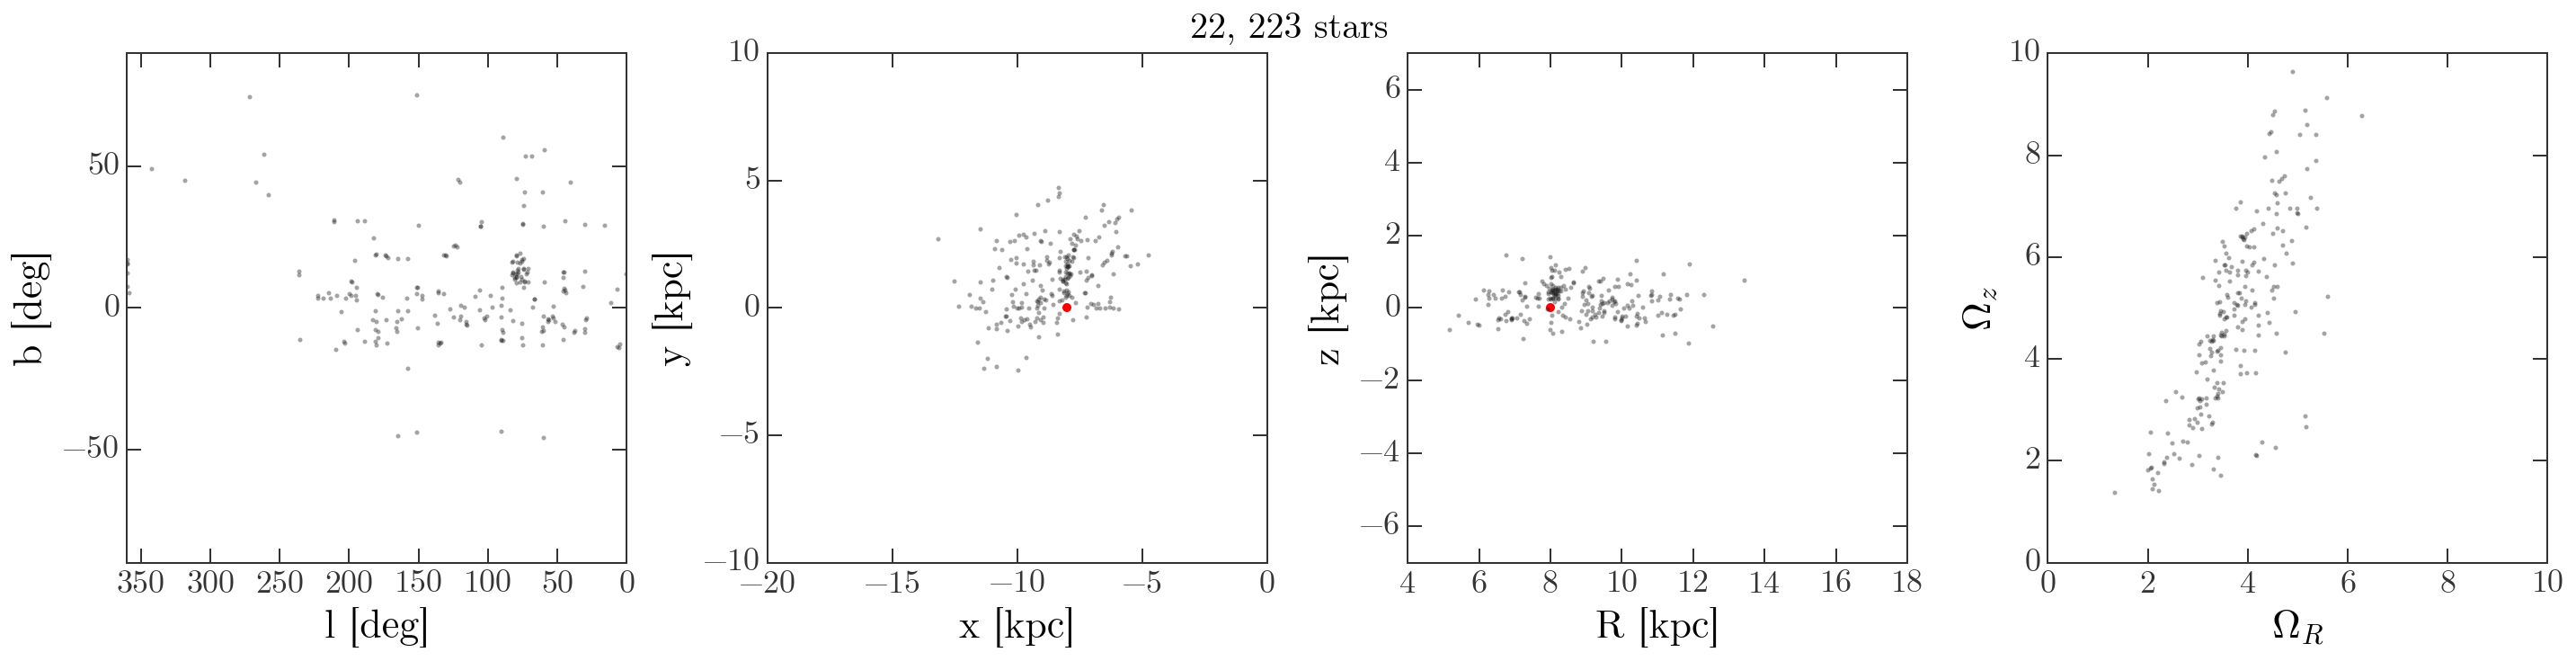

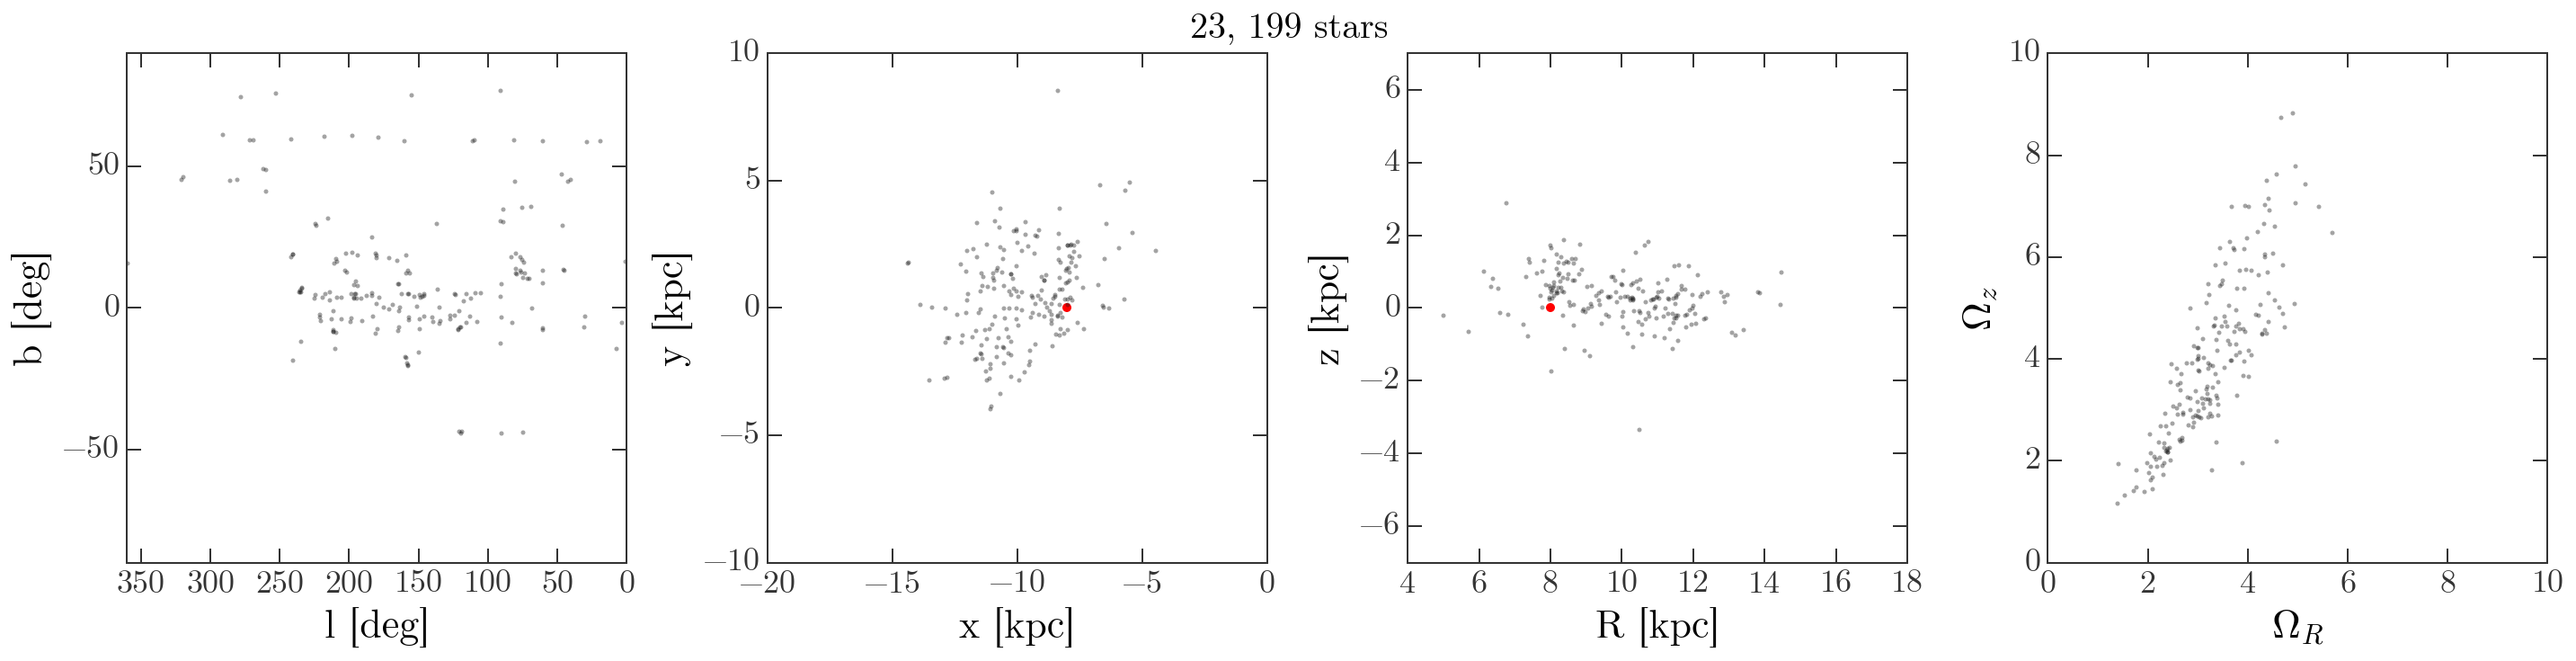

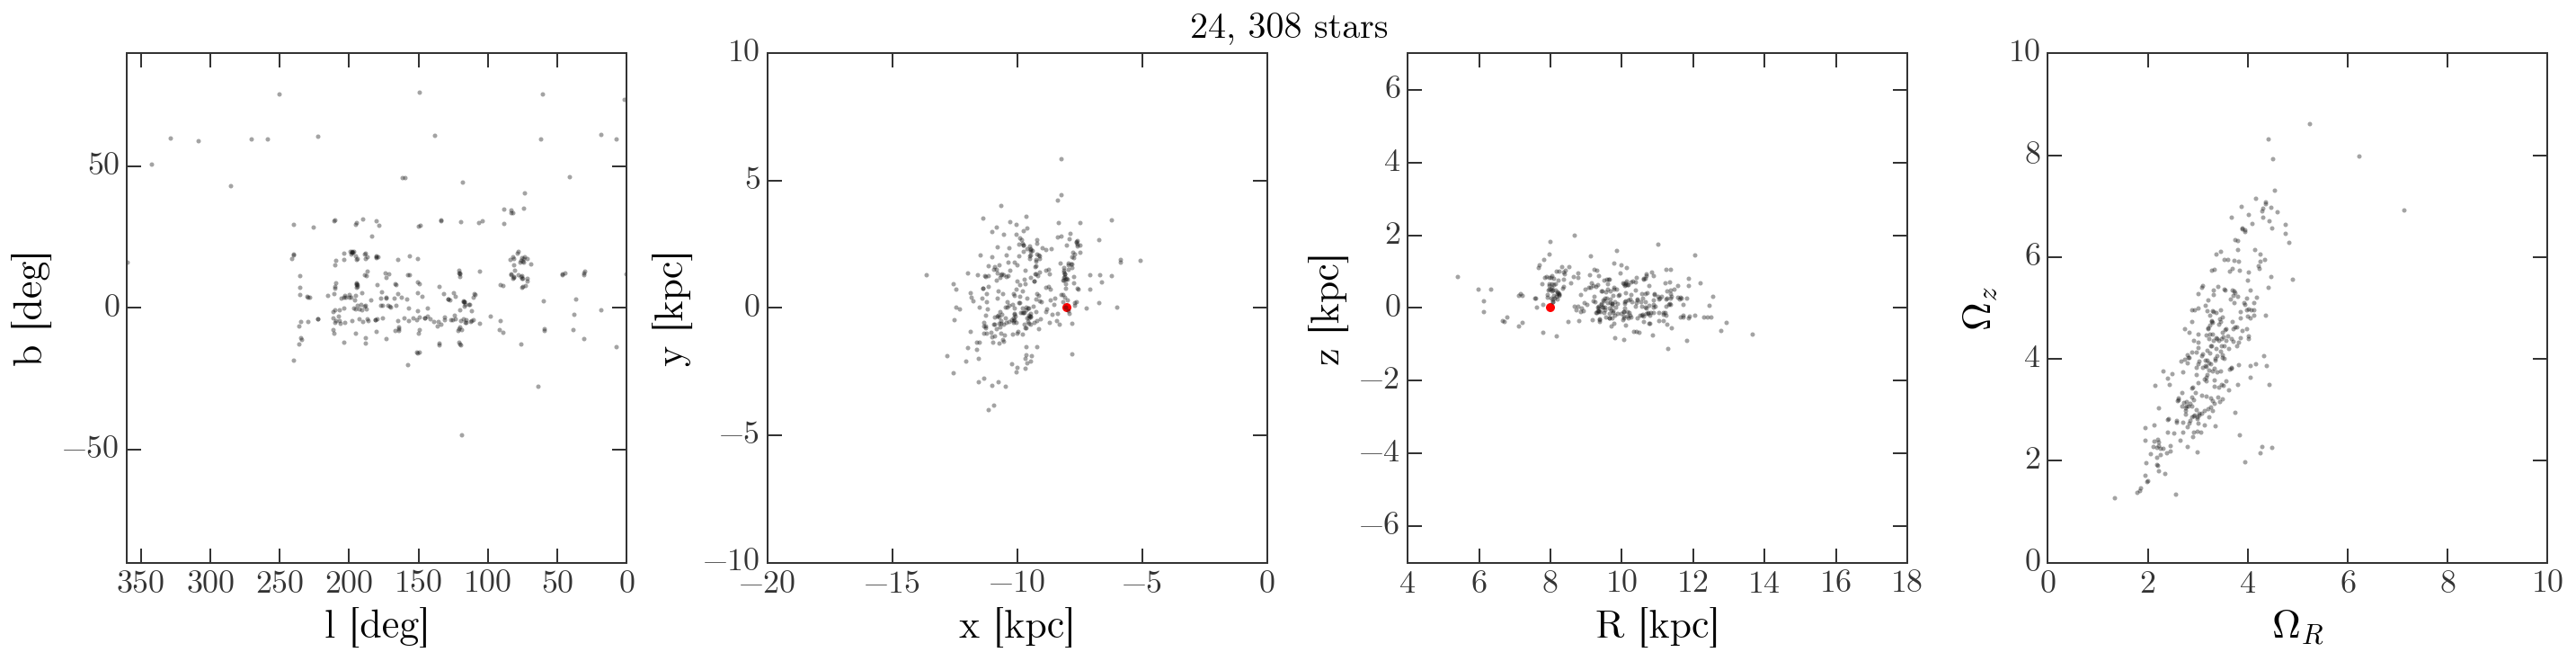

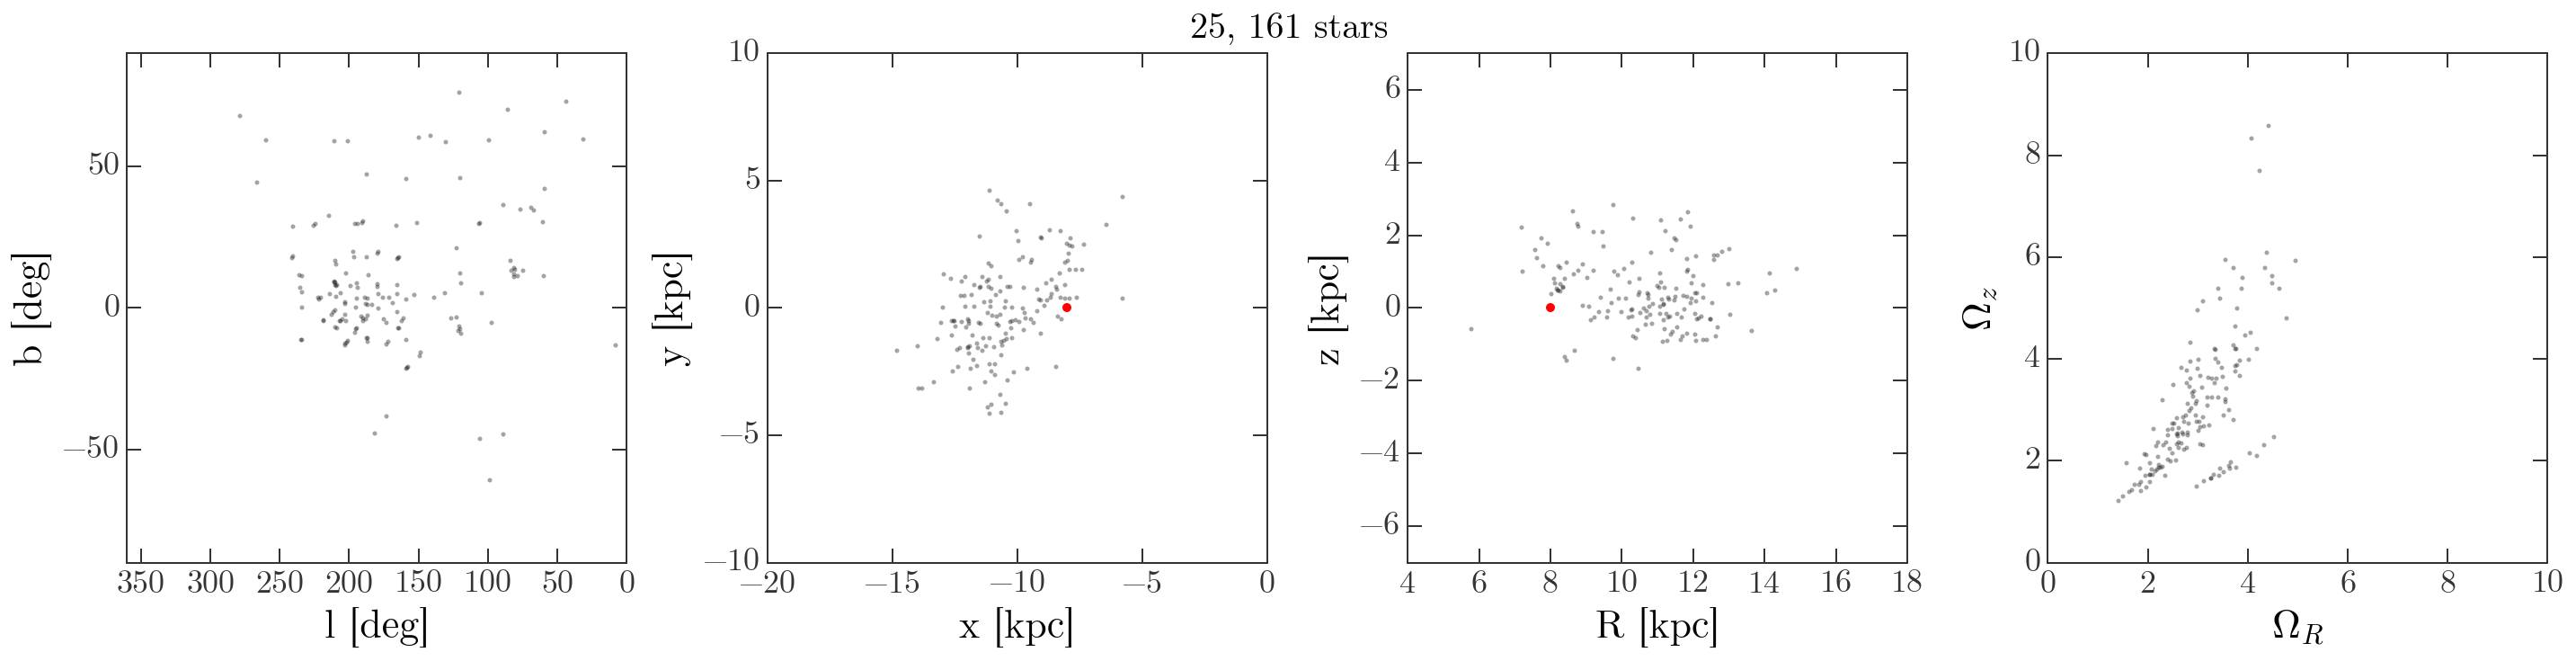

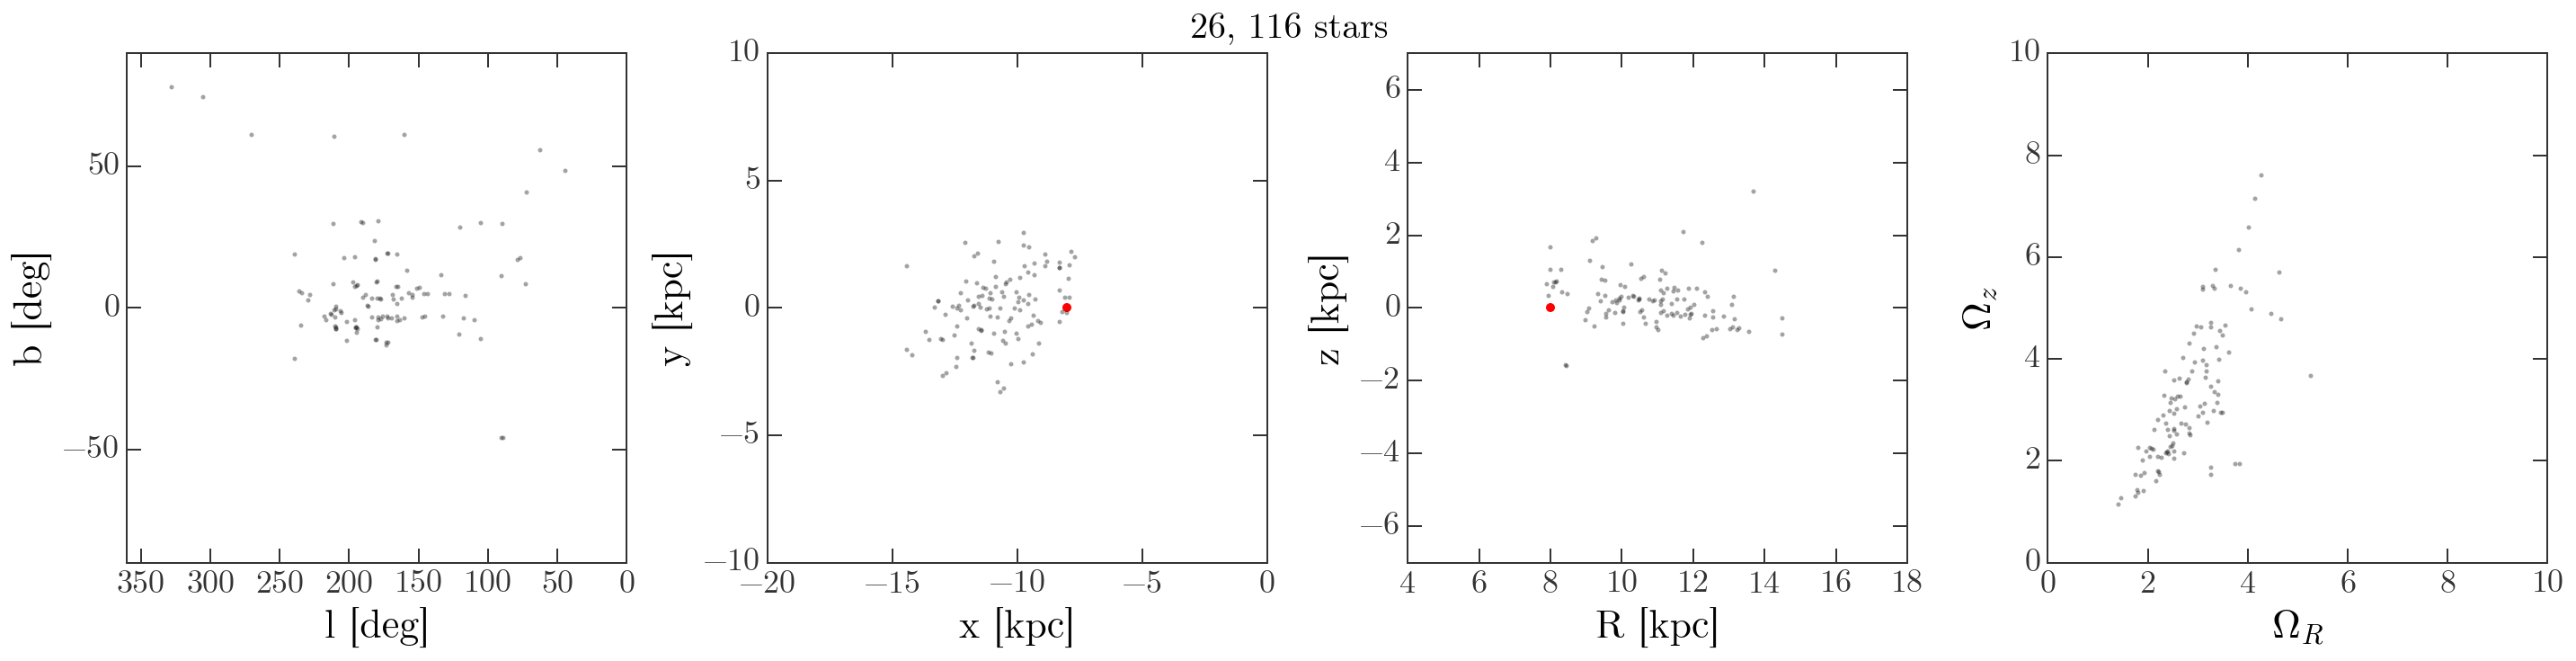

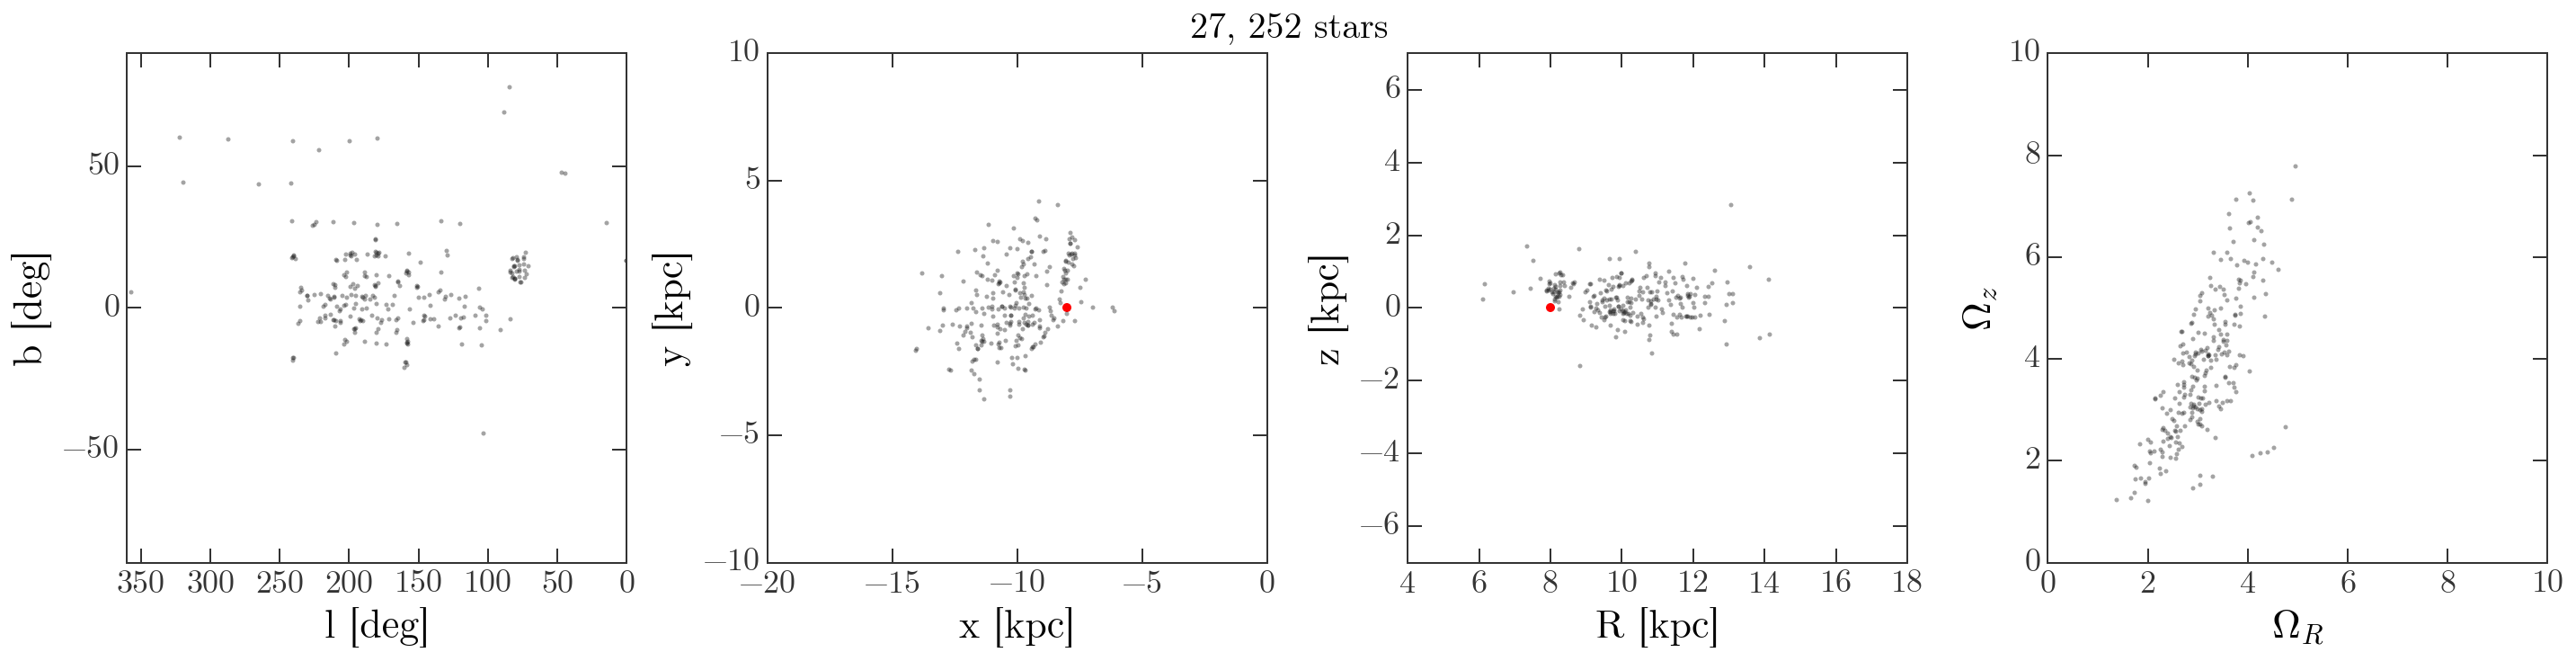

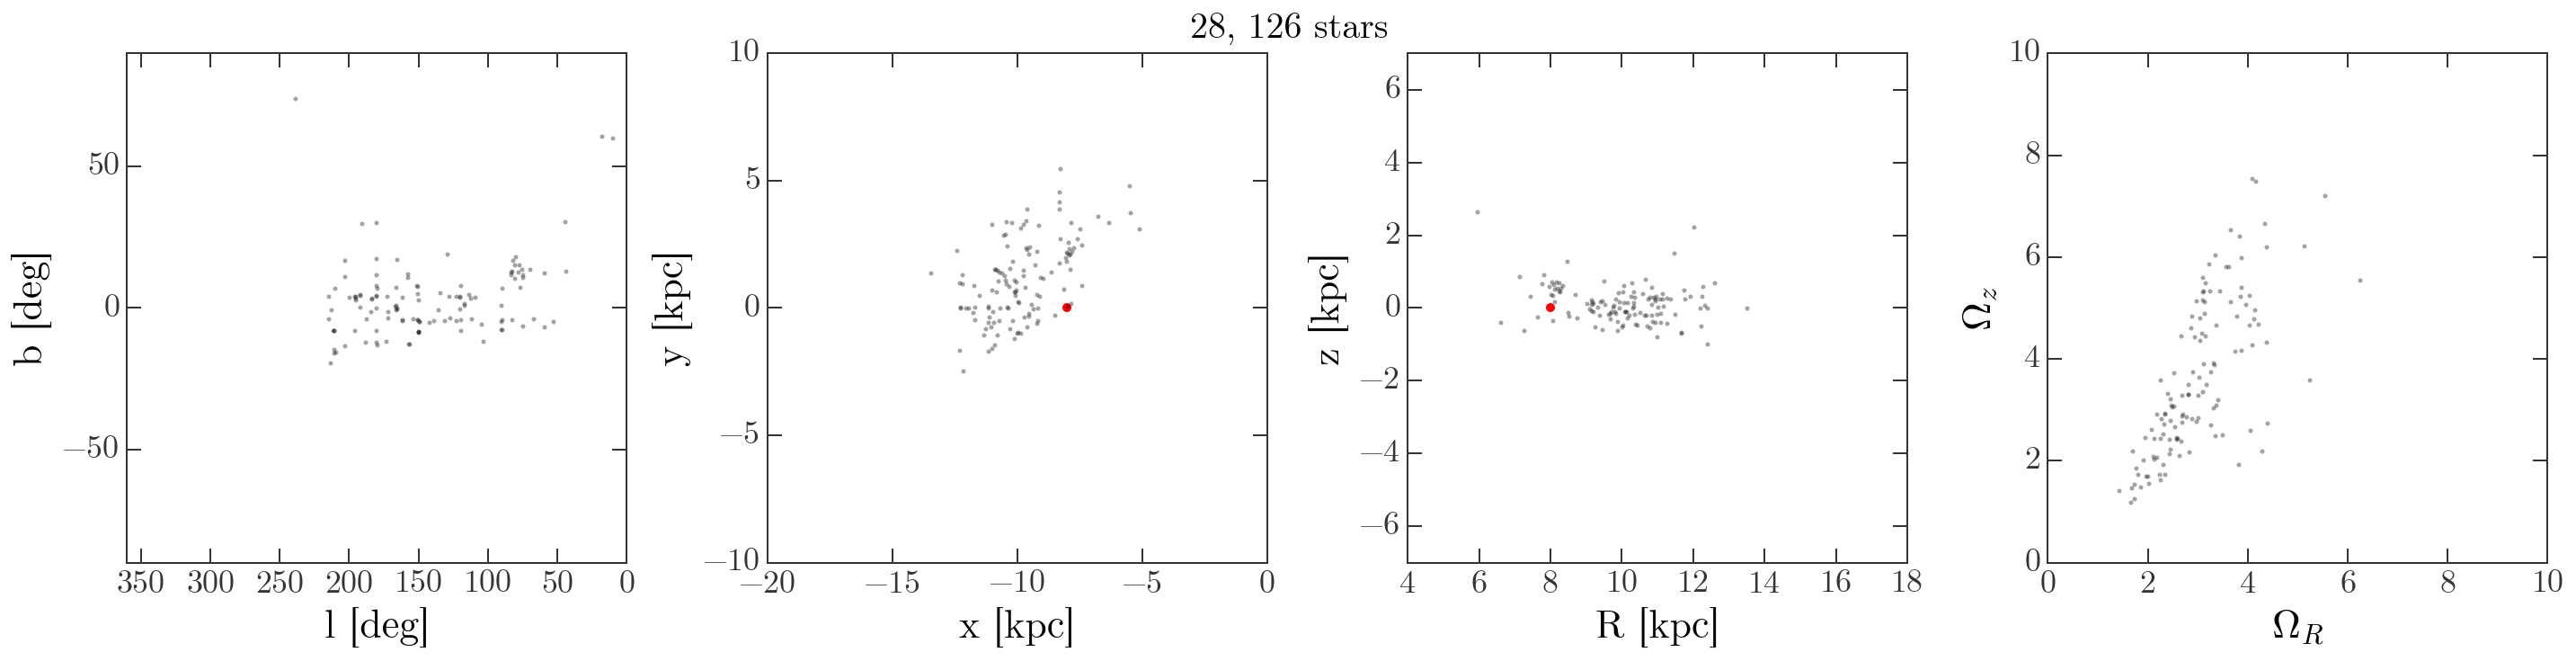

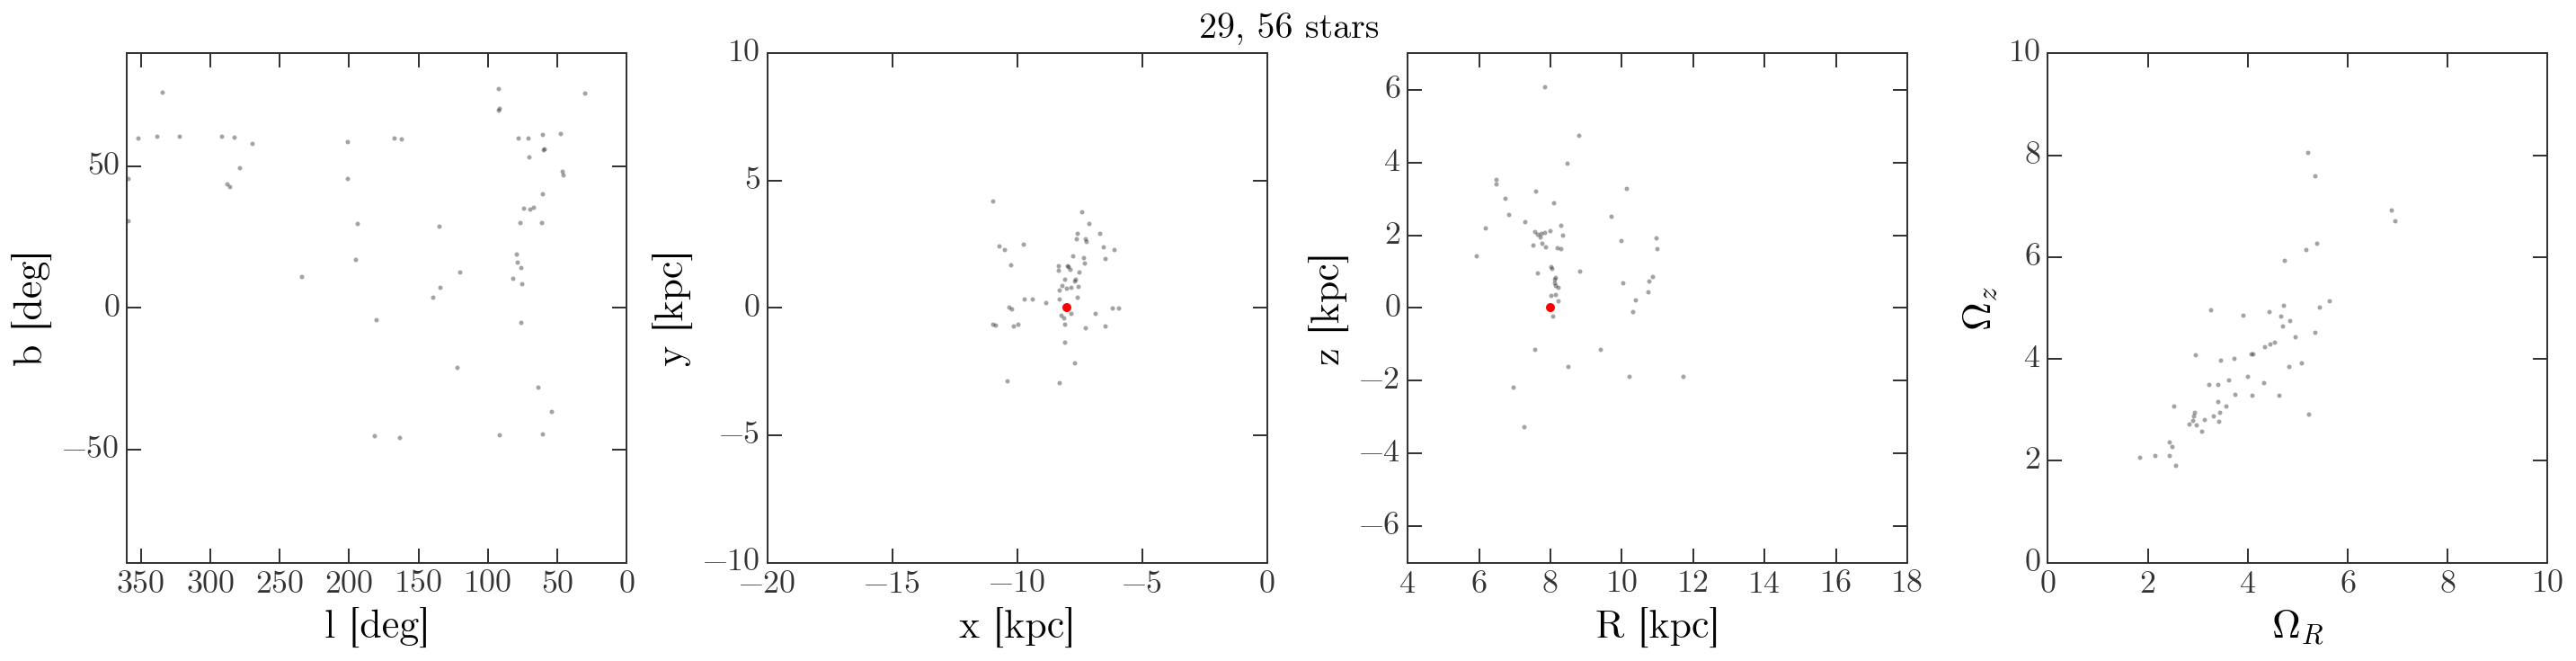

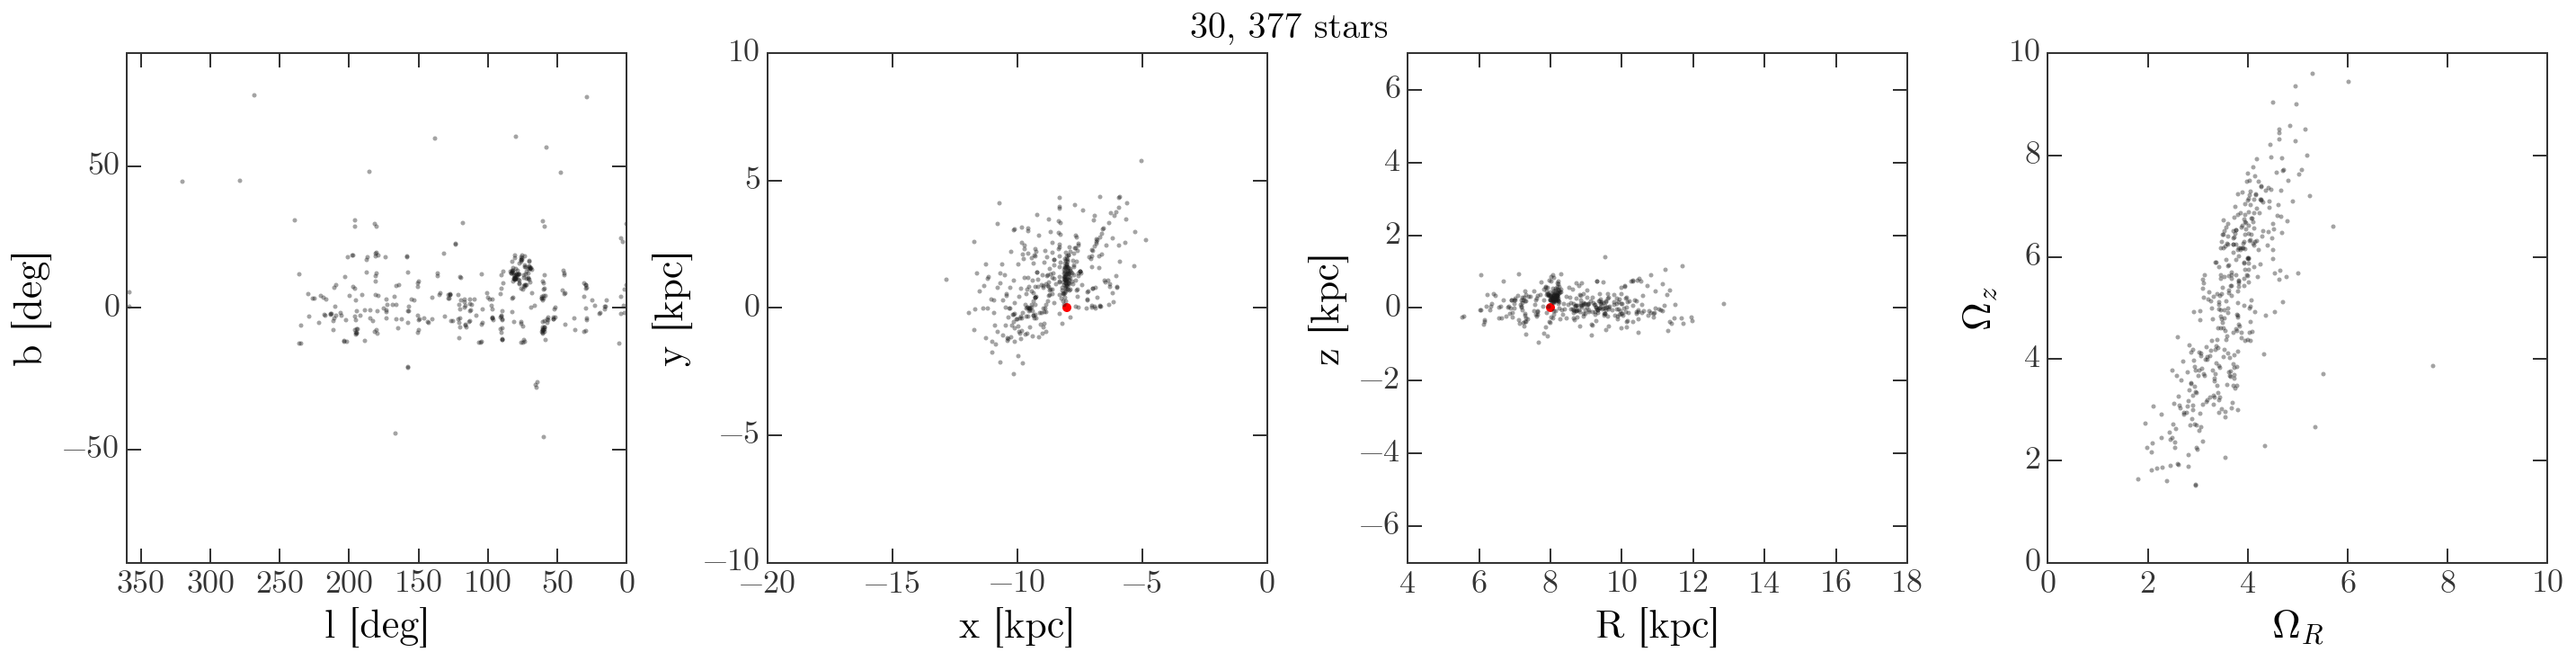

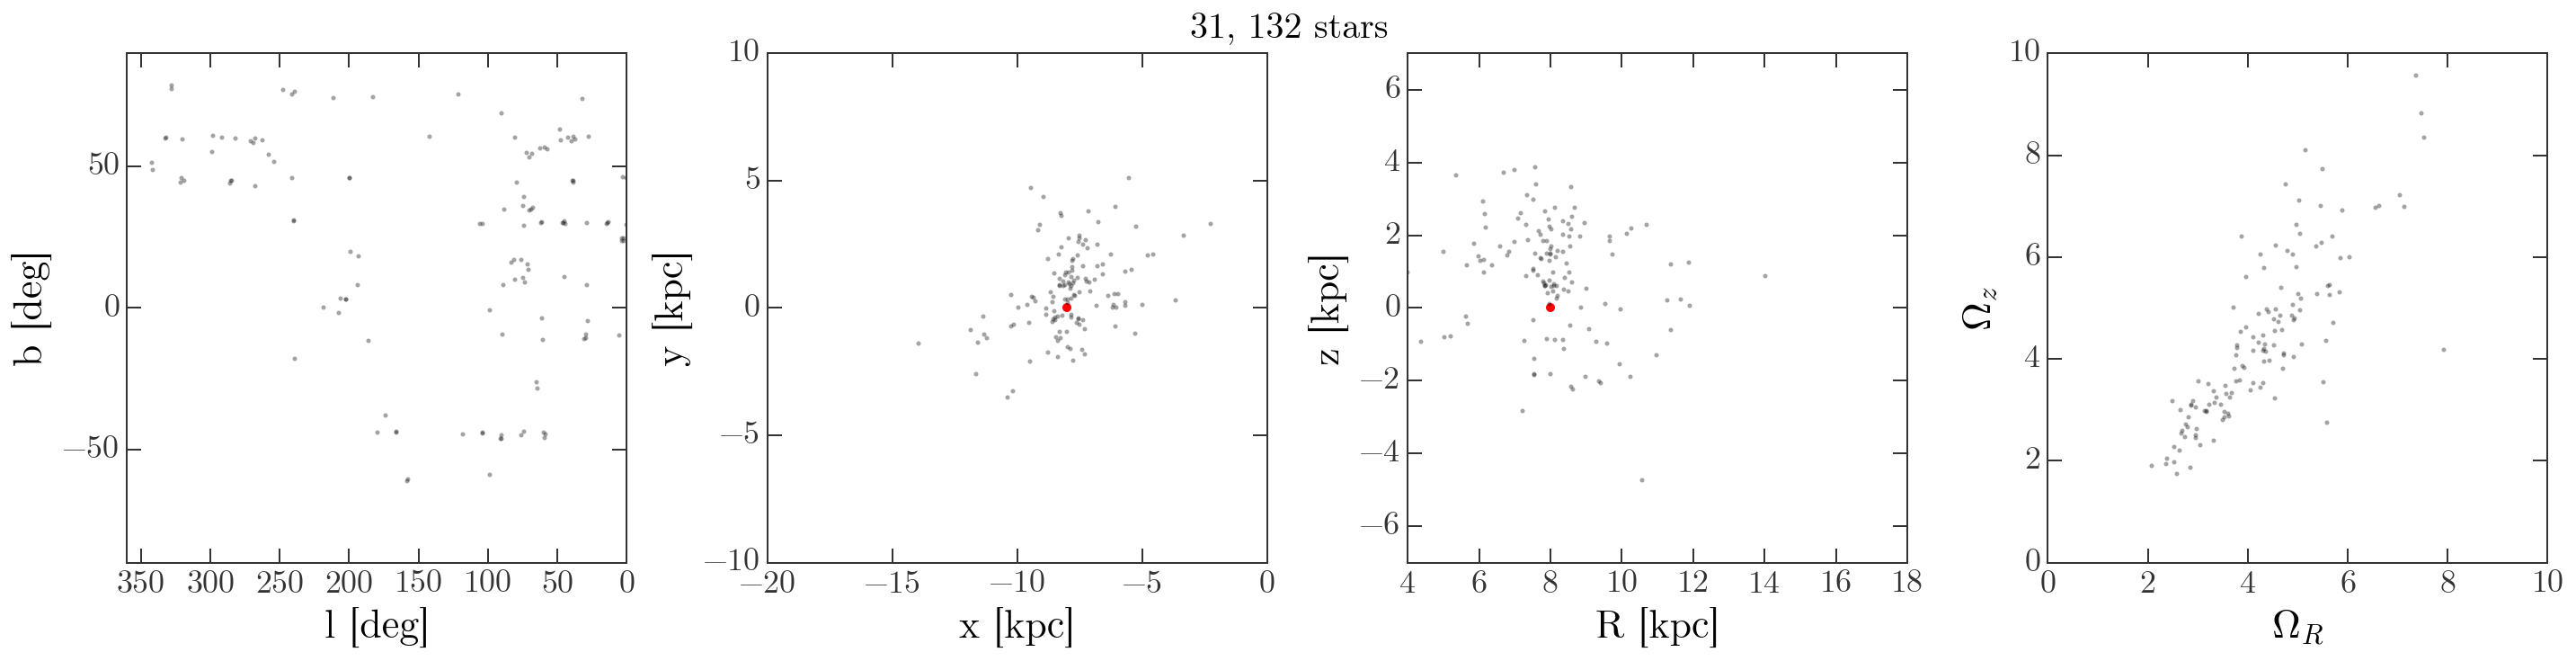

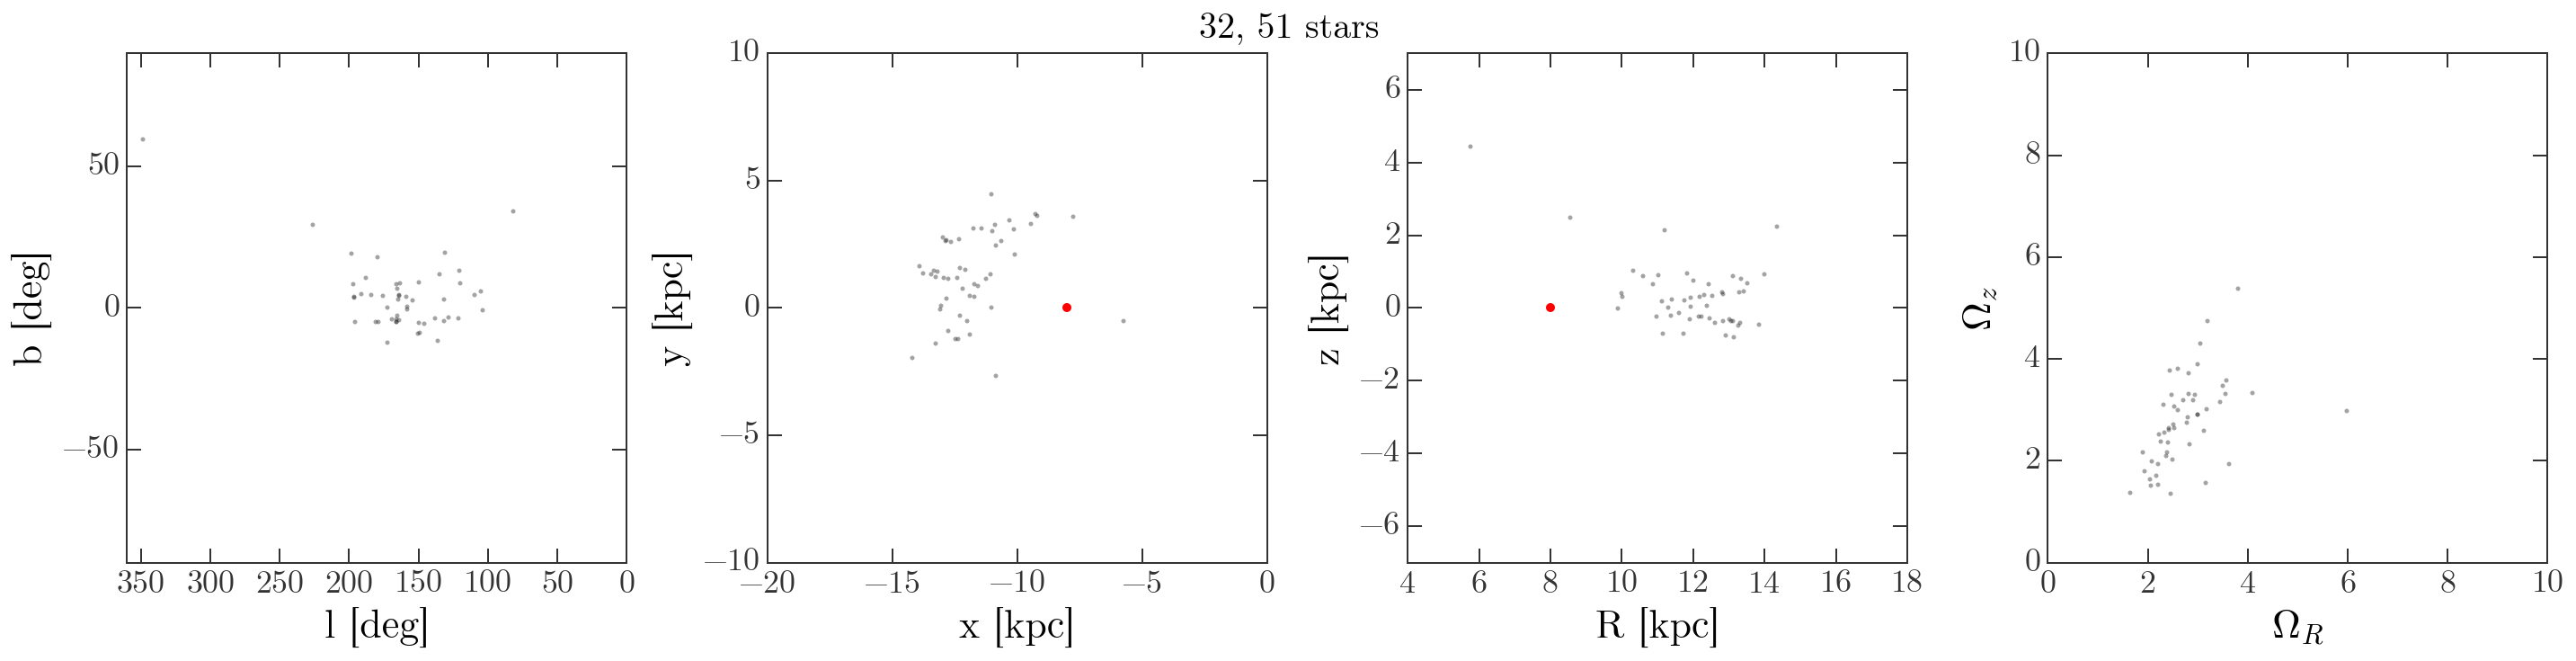

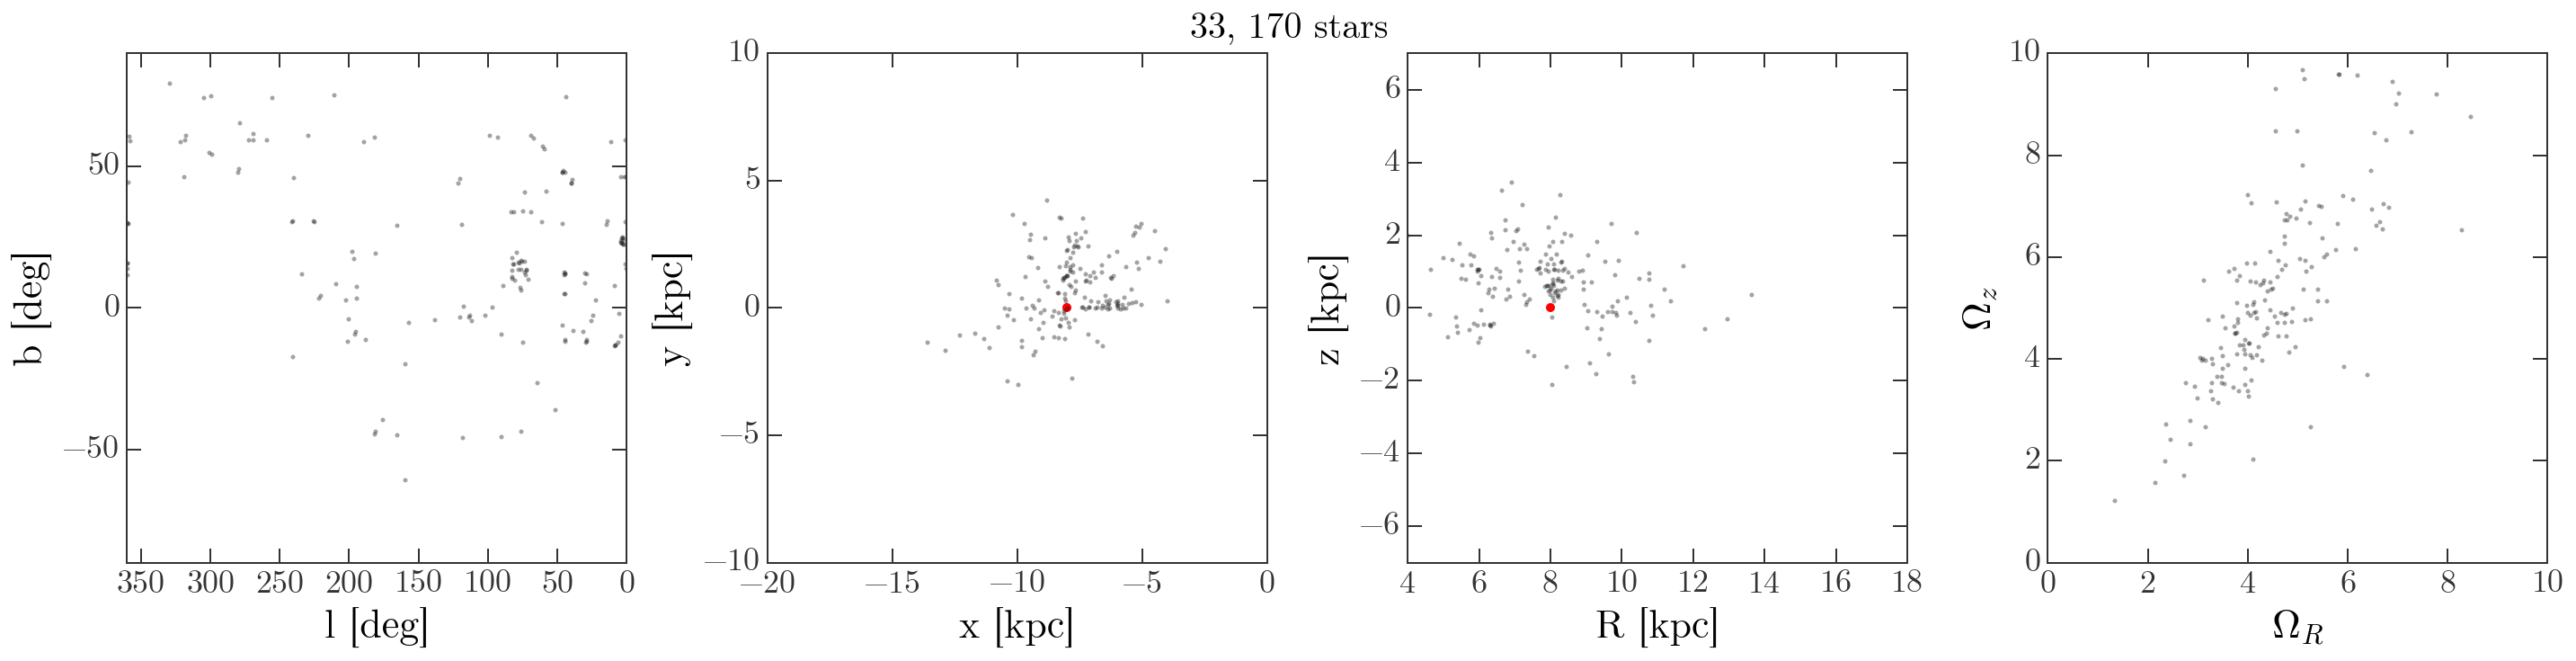

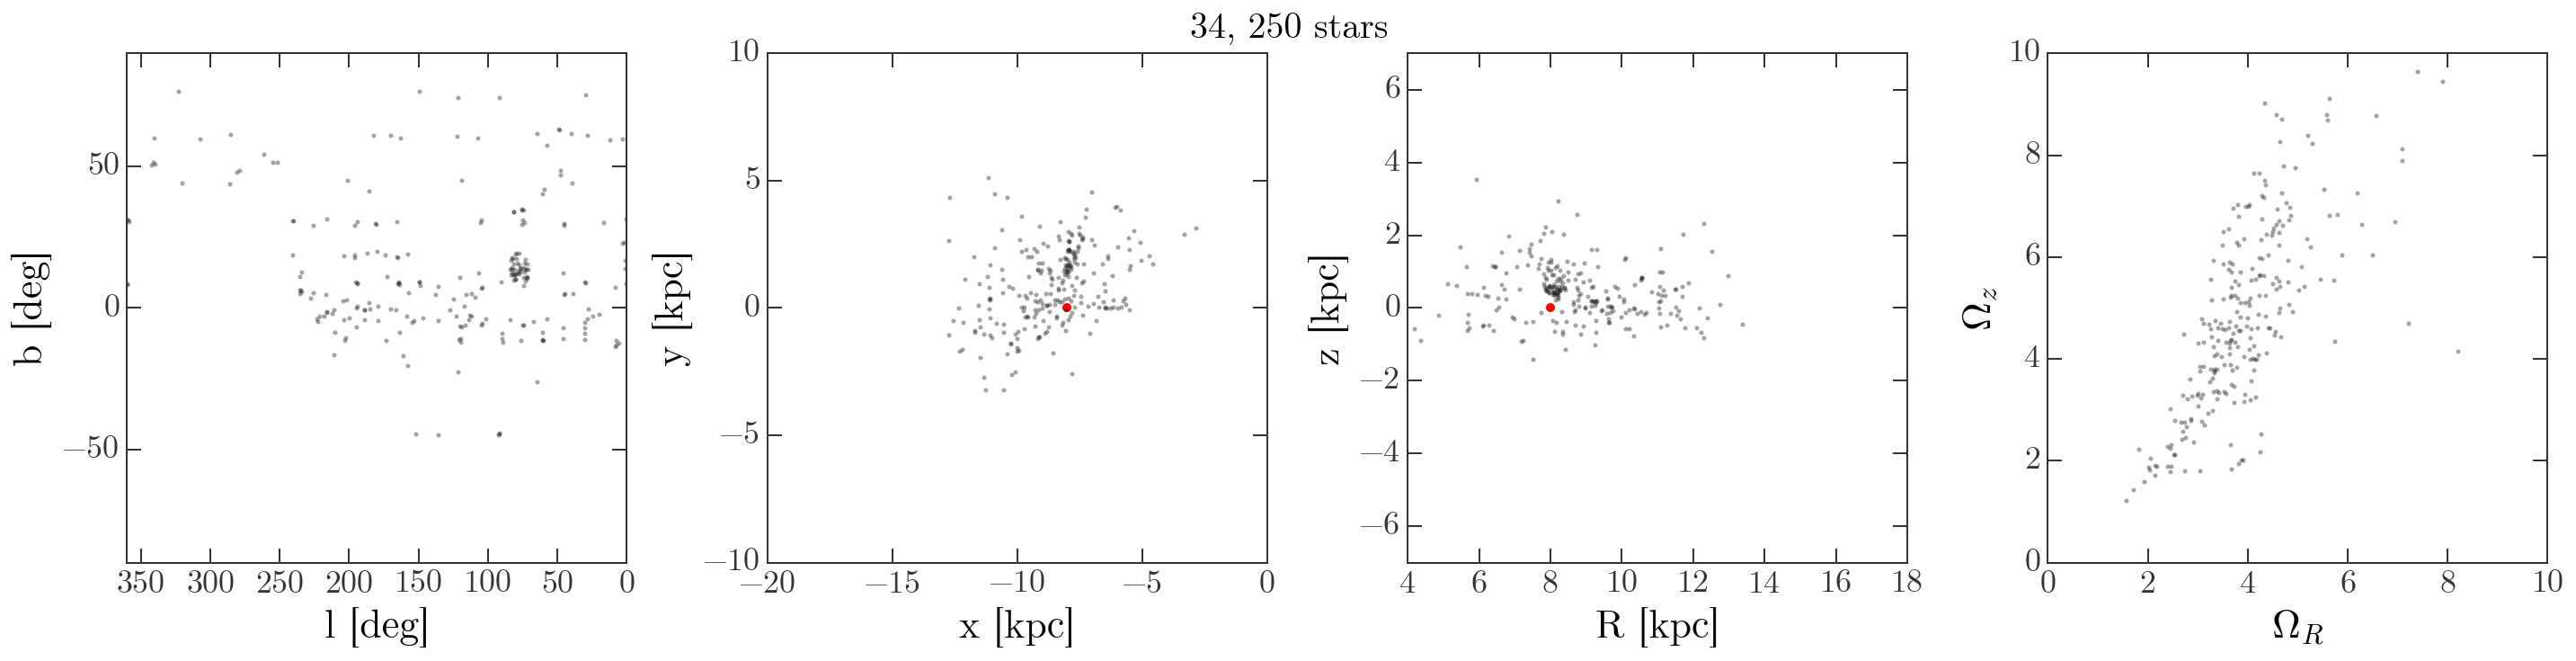

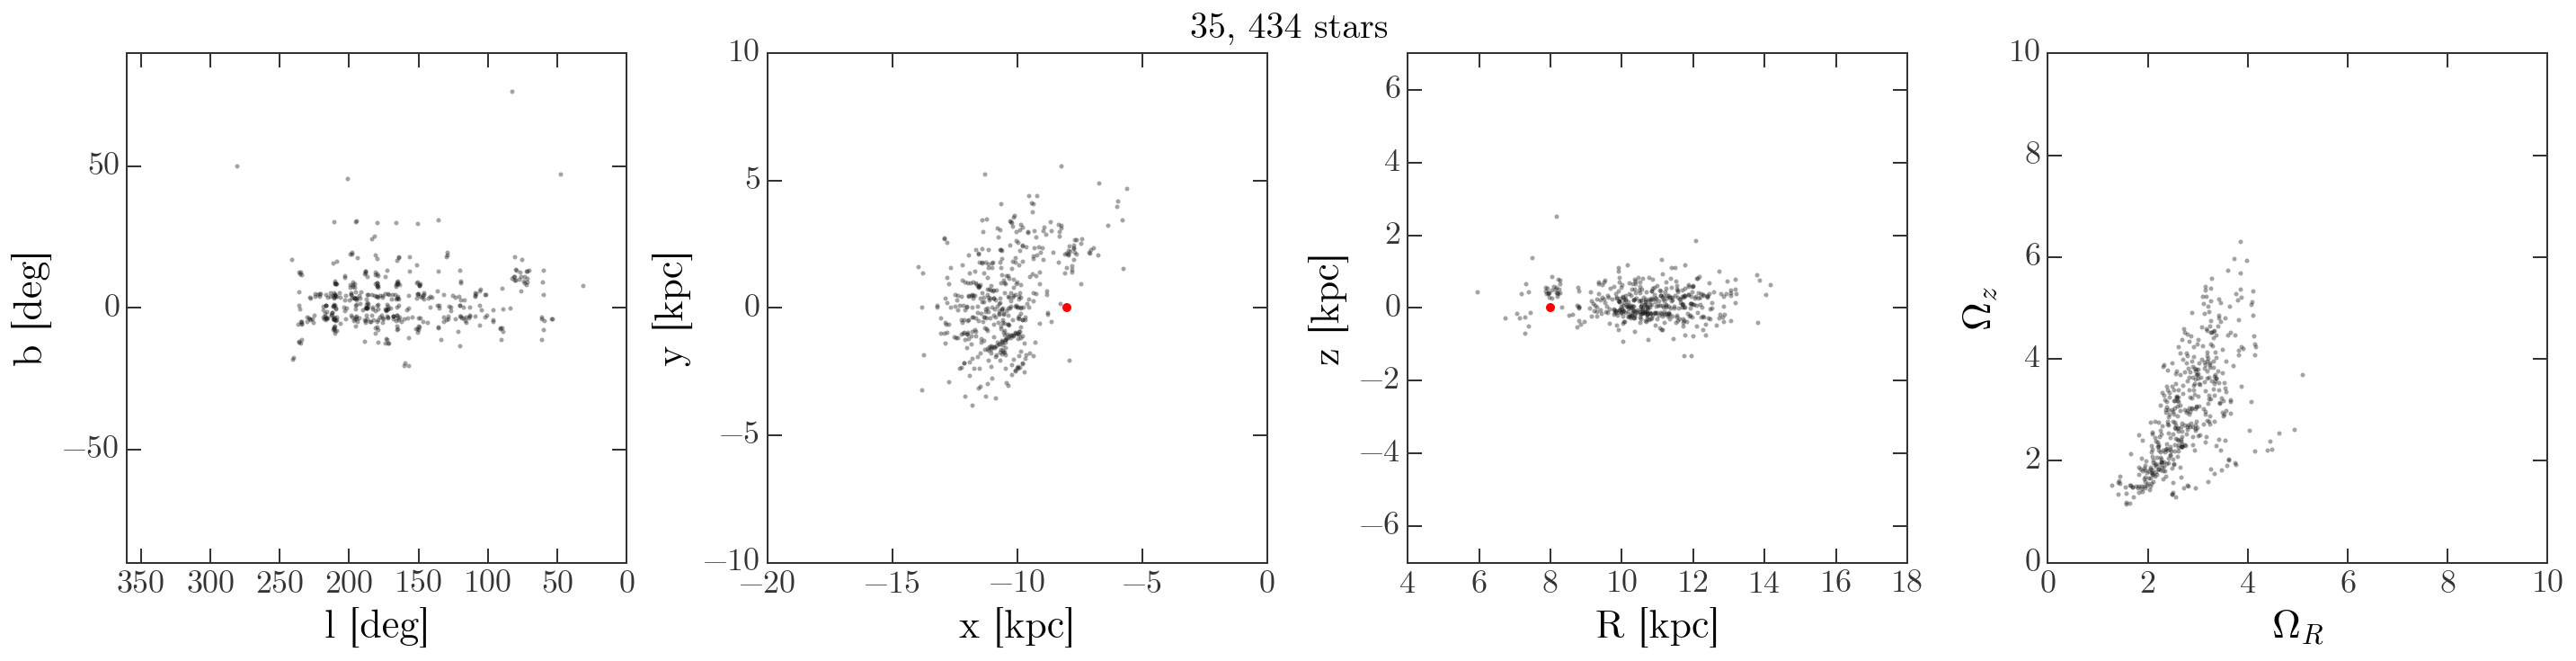

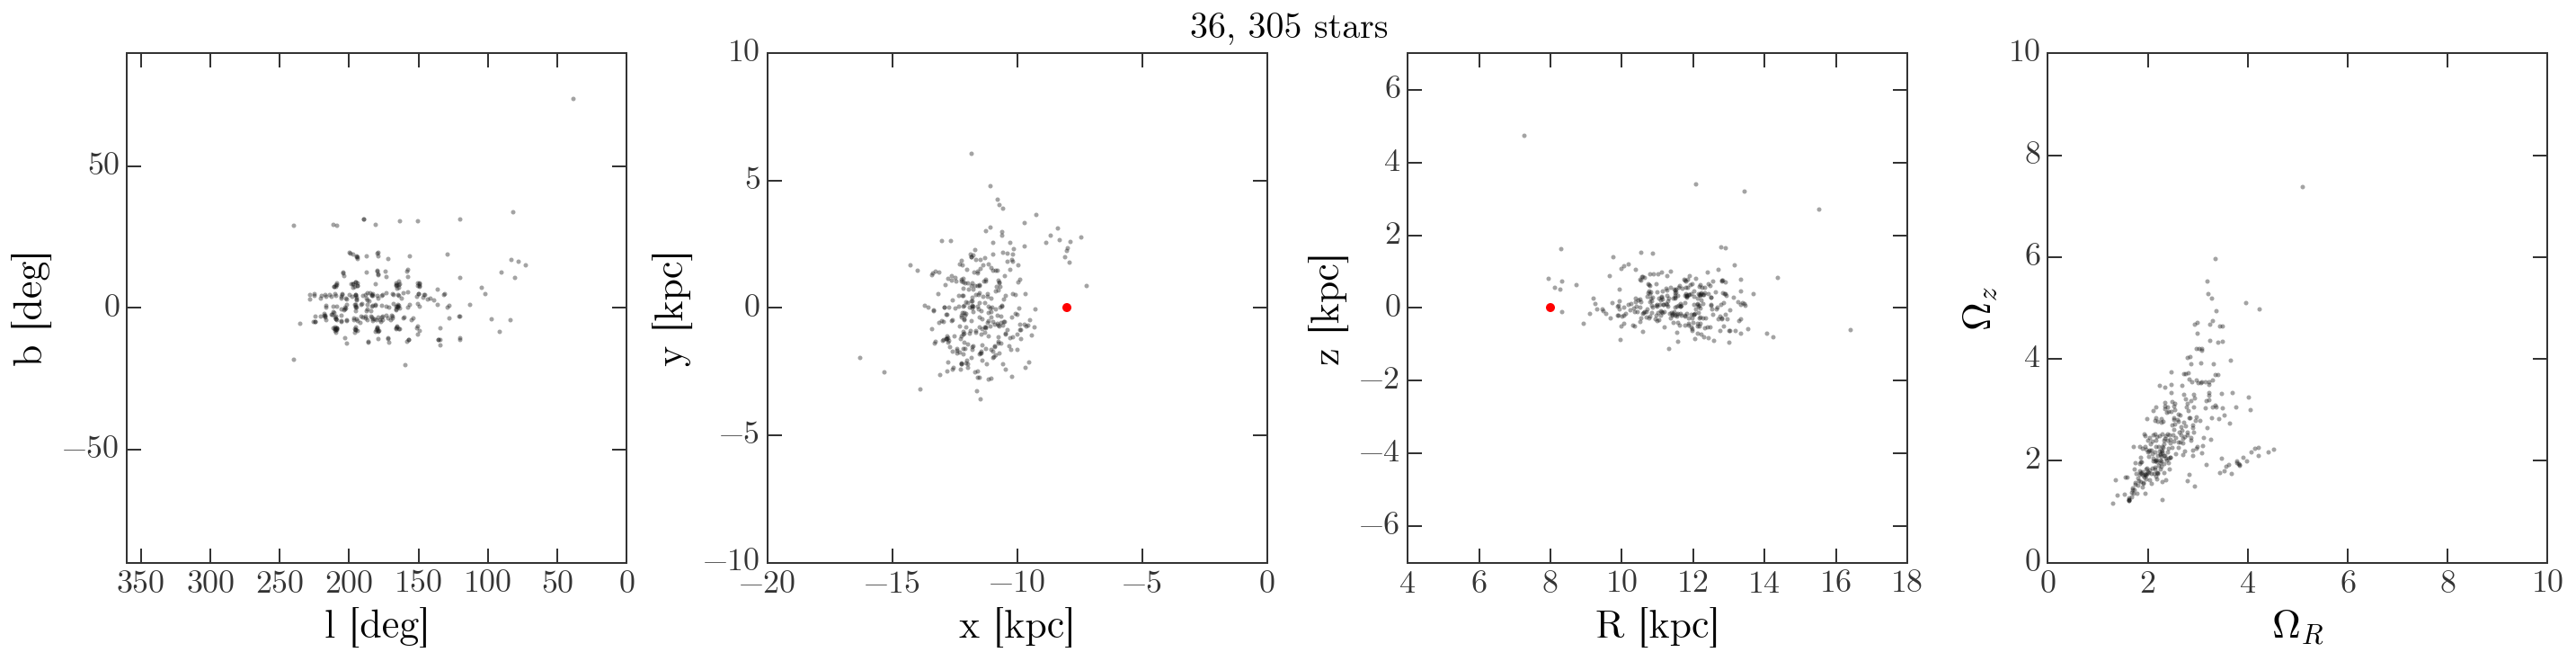

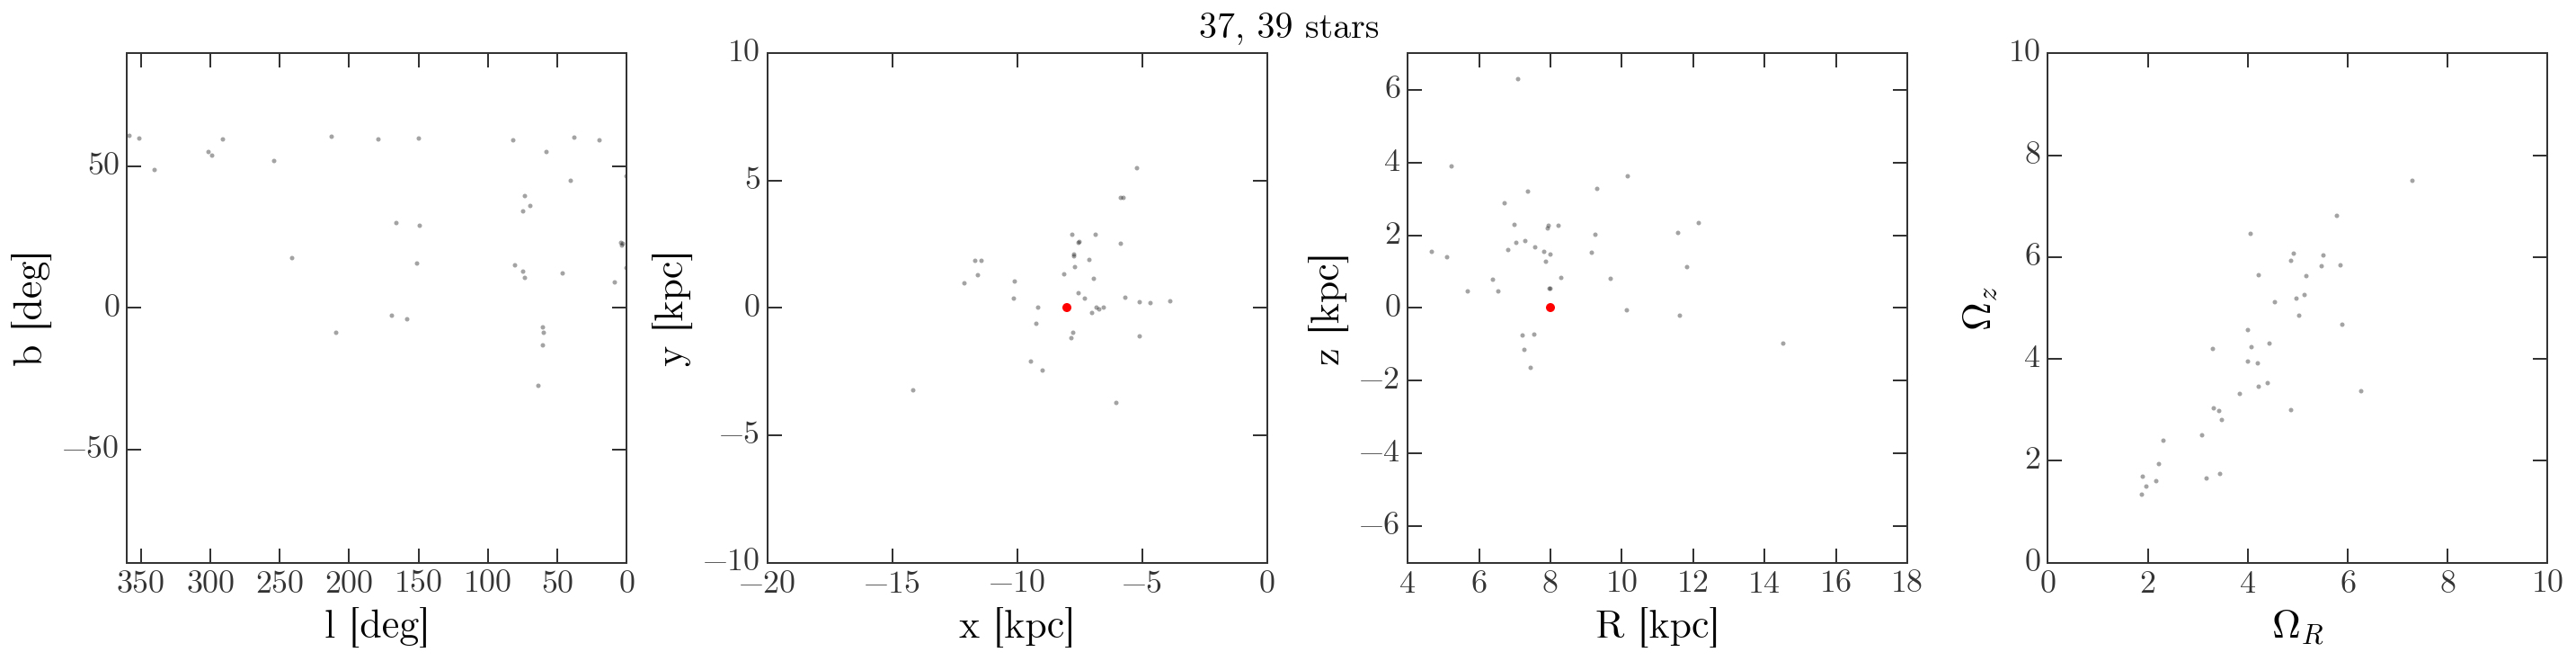

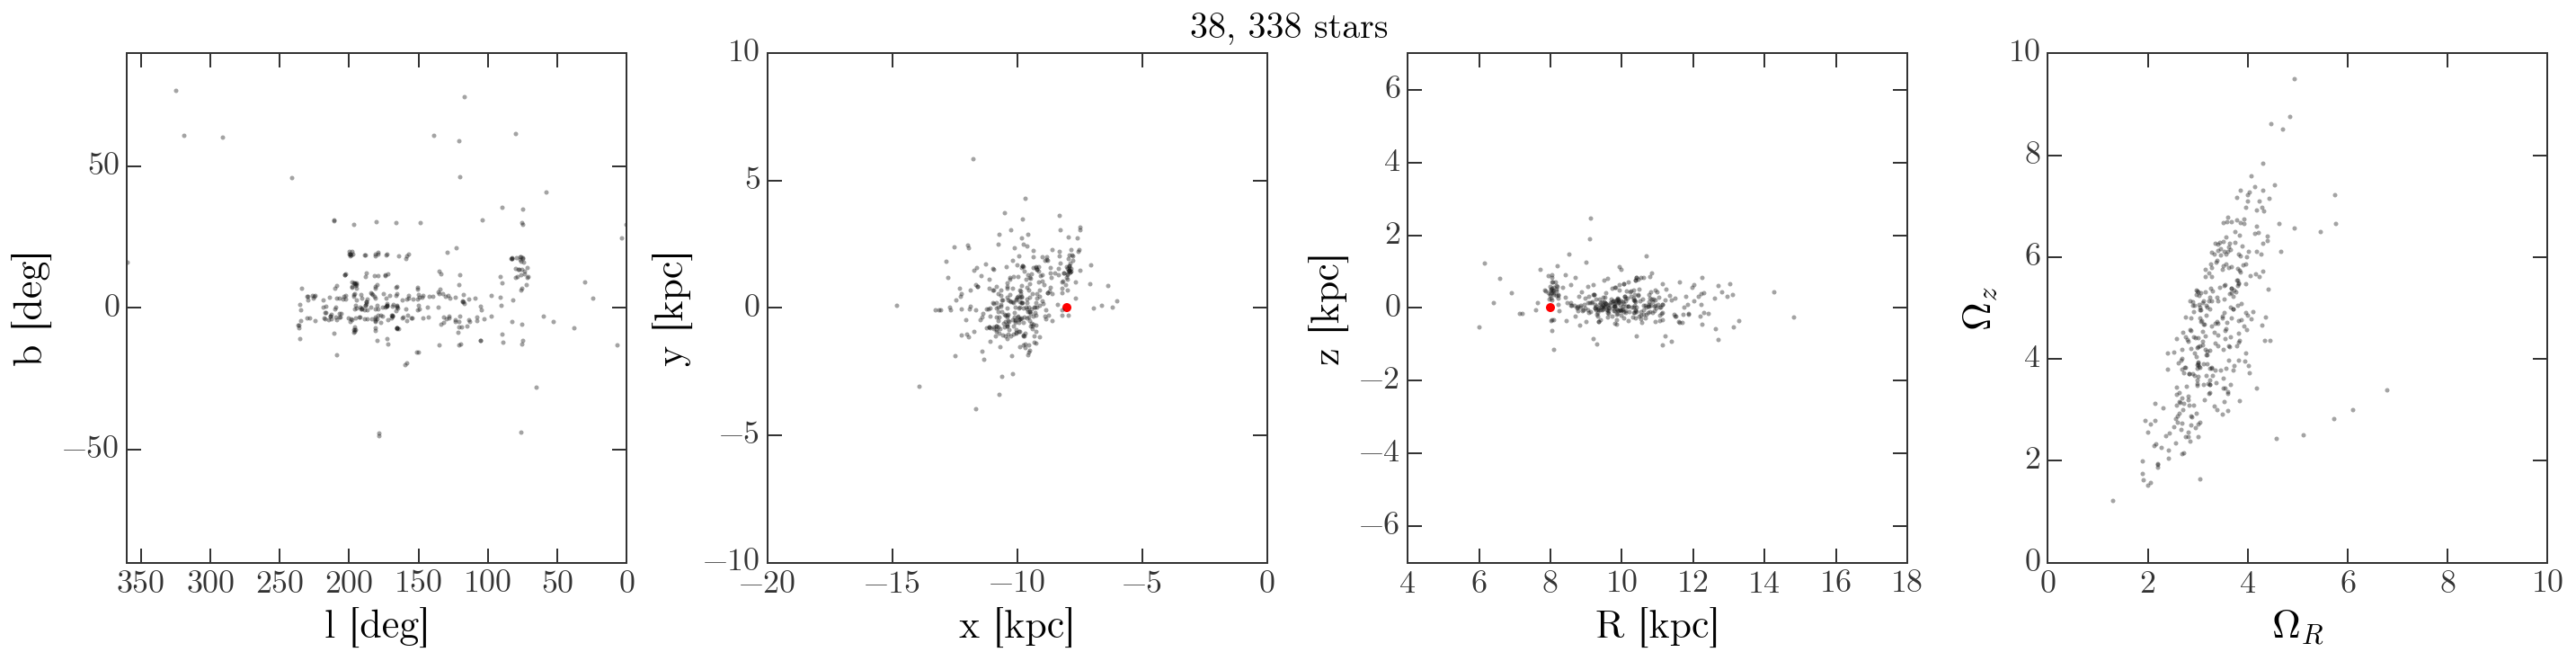

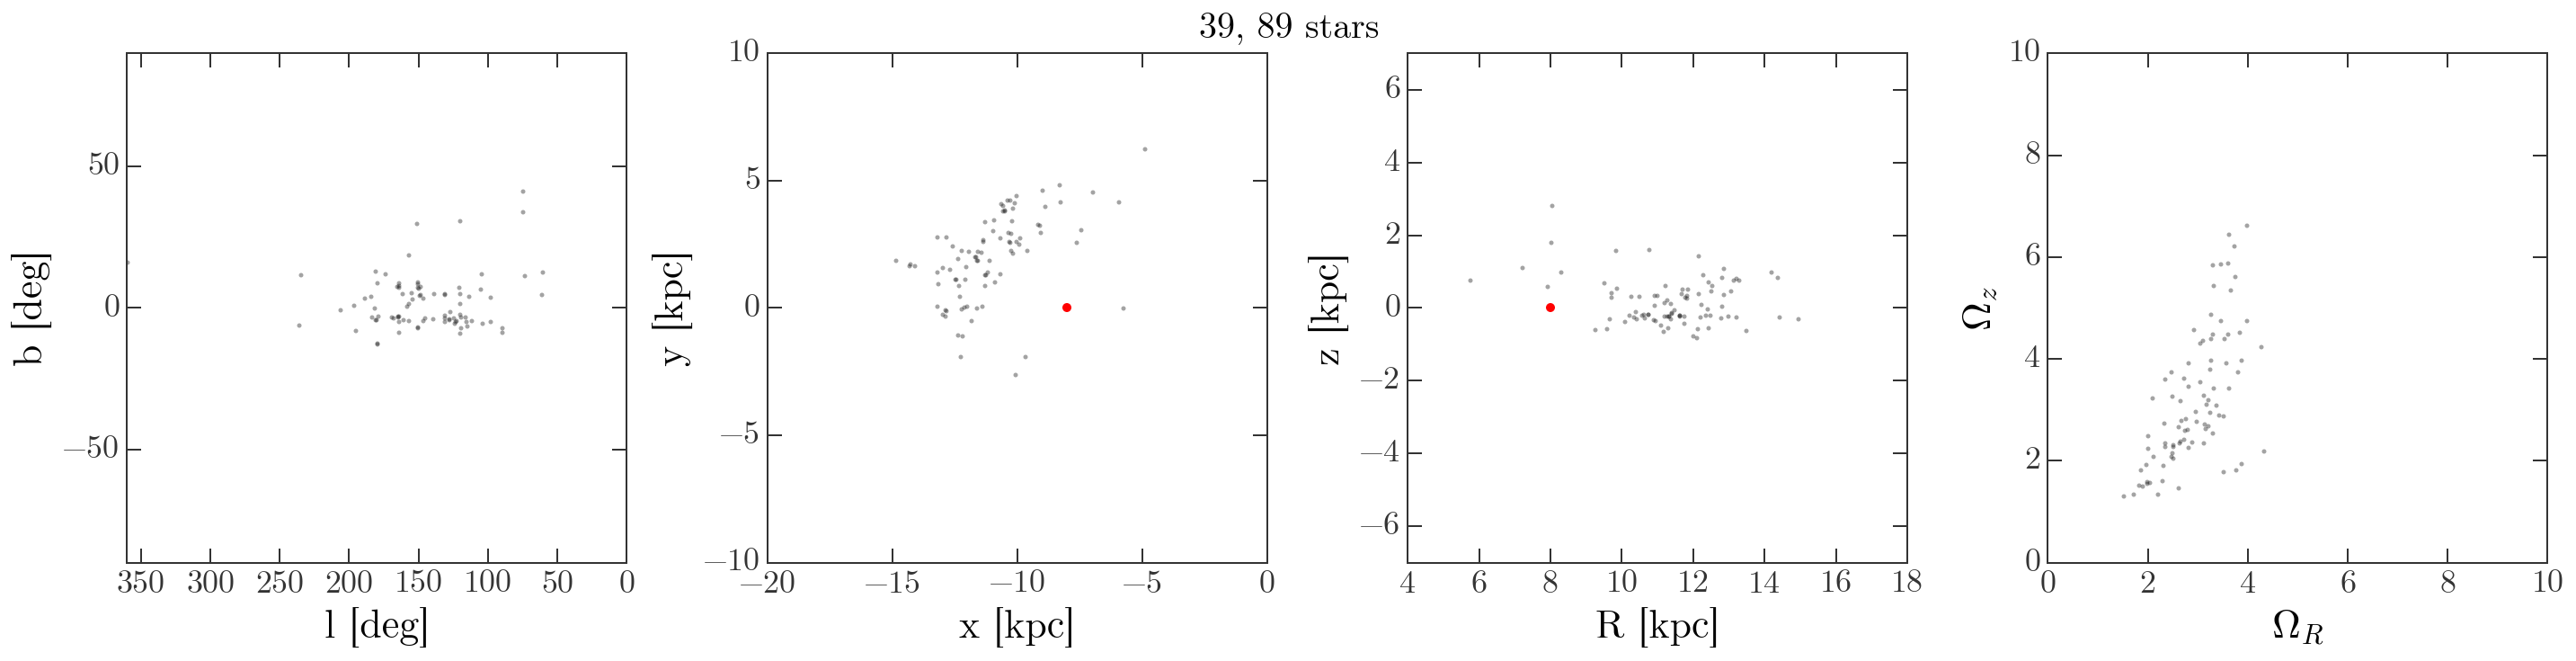

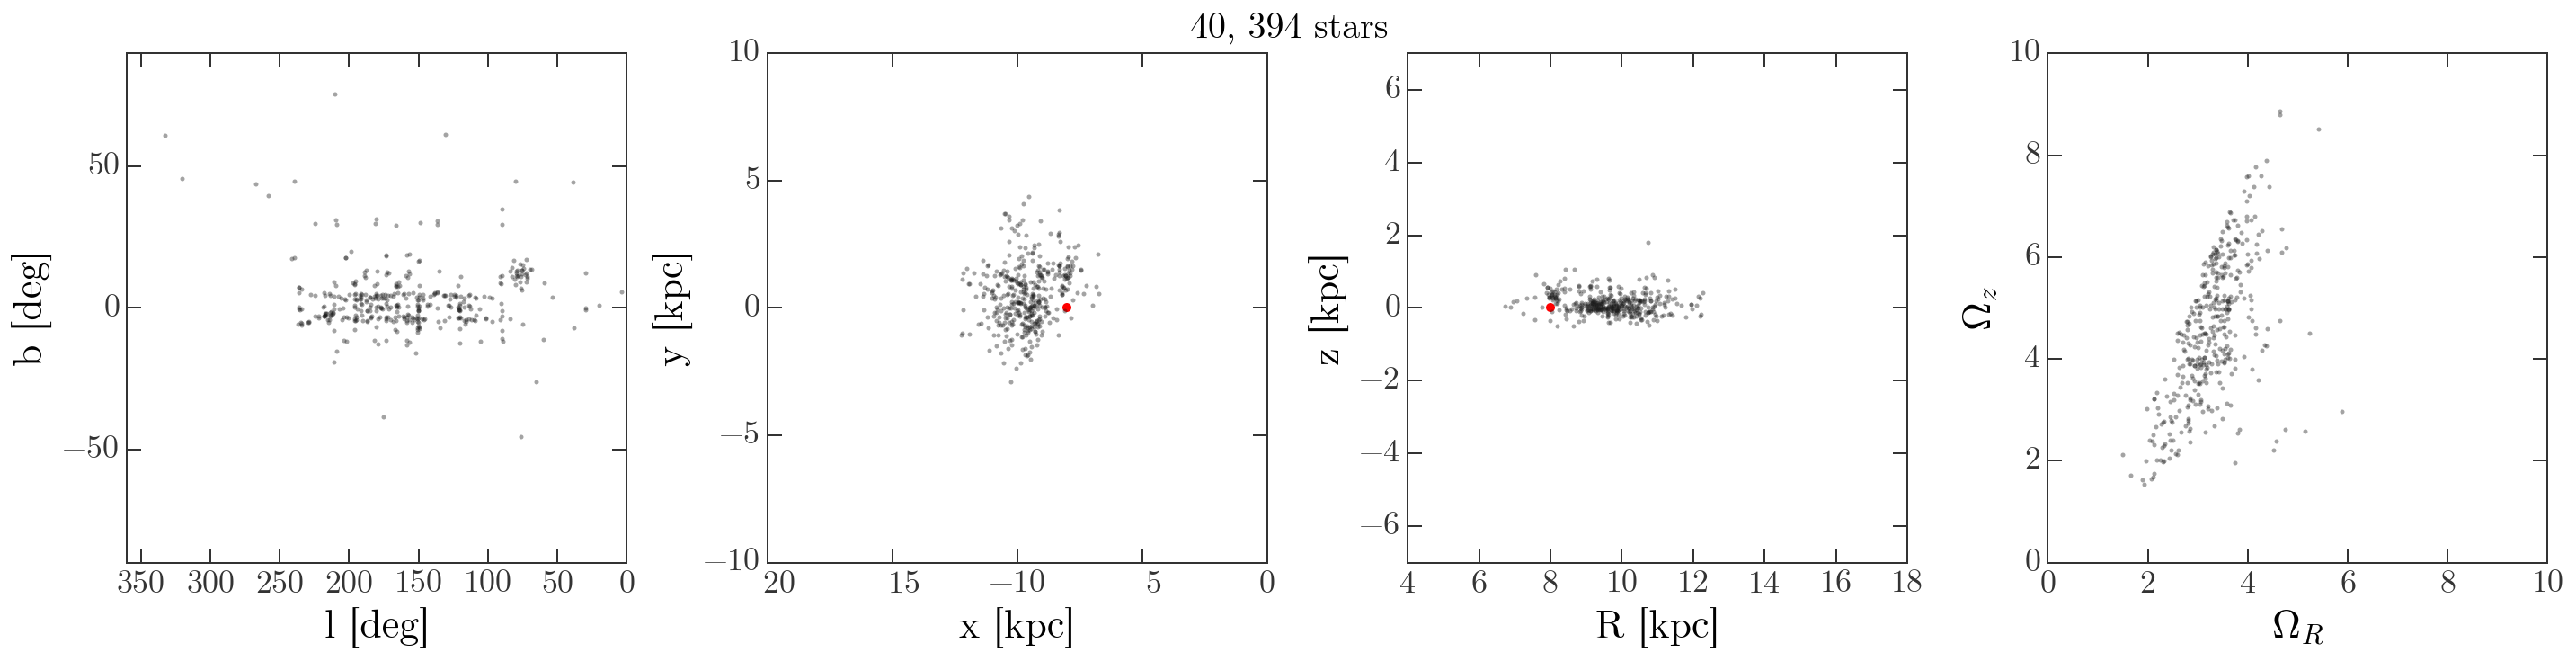

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

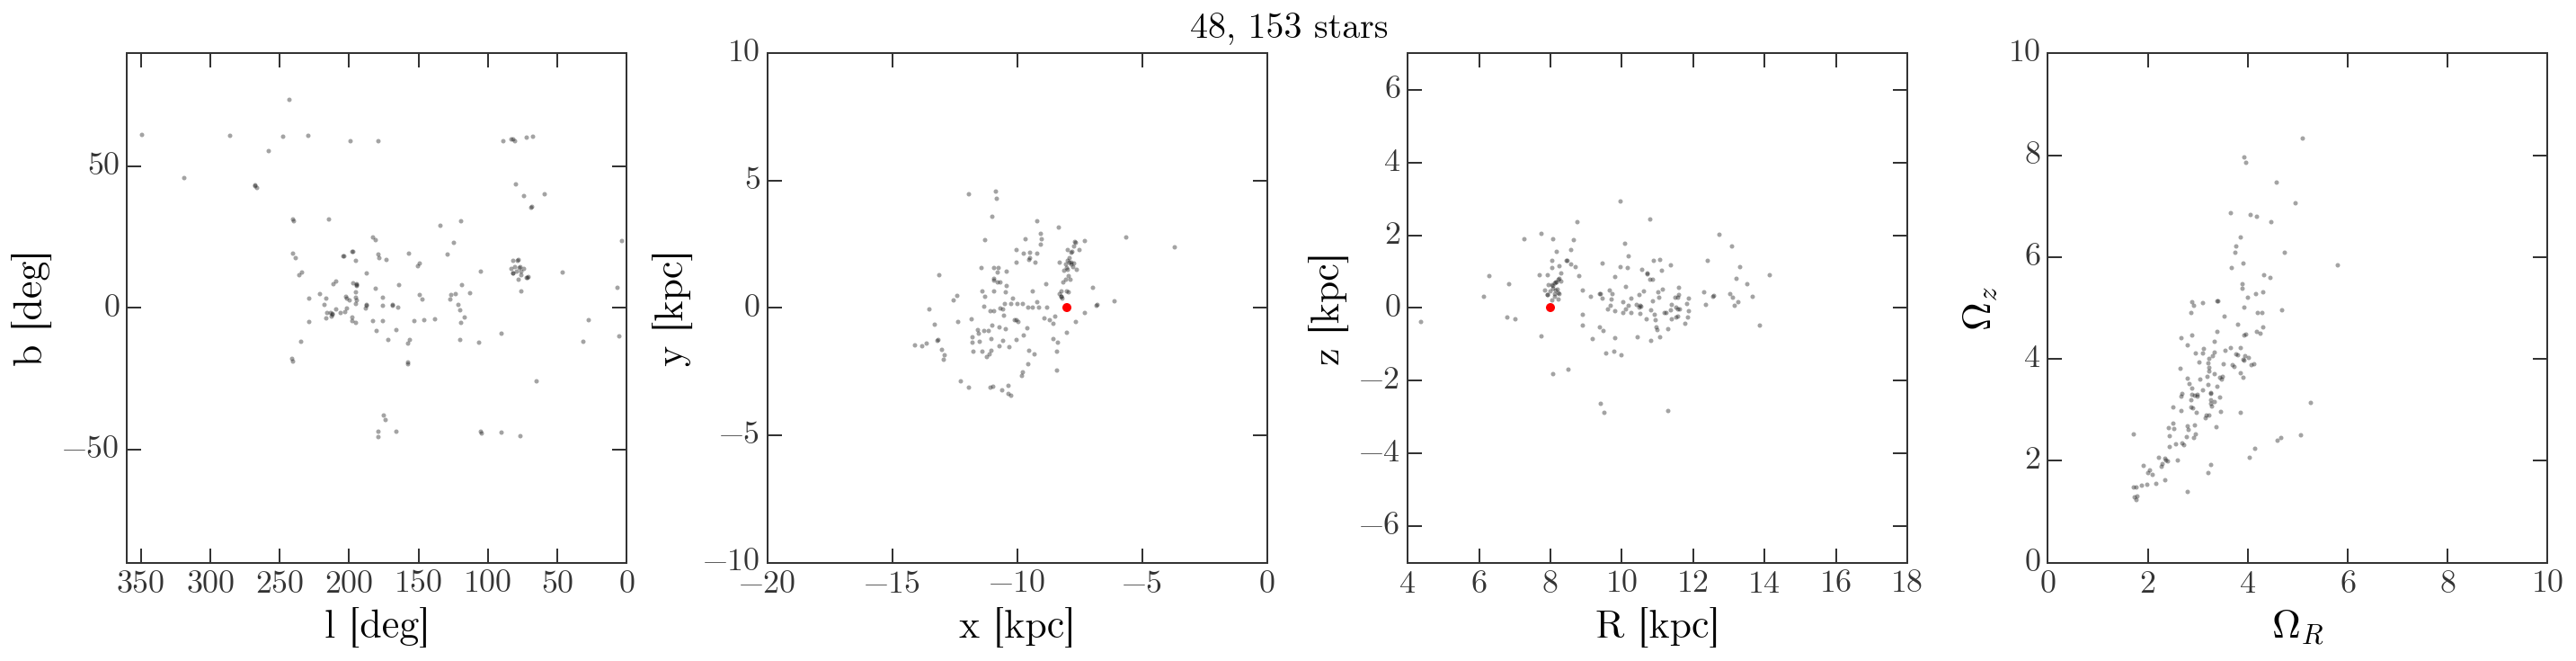

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

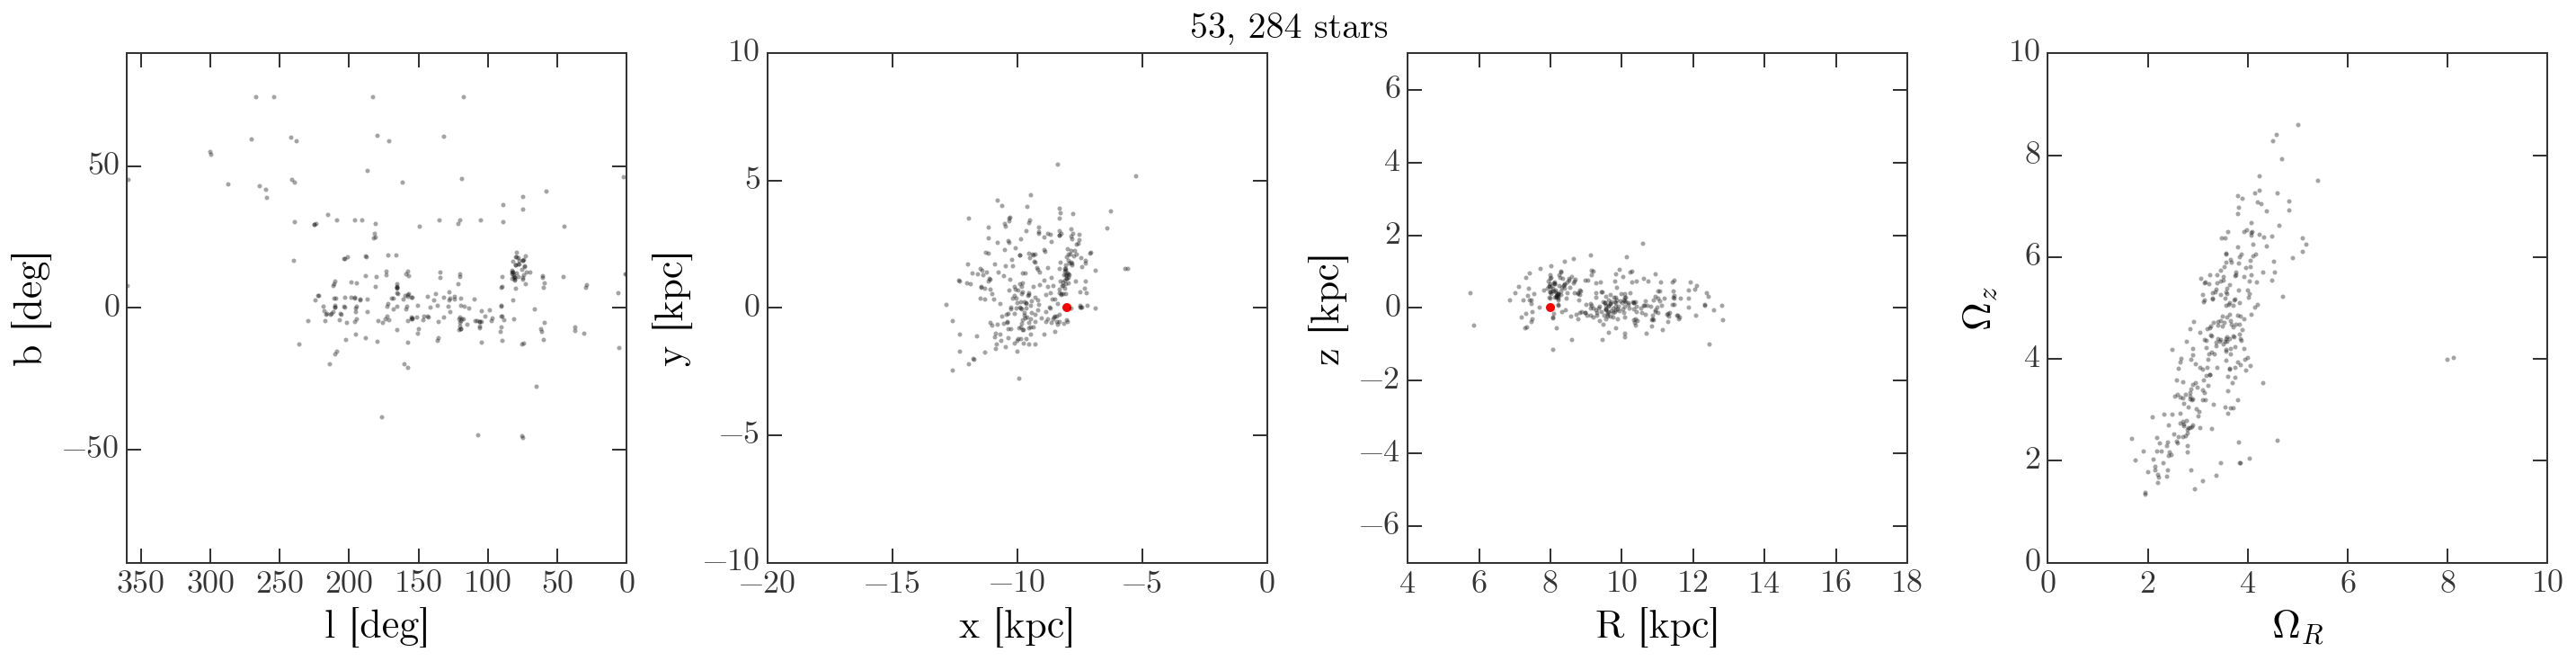

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

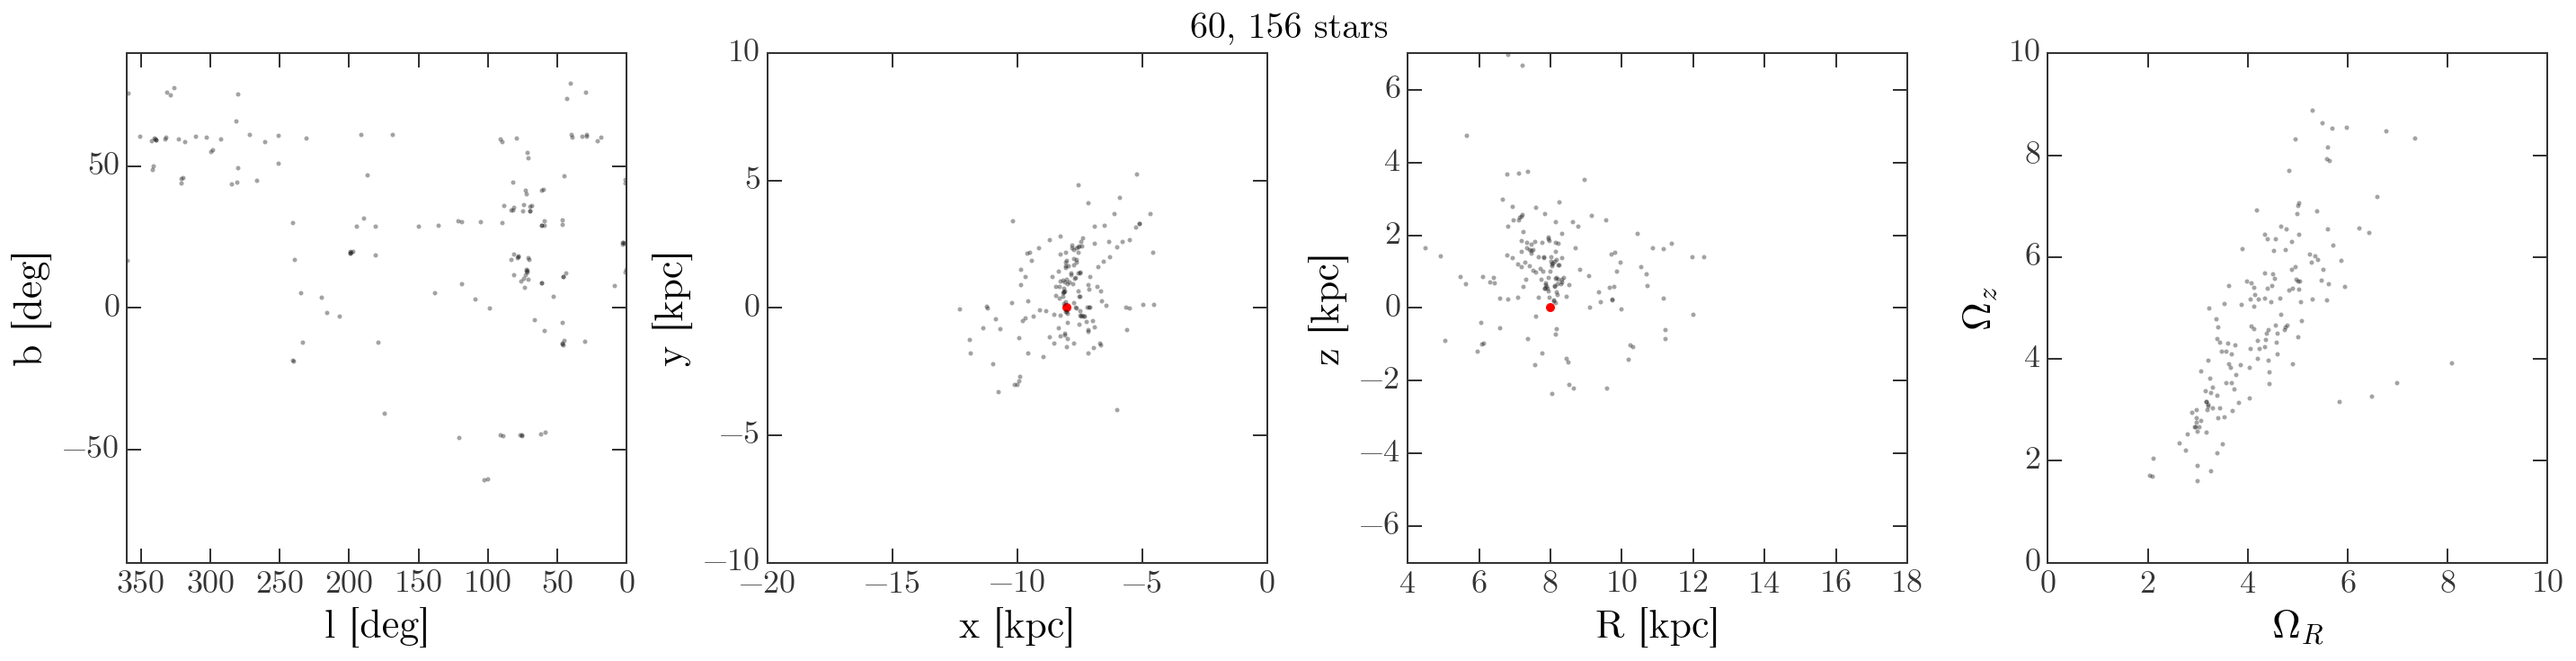

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

TypeError: First argument must be a path or file object reading bytes

In [205]:
alpha = 0.4 

for k in range(km.n_clusters):
    members = km.labels_ == k
#     if members.sum() < nmembers_threshold:
#         continue
    
    this_c = rv_c[non_nan][members].transform_to(coord.Galactic)
    this_galcen = this_c.transform_to(coord.Galactocentric)
    this_xyz = this_galcen.represent_as(coord.CartesianRepresentation).xyz
    this_cyl = this_galcen.represent_as(coord.CylindricalRepresentation)
    
    fig,axes = pl.subplots(1,4,figsize=(20,5))
    fig.suptitle("{}, {} stars".format(k,members.sum()), y=1.01, fontsize=20)
    axes[0].plot(this_c.l.degree, this_c.b.degree, marker='.', ls='none', alpha=alpha)
    axes[0].set_xlim(360, 0)
    axes[0].set_ylim(-90, 90)
    axes[0].set_xlabel("l [deg]")
    axes[0].set_ylabel("b [deg]")
    
    axes[1].plot(-8., 0., marker='o', color='r')
    axes[1].plot(this_xyz[0].value, this_xyz[1].value, marker='.', ls='none', alpha=alpha)
    axes[1].set_xlim(-20, 0)
    axes[1].set_ylim(-10, 10)
    axes[1].set_xlabel("x [kpc]")
    axes[1].set_ylabel("y [kpc]")
    
    axes[2].plot(8., 0., marker='o', color='r')
    axes[2].plot(this_cyl.rho.value, this_cyl.z.value, marker='.', ls='none', alpha=alpha)
    axes[2].set_xlim(4,18)
    axes[2].set_ylim(-7, 7)
    axes[2].set_xlabel("R [kpc]")
    axes[2].set_ylabel("z [kpc]")
    
    ix0 = feature_names.index('omegaR')
    ix1 = feature_names.index('omegaZ')
    axes[3].plot(X[members,ix0], X[members,ix1], marker='.', ls='none', alpha=alpha)
    axes[3].set_xlim(0,10)
    axes[3].set_ylim(0,10)
    axes[3].set_xlabel(r"$\Omega_R$")
    axes[3].set_ylabel(r"$\Omega_z$")
    
    fig.tight_layout()